---
title: ROI:intersection, C2mean (2 levels)
---

In [40]:
# import 
import pandas as pd
import warnings  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sys 
import pickle
import mpltern
import plotly.express as px
import plotly.graph_objects as go 
import matplotlib.image as mpimg 
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix, cohen_kappa_score 
import statsmodels.formula.api as smf
from PIL import Image
# Load libraries
sys.path.append('../') 
sys.path.insert(0,'/Users/linlin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/2024/AD lab/dataexp/pySuStaIn/sim')
import os 
import pySuStaIn  
from pathlib import Path
from plotly.offline import init_notebook_mode  
import plotly.io as pio
from plotly.graph_objs import * 
init_notebook_mode(connected=True)
pio.renderers.default = 'notebook_connected'
# import the python packages needed to generate simulated data for the tutorial
from termcolor import colored 
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_1samp, f_oneway, kurtosis, skew , ttest_ind, norm, t,chi2_contingency,  t
# column order 
lobes = ['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal', 
         'L_occipital', 'R_occipital','L_parietal', 'R_parietal' ]
data_path = "/Users/linlin/Desktop/brain stuff/data/"  


# Project Overview 

# Data 


**Subjects**:  
  - 450 participants = 365 sporadic EOAD subjects（cognitively impaired, amyloid-positive）+ 85 controls (cognitively normal, amyloid-negative)  

**Images**:  
  - Baseline tau-PET scans were smoothed to 6mm in native space, co-registered to MRI, and normalized using the inferior cerebellar gray as the reference region to derive standardized uptake volume ratio (SUVR) images.  
  - Parcellations based on the Desikan-Killiany atlas, covering 64 out of 72 regions (not used: left and right bank of the superior temporal sulcus, frontal pole, paracentral lobule, and temporal pole)

**Regions of Interest (ROIs) and thresholds**:  
  - Parcellations were grouped into 10 lobar ROIs (left and right): medial temporal lobe (MTL), temporal, parietal, frontal, and occipital lobes.  
  - Volume-weighted SUVRs were calculated for each of the 10 lobar ROIs.
  - The SUVR values are further standardized into z-scores using the lower-component and high-component intersection, and the hgher-mean component mean from 2-component Gaussian Mixture Models fitted on each of the 10 ROIs across all subjects (CN + EOAD). (bootstrap resample n = 5000), totaling to 20 event thresholds (2/ROI). 


# Analysis

This report takes as input a data frame including subjects' ID and visit, demographics, clinical variables, regional mean SUVR and tau z-score values, as well as  SuStaIn subtype & stage assignment (number of clusters/C = 2~6). The following results are output (see outline): 

**0. Model output**
- MCMC trace diagram as C increases

**1. SuStaIn-related results**
- subtype and stage assignment  
- change in subtype assignment as C increases  
- subtype probability by subtype and stage (ternary scatter)
- event visualization (positional variance & heatmap)
 
**2. Baseline**
- average tau-PET SUVR images, pair-wise comparison, 1 v.s. rest comparison (generated via matlab)
- table 1 
- laterality in each lobar ROI characterized by hemispheric asymmetry index 
- Clincal phenotypes by subtype, stage distribution for each subtype, and by subtype+stage   

**3. Longitudinal**
- visit overview (and exclusion due to treatment)
- annual rate of change in SuStaIn stage  
- percentage of subjects that progress/regress/remain in their SuStaIn stage  
- subtype agreement between baseline visit and last/2nd visit 
 

 

# Model output

## SuStaIn settings
The SuStaIn algorithm requires the following inputs.

**data**
The data you want to run SuStaIn on, of size M subjects by N biomarkers. This needs to be z-scored in the way described in the previous section.

**data_control**
used to z-scored all data. 

**Z_vals**
This is the set of z-scores you want to include for each biomarker. The more z-scores you use the longer the SuStaIn algorithm will take to run. Z_vals has size N biomarkers by Z z-scores. If you have more z-scores for some biomarkers than others you can simply leave zeros at the end of biomarker rows with fewer z-scores.

**Z_max**
The maximum z-score reached at the end of the progression, with size N biomarkers by 1. I'd suggest choosing a value around the 95th percentile of your data but you can experiment with different values. I typically choose an integer for interpretability but you don't have to.

**SuStaInLabels**
The names of the biomarkers you are using, for plotting purposes.

**N_startpoints**
The number of startpoints to use when fitting the subtypes hierarchichally. I'd suggest using 25.

**N_S_max**
The maximum number of subtypes to fit. I'd suggest starting with a lower number - maybe three - and then increasing that if you're getting a significantly better fit with the maximum number of subtypes. You can judge this roughly from the MCMC plot. To properly evaluate the optimal number of subtypes you need to run cross-validation.

**N_iterations_MCMC**
The number of iterations for the MCMC sampling of the uncertainty in the progression pattern. I'd recommend using 1x10^5 or 1x10^6.

**output_folder**
Choose an output folder for the results.

**dataset_name**
Name the results files outputted by SuStaIn.

**use_parellel_startpoints**
Boolean for whether or not to parallelize the startpoints.
 

In [41]:
# eligibility check
cn_exclude = ["LDS0220099", "LDS0110254", "LDS0670457", "LDS0370222"]
eoad_exclude = ["LDS0100607", "LDS0160473", "LDS0220084", "LDS0220159", "LDS0360398", "LDS0730183", "LDS0980440", "LDS0990439", "LDS1770209", "LDS1770310", "LDS1770403", "LDS3600132", "LDS3600550", "LDS3600671"]
ftp_data = pd.read_csv(data_path+'baseline_FTP_6mm.csv')
# read z-scored data (2GMM w/o EOnonAD, standardized)
zdata_full = pd.read_csv(data_path+'full_gmm2z_exclude.csv')
zdata = zdata_full[zdata_full.visit==1]
# to numpy
data = zdata[lobes].values
zdata_ctrl = zdata[zdata.dx == 'CN'][lobes].values
zdata_eoad = zdata[zdata.dx == 'EOAD'][lobes].values
zmax = zdata[lobes].apply(lambda x:np.percentile(x,95),axis=0).values#np.ceil(zdata[lobes].apply(max,axis=0)).values  
thre = pd.read_csv(data_path+'2gmm_thre_exclude.csv') 
thre = thre[['roi','intersection','c2mean']] 
#print('fixed thresholds: 2, 5, 10')
print('ROI-specific thresholds: intersection, c2mean')
np.round(pd.concat([thre,pd.DataFrame({'max':zmax})],axis=1),2)


ROI-specific thresholds: intersection, c2mean


roi  intersection  c2mean    max
0        L_MTL          1.13    5.13   9.32
1        R_MTL          1.25    4.92   8.44
2   L_temporal          1.86   15.20  26.18
3   R_temporal          1.97   14.68  25.05
4    L_frontal          1.49   10.73  20.92
5    R_frontal          1.80    9.98  20.08
6  L_occipital          2.21   15.40  31.83
7  R_occipital          2.04   14.92  32.36
8   L_parietal          2.12   16.58  29.07
9   R_parietal          2.12   18.07  32.63

In [42]:
zdata[lobes].apply(lambda x:np.percentile(x,95),axis=0).values

array([ 9.32385413,  8.44288745, 26.18108304, 25.04561328, 20.92123658,
       20.07647383, 31.8290841 , 32.35559502, 29.06514681, 32.63480256])

In [43]:
# Input the settings for z-score SuStaIn 
N = 10         # number of biomarkers
M = 365 # number of observations ( e.g. subjects )
M_control = 0   # number of these that are control subjects
N_startpoints = 25 #25
#N_S_gt = 1 #number of ground truth subtypes
N_S_max = 6 #7
N_iterations_MCMC = int(1e6) #1e4 / 1e6

SuStaInLabels = lobes
Z_vals = thre[['intersection','c2mean']].values#,'c2mean+sd']].values #np.array([[2,5,10]]*N) ## thre[['intersection','c2mean-sd','c2mean+sd']].values  # Z-scores for each biomarker
Z_max = zmax  #z95 #np.array([10]*N)           # maximum z-score 
output_folder = os.path.join(os.getcwd(),'inter_c2mean')#'inter_c2mean_sd_e6'#c2mean_sd_e6
dataset_name = '2GMMz' 
sustain_input = pySuStaIn.ZscoreSustain(zdata_eoad,
                                             Z_vals,
                                             Z_max,
                                             SuStaInLabels,
                                             N_startpoints,
                                             N_S_max, 
                                             N_iterations_MCMC, 
                                             output_folder, 
                                             dataset_name, 
                                             True)
print(f'reading output from: {output_folder}')

reading output from: /Users/linlin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/cap.nosync/sustain_ml/notebooks/inter_c2mean


In [44]:
import tableone
tableone.__version__

'0.9.1'

# Model running 

In [ ]:
# Load libraries
import os 
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection

# import the python packages needed to generate simulated data for the tutorial
import shutil 
import pickle
from pathlib import Path 
import pylab
# this needs to point to wherever the sim folder inside pySuStaIn is on your computer
sys.path.insert(0,'/Users/linlin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/2024/AD lab/dataexp/pySuStaIn/sim')
# if you're running the notebook from within the existing structure you can use
sys.path.insert(0,'../sim/')
from simfuncs import generate_random_Zscore_sustain_model, generate_data_Zscore_sustain

In [ ]:
# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [ ]:
sustain_input = pySuStaIn.ZscoreSustain(zdata_eoad,
                                             Z_vals,
                                             Z_max,
                                             SuStaInLabels,
                                             N_startpoints,
                                             N_S_max, 
                                             N_iterations_MCMC, 
                                             output_folder, 
                                             dataset_name, 
                                             True)
    

In [ ]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

## cross validation

In [ ]:
# choose the number of folds - here i've used three for speed but i recommend 10 typically
N_folds = 5

# generate stratified cross-validation training and test set splits
#labels = zdata.Diagnosis.values
#cv = sklearn.model_selection.StratifiedKFold(n_splits=N_folds, shuffle=True)
cv = sklearn.model_selection.KFold(n_splits=N_folds,shuffle=True,random_state=42)
cv_it = cv.split(zdata_eoad)

# SuStaIn currently accepts ragged arrays, which will raise problems in the future.
# We'll have to update this in the future, but this will have to do for now
test_idxs = []
for train, test in cv_it:
    test_idxs.append(test) 

In [ ]:
# The code recognises the files are there already rather than re-running SuStaIn
# This is useful if you want to increase the number of subtypes without 
# starting right from the beginning again
CVIC, loglike_matrix  = sustain_input.cross_validate_sustain_model(test_idxs)

## subtype number choice

In [ ]:
plt.rcParams['axes.titlesize'] = 16  # Set title font size
plt.rcParams['axes.labelsize'] = 14  # Set label font size
plt.rcParams['lines.markersize'] = 10  # Set marker size
plt.rcParams['axes.titleweight'] = 'regular'#'bold'  # Set title font weight to bold
plt.rcParams['axes.labelweight'] = 'regular'#'bold'  # Set label font weight to bold
plt.rcParams['lines.markersize'] = 8  # Set marker size
plt.rcParams['xtick.labelsize'] = 12  # Set tick label font size
plt.rcParams['ytick.labelsize'] = 12  # Set tick label font size 
plt.rcParams['figure.titlesize'] = 18 

In [ ]:
# Print outputs
print("CVIC for each subtype model: " + str(CVIC))
print("Average test set log-likelihood for each subtype model: " + str(np.mean(loglike_matrix, 0)))

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Define xticks
xticks = np.arange(1, N_S_max + 1)

# Plot 1: CVIC with marker points
axes[0].plot(xticks, CVIC, marker='o')
axes[0].set_xticks(xticks)
axes[0].set_ylabel('CVIC')
axes[0].set_xlabel('Subtypes model')
axes[0].set_title('CVIC')

# Plot 2: Test Set Log-Likelihood
df_loglike = pd.DataFrame(data=loglike_matrix, columns=["s_" + str(i + 1) for i in range(sustain_input.N_S_max)])
df_loglike.boxplot(ax=axes[1], grid=False)
axes[1].set_xticklabels(xticks)
axes[1].set_ylabel('Log likelihood')
axes[1].set_xlabel('Subtypes model')
axes[1].set_title('Test set log-likelihood across folds')

# Adjust layout
plt.suptitle("ROI thresholds: intersection/C2mean (MTL-hippocampus)")
plt.tight_layout()
plt.show()


## cross-validated sequence

In [ ]:
s = 3
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)
ml_sequence_em = pk['ml_sequence_EM']
# Translate sequence into lobe-level format while preserving the unique sequence order
max_level_ct = 2
def translate_sequence_by_lobe_then_level(seq, thresholds_dict, max_level_ct): 
    lobe_list = []
    level_list = []
    for i in range(max_level_ct):
        for lobe, thresholds in thresholds_dict.items():
            if len(thresholds) > i:  # Ensure there's at least one threshold
                lobe_list.append(lobe)  # Add the lobe to the lobe_list
                level_list.append(i+1)    # Add the index of the first item
    original_list = [f'{lobe_list[i]} level {level_list[i]}' for i in range(len(lobe_list))]
    return [original_list[int(s)] for s in seq]


# Create thresholds dictionary from Z_vals
thresholds_dict = {
    lobes[i]: Z_vals[i, Z_vals[i] > 0].tolist()  # Exclude 0s, use only valid thresholds
    for i in range(len(lobes))
}

# Process each subtype
subtype_orderings = [
    translate_sequence_by_lobe_then_level(seq, thresholds_dict, max_level_ct)
    for seq in ml_sequence_em
]
 

# Sort by prevalence
sorted_prevalence = np.round(sorted(pk['samples_f'].mean(axis=1), reverse=True), 2)
prevalence_order = np.argsort(-np.round(pk['samples_f'].mean(axis=1), 2))
sorted_subtype_orderings = [subtype_orderings[i] for i in prevalence_order]
 

In [ ]:

raw_stage = [ml_sequence_em[i] for i in prevalence_order]
raw_stage

In [ ]:
#this part estimates cross-validated positional variance diagrams
for i in range(3,4):
    figs, axs = sustain_input.combine_cross_validated_sequences(i+1, N_folds)

In [ ]:

# Function to make sure each subplot is on a separate row
def arrange_subplots_on_rows(fig, axs, biomarker_orders):
    # Get the total number of subplots
    try:
        num_plots = len(axs.flatten())
    except:
        num_plots = 1

    # Re-create the figure with the correct number of rows
    fig, new_axs = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 5 * num_plots))
    for i in range(num_plots):
        ax = axs.flatten()[i] if num_plots != 1 else axs
        img = ax.get_images()
        
        if img:
            biomarker_order = biomarker_orders[i]
            confus_matrix_c = img[0].get_array().data
            
            # Determine the axis for plotting based on num_plots
            target_ax = new_axs[i] if num_plots != 1 else new_axs
            im = target_ax.imshow(confus_matrix_c[biomarker_order, :, :], interpolation='nearest')
            
            # Set up biomarker labels
            biomarker_labels = lobes
            bml = [biomarker_labels[k] for k in biomarker_order]
            
            target_ax.set_xticks(ax.get_xticks())
            target_ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)  # Adjust x tick label size
            target_ax.set_yticks(ax.get_yticks())
            target_ax.set_yticklabels(bml, fontsize=18, ha='right')  # Adjust y tick label size
            
            # Keep the original title with adjusted font size
            target_ax.set_title(ax.get_title(), fontsize=18)

    return fig, new_axs

biomarker_orders = [list(map(int,raw_stage[0][raw_stage[0] < 10]))] * 6
new_fig, new_axs = arrange_subplots_on_rows(fig, axs, biomarker_orders)
# Adjust layout to prevent overlapping
new_fig.tight_layout()
# Display all the new figures
plt.show(new_fig)



## model likelihood  

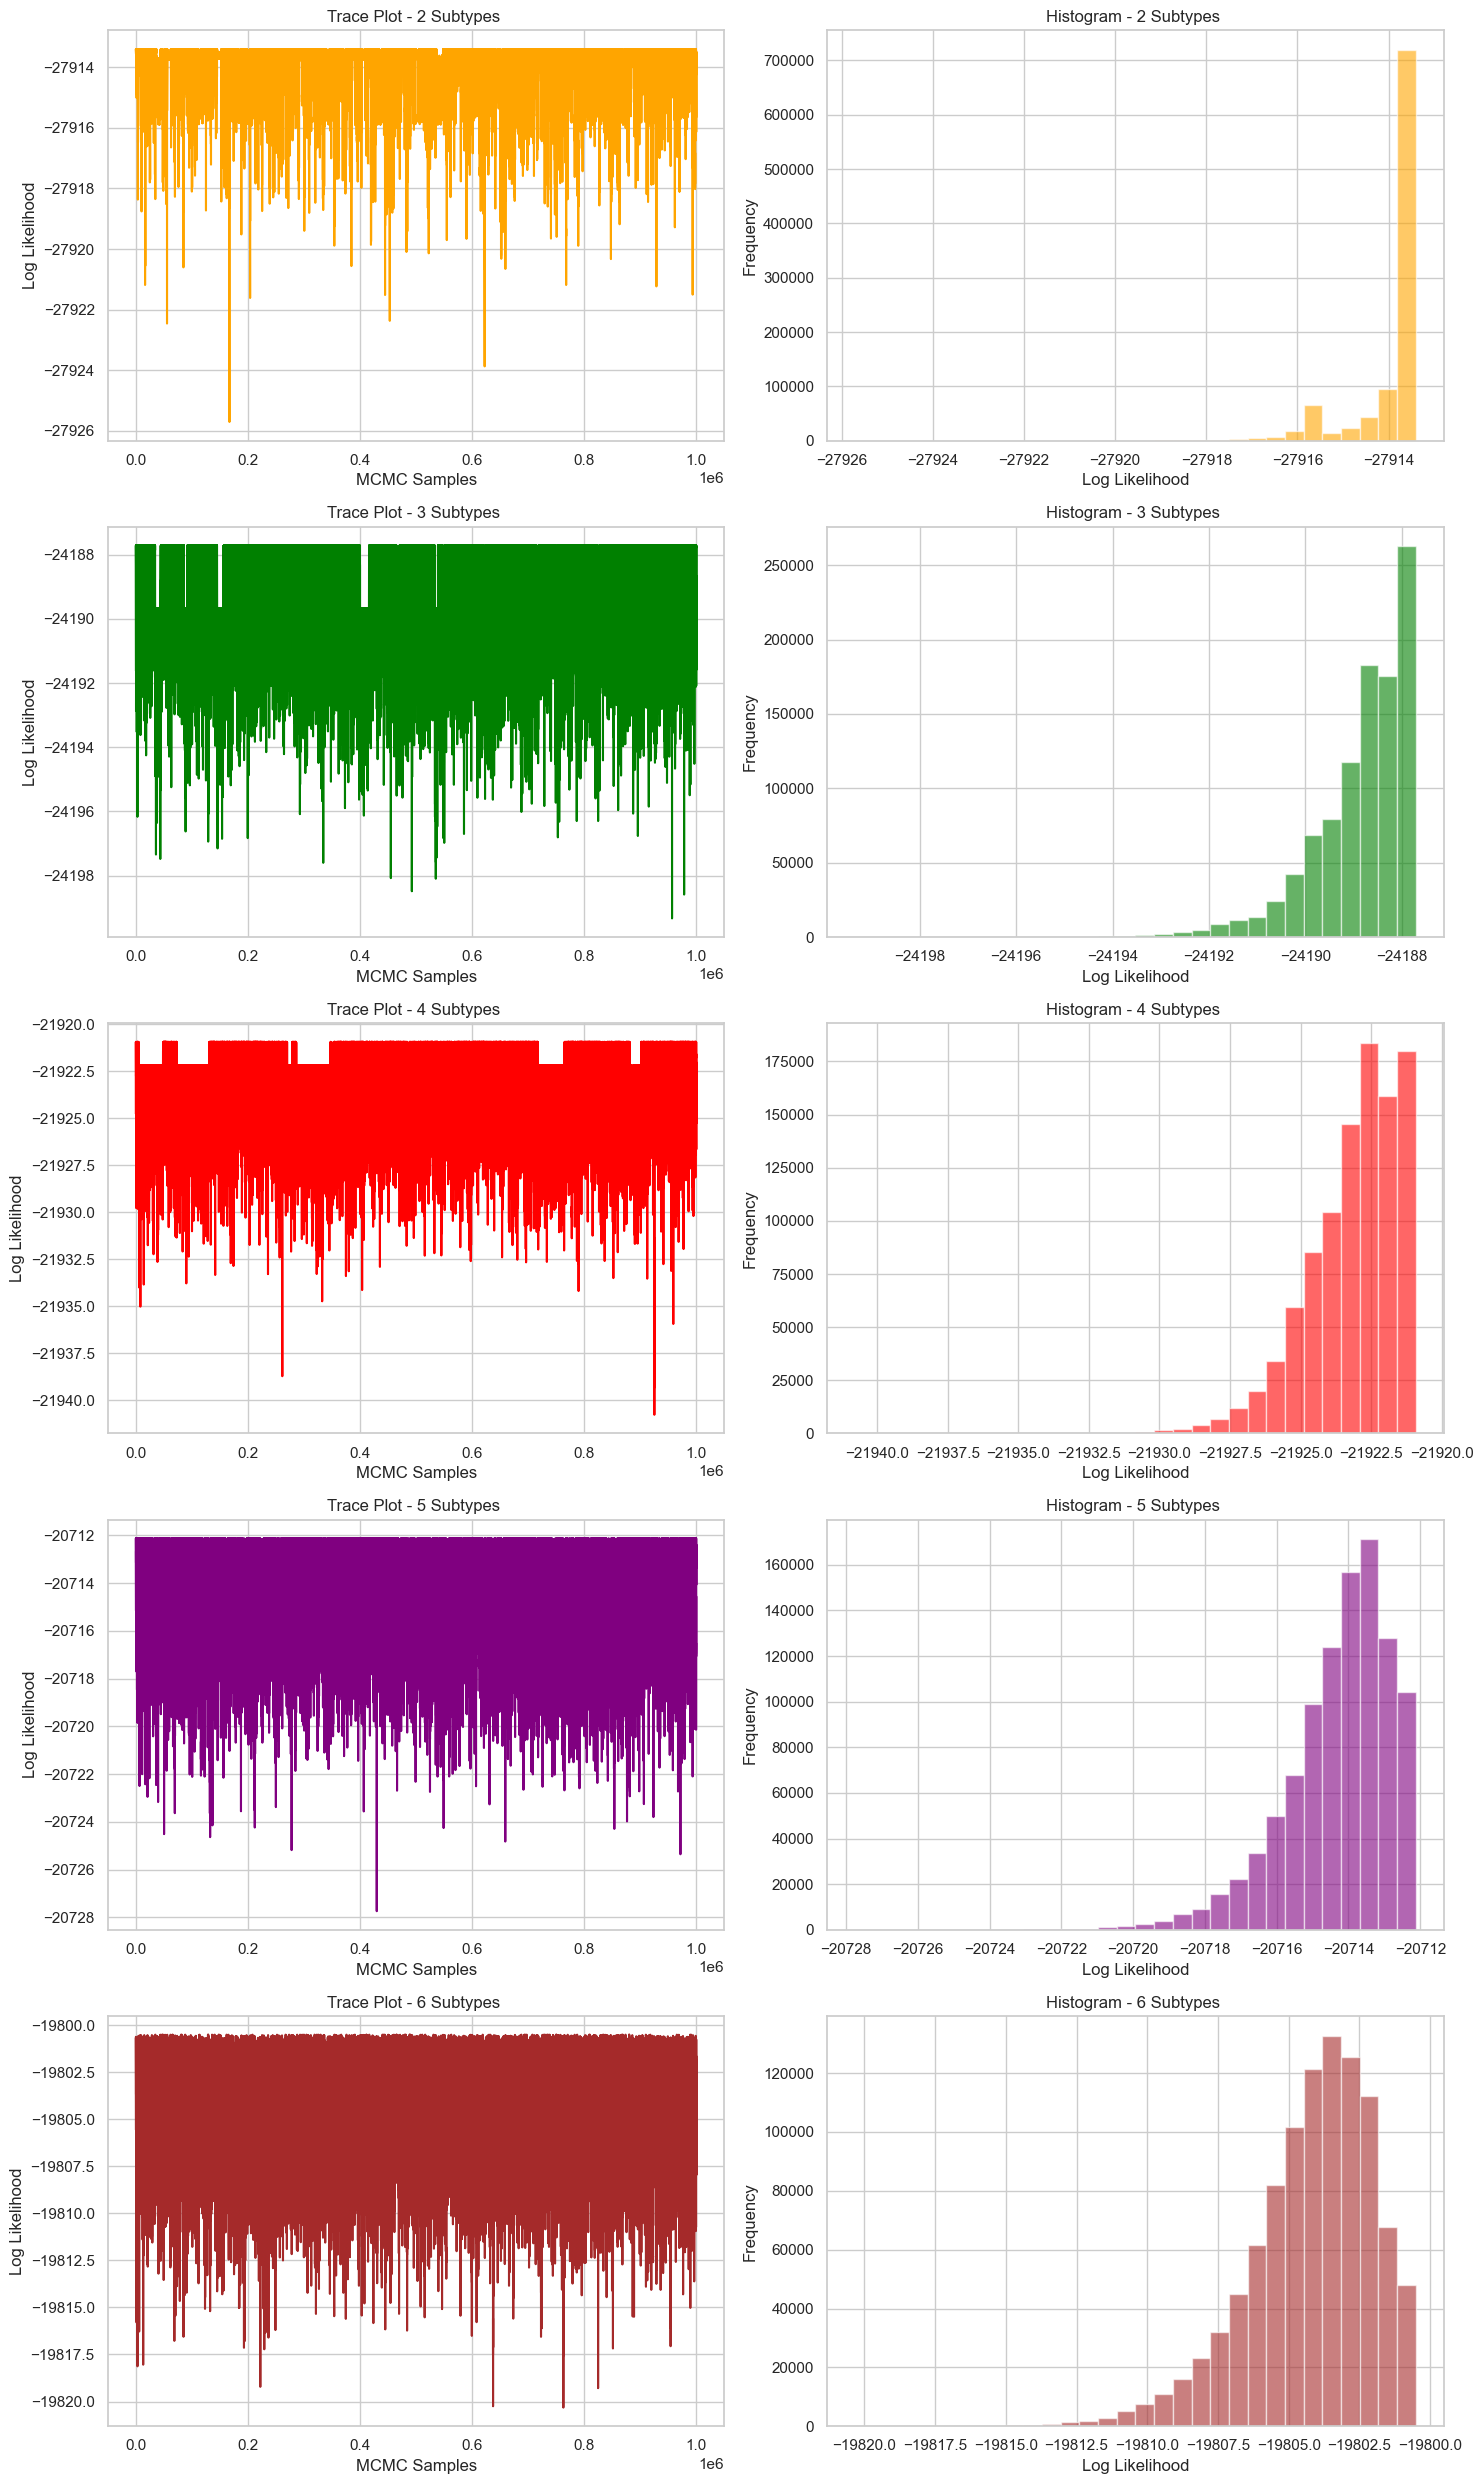

In [45]:
# Initialize figure for MCMC diagnostics (Trace and Histogram)
fig, axs = plt.subplots( N_S_max-1, 2, figsize=(15, 5*( N_S_max-1)))  # 5 subtypes, each with 2 plots (trace and histogram)

# List of colors for each subtype
subtype_colors = ['orange', 'green', 'red', 'purple', 'brown']  # List of colors for subtypes 1 to 5

for s in range(1, N_S_max):  # Loop over 1 to 5 for subtypes 2 to 6 (index adjusted)
    #print(s)
    pickle_filename_s = f"{output_folder}/pickle_files/{dataset_name}_subtype{s}.pickle"
    pickle_filepath = Path(pickle_filename_s)
    
    # Load pickle file
    with open(pickle_filepath, 'rb') as pickle_file:
        loaded_variables = pickle.load(pickle_file)
        samples_likelihood = loaded_variables["samples_likelihood"]
    
    # Plot MCMC Trace (subplot 1)
    axs[s-1, 0].plot(range(len(samples_likelihood)), samples_likelihood, color=subtype_colors[s-1])
    axs[s-1, 0].set_xlabel("MCMC Samples")
    axs[s-1, 0].set_ylabel("Log Likelihood")
    axs[s-1, 0].set_title(f"Trace Plot - {s+1} Subtypes ")  # Axis label should be 2 to 6
    
    # Plot Histogram (subplot 2)
    axs[s-1, 1].hist(samples_likelihood, bins=30, alpha=0.6, color=subtype_colors[s-1])
    axs[s-1, 1].set_xlabel("Log Likelihood")
    axs[s-1, 1].set_ylabel("Frequency")
    axs[s-1, 1].set_title(f"Histogram - {s+1} Subtypes ")  # Axis label should be 2 to 6

plt.tight_layout()
plt.show()


Fig. 1: Histograms of model log-likelihood estimated by MCMC samples (n = 10e6). As the number of subtype increases from 2 to 6, model likelihood improves. 

# SuStaIn-related output

In [46]:
df = pd.DataFrame(zdata_eoad,columns=lobes) 
s = 2
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    df.loc[:,variable] = pk[variable] 

# probability for each subject of being each subtype
for i in range(s):
    df.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]

# make current subtypes (0 and 1) 1 and 2 instead
df.loc[:,'ml_subtype'] = df.ml_subtype.values + 1

# convert "Stage 0" subjects to subtype 0
#df.loc[df.ml_stage==0,'ml_subtype'] = 0 # not excluded

# change prob_sx to handle diff number of subtypes
df.reset_index() 
df['prob_S2'] = 1 - df['prob_S0']- df['prob_S1']  #- df['prob_S2'] #- df['prob_S3'] - df['prob_S4'] 
df['subj'] = zdata[zdata.dx=='EOAD'].subj.values

# adjustment to reassign subtype based on prevalence
# Step 1: Count current subtype prevalence
prevalence = df['ml_subtype'].value_counts().sort_values(ascending=False)

# Step 2: Create a mapping for reassigning subtypes in order of prevalence
subtype_mapping = {old: new for new, old in enumerate(prevalence.index, start=1)}

# Step 3: Update ml_subtype using the mapping
df['ml_subtype'] = df['ml_subtype'].map(subtype_mapping)

# Step 4: Update probability columns to reflect the new subtype order
prob_columns = ['prob_S0', 'prob_S1', 'prob_S2']
prob_mapping = {0: 'prob_S0', 1: 'prob_S1', 2: 'prob_S2'}
# Reassign probabilities based on new subtype mapping
for new_subtype, old_subtype in subtype_mapping.items():
    df[f'prob_s{int(new_subtype) - 1}'] = df[prob_mapping[old_subtype - 1]]

# Drop old probability columns  
for col in prob_columns:
    if col not in [f'prob_s{new - 1}' for new in subtype_mapping.values()]:
        df.drop(columns=col, inplace=True)
#print(df.columns)
print('baseline subtype count (pre-exclusion):')
df.ml_subtype.value_counts()


baseline subtype count (pre-exclusion):


ml_subtype
1    148
2    111
3    106
Name: count, dtype: int64

## change in subtype assignment (alluvial)

In [47]:
 
# Filter the data for EOAD and initialize dataframe
alludf = zdata[zdata.dx == 'EOAD'][['subj']]

# Number of splits  
N_S_max = 6   

# Populate alludf with subtype assignments
for i in range(1, N_S_max):
    s = str(i)
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + s + '.pickle'
    pk = pd.read_pickle(pickle_filename_s)
    alludf[s] = pk['ml_subtype']
    alludf[s] = alludf[s].astype(int) + 1

# Calculate category orders for each column
category_orders = {}
for col in [str(i) for i in range(1, N_S_max)]:
    # Calculate order based on prevalence
    order = alludf[col].value_counts().sort_values(ascending=False).index.tolist()
    category_orders[col] = order

# Create the parallel categories plot
fig = px.parallel_categories(
    alludf,
    dimensions=[str(i) for i in range(1, N_S_max)],  # Columns ['1', '2', ..., N_S_max-1]
    color=alludf[str(N_S_max - 1)],  # Color by the last split column
    color_continuous_scale=px.colors.sequential.Blackbody,
    labels={
        '1': 'Subtype 2',
        '2': 'Subtype 3',
        '3': 'Subtype 4',
        '4': 'Subtype 5',
        '5': 'Subtype 6'
    }
)

# Sort each column in ascending order of category prevalence
fig.update_traces(dimensions=[
    {"categoryorder": "array", "categoryarray": category_orders[col]}
    for col in [str(i) for i in range(1, N_S_max)]
])
#fig.update_layout(
   # font=dict(size=1) # adjust this to show label
#)

# Use iplot for inline rendering
fig.show()


In [48]:
 

# Step 1: Build category orders for each split (most to least frequent)
category_orders = {}
for col in [str(i) for i in range(1, N_S_max)]:
    order = alludf[col].value_counts().sort_values(ascending=False).index.astype(str).tolist()
    category_orders[col] = order

# Step 2: Build dimensions list with categoryarray set for sorting
dimensions = []
for i in range(1, N_S_max):
    col = str(i)
    dim = dict(
        label="",#f"Subtype {i+1}",
        values=alludf[col].astype(str),
        categoryorder="array",
        categoryarray=category_orders[col]  # custom sort
    )
    dimensions.append(dim)

# Step 3: Map subtype at split 2 to color
color_map = {
    '1': "#1f449c",  # Dark Blue
    '2': "#32ABA6",  # Teal Green
    '3': "#f05039",  # Red
}
colors = alludf['2'].astype(str).map(color_map)

# Step 4: Create alluvial plot
fig = go.Figure(data=[
    go.Parcats(
        dimensions=dimensions,
        line={'color': colors},
        hoveron='color',
        labelfont={'size': 12, 'family': 'Arial'},
        tickfont={'size': 10, 'family': 'Arial'},
        arrangement='freeform',
        bundlecolors=True,
        sortpaths='forward'
    )
])

fig.update_layout(
    title="",#'Alluvial Plot of Subtype Assignments Across Splits',
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()


Fig. 2: Change in subtype assignments as C increases from 2 to 6; ordered by number of scans within each subtype, most to least from top to bottom in each column, and colored by subtype assignment when C = 6 (top), or when C = 3 (botto). 

## subtype and stage assignment for C=3

/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



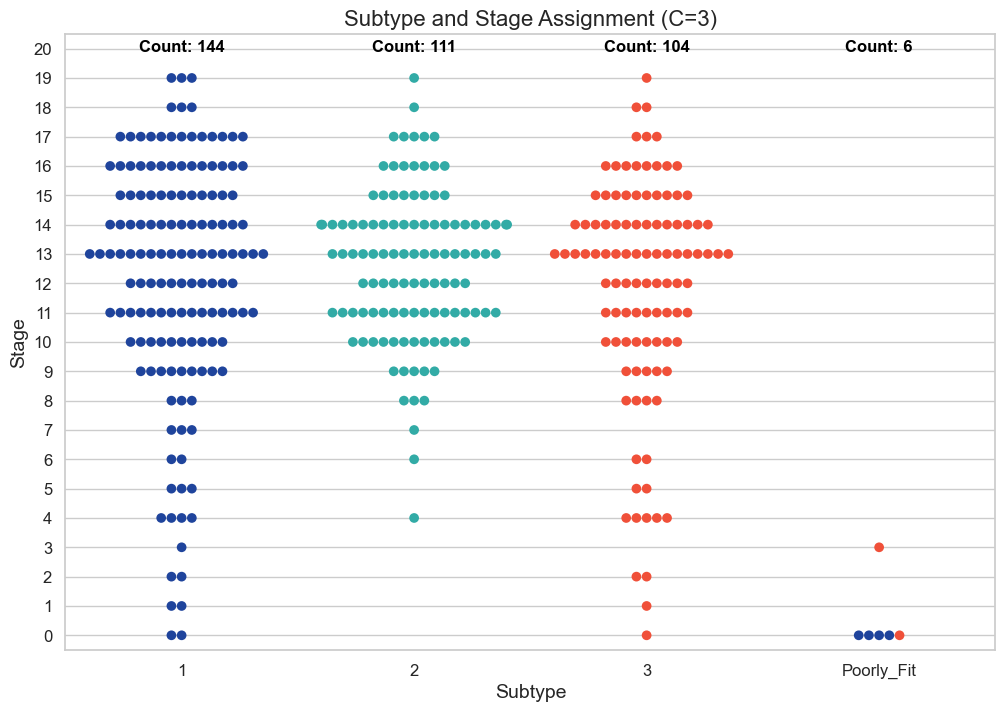

Poorly fit subjects (could be stage 0):
['LDS0110041' 'LDS0360627' 'LDS0990430' 'LDS0990523' 'LDS1770181'
 'LDS9410149']


In [49]:
 

# Ensure there are no infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Copy the DataFrame
ptdf = df.copy()

# Explicitly cast ml_subtype to object to allow assignment of 'Poorly_Fit'
ptdf['ml_subtype'] = ptdf['ml_subtype'].astype(object)

# Create a backup of ml_subtype for hue coloring
ptdf['ml_subtype0'] = ptdf['ml_subtype']

# Replace subtype values with 'Poorly_Fit' for prob_ml_subtype <= 0.5
ptdf.loc[ptdf['prob_ml_subtype'] <= 0.5, 'ml_subtype'] = 'Poorly_Fit'

# Set order of categories based on the subtype column
subtype_order = [1, 2, 3, 'Poorly_Fit']

# Define custom colors for each subtype
custom_palette = {
    1: "#1f449c",  # Dark Blue
    2: "#32ABA6",  # Green
    3: "#f05039",  # Red
    #"Poorly_Fit": "#7f7f7f"  # Grey
}

# Plot the graph using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))  # Increase figure size for better readability

# Create the swarm plot with hue, ordered by ml_subtype
ax = sns.swarmplot(
    data=ptdf, 
    x='ml_subtype', 
    y='ml_stage', 
    hue='ml_subtype0', 
    palette=custom_palette, 
    order=subtype_order,
    size = 7
)

# Remove legend
plt.legend().remove()

# Adjust font size of labels and title
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Subtype', fontsize=14)
plt.ylabel('Stage', fontsize=14)
plt.title('Subtype and Stage Assignment (C=3)', fontsize=16)

# Set y-tick marks to range from 0 to 30
ax.set_yticks(range(0, 21, 1))
ax.set_ylim(-0.5, 20.5)

# Calculate total count for each subtype
subtype_counts = ptdf['ml_subtype'].value_counts()

# Annotate the plot with the total count for each subtype
for i, subtype in enumerate(subtype_order):
    if subtype in subtype_counts:
        count = subtype_counts[subtype]
        ax.text(i, ptdf['ml_stage'].max() + 0.9, f'Count: {count}', 
                ha='center', fontsize=12, color='black', weight='bold')

plt.show()

# Print poorly fit subjects (including stage 0)
print('Poorly fit subjects (could be stage 0):')
poorly_fit_subjects = zdata[zdata.dx == 'EOAD'].loc[(ptdf['prob_ml_subtype'] <= 0.5).values, 'subj'].values
print(poorly_fit_subjects)


## stage distribution description

In [50]:
# Function to calculate IQR
def calculate_iqr(x):
    return np.percentile(x, 75) - np.percentile(x, 25)

# Group by 'ml_subtype' and calculate descriptive statistics
descriptive_stats = (
    ptdf[ptdf.ml_subtype.isin([1, 2, 3])]
    .groupby('ml_subtype')['ml_stage']
    .apply(lambda x: pd.Series({
        'q1': round(np.percentile(x.dropna(), 25), 2),
        'q3': round(np.percentile(x.dropna(), 75), 2),
        'iqr': round(np.percentile(x.dropna(), 75) - np.percentile(x.dropna(), 25), 2),
        'mean': round(x.mean(), 2),
        'std': round(x.std(), 2),
        'kurtosis': round(kurtosis(x, nan_policy='omit'), 2),
        'skewness': round(skew(x, nan_policy='omit'), 2) 
    }))
)
 

# Reset index for better readability
descriptive_stats = descriptive_stats.reset_index()
# Pivot the table to wide format
descriptive_stats_wide = descriptive_stats.pivot(
    index='ml_subtype', 
    columns='level_1', 
    values='ml_stage'
).reset_index()

# Rename the columns for better readability
descriptive_stats_wide.columns.name = None  # Remove the column group name
descriptive_stats_wide = descriptive_stats_wide.rename_axis(None, axis=1)  # Remove index axis name

# Display the wide-format table
print("Descriptive statistics for SuStaIn stage by subtype:")
descriptive_stats_wide[['ml_subtype', 'q1', 'q3','iqr',  'mean',  'std','kurtosis', 'skewness']]
 

Descriptive statistics for SuStaIn stage by subtype:


ml_subtype    q1    q3  iqr   mean   std  kurtosis  skewness
0           1  10.0  15.0  5.0  12.09  4.21      0.47     -0.88
1           2  11.0  14.0  3.0  12.56  2.60      0.37     -0.27
2           3  10.0  14.0  4.0  11.78  3.93      0.67     -0.98

Fig. 3: Stage assignment by subtype for C=3 and descriptive statistics for stage distributions. Poorly fit scans are those with probability belonging to any subtype below 0.5, and are colored by their final assignments.  

## subtype probability  

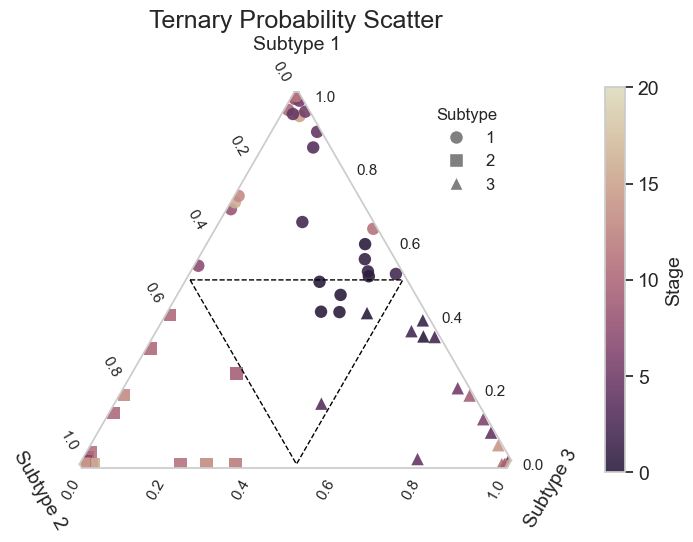

In [51]:
# Define marker styles for each subtype
marker_styles = {1.: "o", 2.: "s", 3.: "^"}  # Circle for S0, square for S1, triangle for S2

# Create the ternary scatterplot
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection="ternary")

# Store handles for the legend
handles = []

# Plot each subtype with a unique marker
for subtype, marker in marker_styles.items():
    subset = df[df['ml_subtype'] == subtype]
    scatter = ax.scatter(
        subset['prob_s0'], 
        subset['prob_s1'], 
        subset['prob_s2'], 
        marker=marker,     # Assign unique marker
        c=subset['ml_stage'],  # Color by 'ml_stage'
        cmap=sns.color_palette("ch:s=-.1,r=.6", as_cmap=True).reversed(),   # Gradient from light to dark
        s=80,              # Marker size
        alpha=.9,         # Transparency
        edgecolors="none", # Ensure edges don't cover points
        vmin=0,            # Set minimum color value
        vmax=20            # Set maximum color value
    )
    # Add marker to legend
    handles.append(plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='gray', markersize=10, label=f"{int(subtype)}"))

# Add inner dashed-line triangle for probabilities < 0.5
# Inner triangle vertices (all probabilities = 0.5)
vertices = [
    (0.5, 0.5, 0),  # Between S0 and S1
    (0.5, 0, 0.5),  # Between S0 and S2
    (0, 0.5, 0.5),  # Between S1 and S2
    (0.5, 0.5, 0)   # Close the triangle
]

# Extract x, y, z coordinates from vertices
x_coords, y_coords, z_coords = zip(*vertices)

# Draw the dashed line for the inner region
ax.plot(x_coords, y_coords, z_coords, linestyle="--", color="black", linewidth=1)

# Set labels for each corner (all horizontal now)
ax.set_tlabel("Subtype 1", fontsize=14, rotation=0, ha='center')
ax.set_llabel("Subtype 2", fontsize=14, rotation=0, ha='center')
ax.set_rlabel("Subtype 3", fontsize=14, rotation=0, ha='center')

ax.set_rlim(-0.01, 1.01)
ax.set_tlim(-0.01, 1.01)
ax.set_llim(-0.01, 1.01)

# Remove the grid
ax.grid(False)

# Adjust title font size
plt.title("Ternary Probability Scatter", fontsize=18)

# Add colorbar with padding
cbar = plt.colorbar(ax.collections[0], pad=0.15)
cbar.ax.tick_params(labelsize=14)  # Adjust colorbar tick font size
cbar.set_label("Stage", fontsize=14)
 
cbar.set_ticks(np.arange(0, 21, 5))  # Force integer ticks from 0 to 20

# Add legend for marker shapes
plt.legend(handles=handles, loc='upper right', title="Subtype", fontsize=12, title_fontsize=12, frameon=False)

# Display the plot
plt.show()


Fig. 4: ternary scatterplot showing subtype probability of each subject, colored by stage, marked by subtype. Subjects with lower stages tend to have lower subtype probabilities. The region within the inner triangle indicates poorly fit.

reading ternary plot: https://grapherhelp.goldensoftware.com/Graphs/Reading_Ternary_Diagrams.htm 

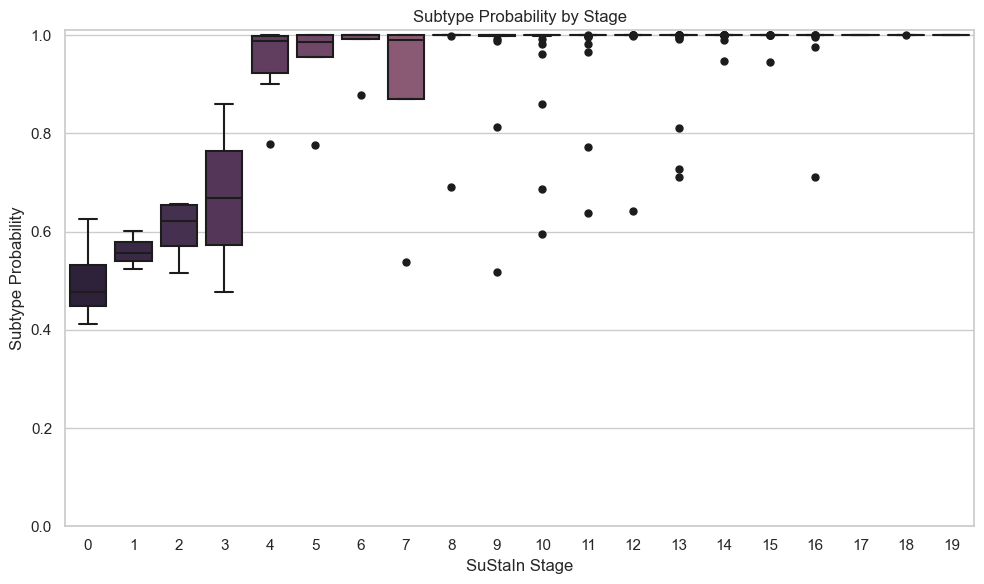

In [52]:
 
# Create reversed colormap
cmap = sns.color_palette("ch:s=-.1,r=.6", as_cmap=True).reversed()

# Get unique, sorted integer ml_stage values
stages = sorted(df['ml_stage'].unique())

# Create stage-to-color mapping
colors = [cmap(i / (len(stages) - 1)) for i in range(len(stages))]
stage_color_map = dict(zip(stages, colors))

# Plot
plt.figure(figsize=(10, 6))

# Seaborn boxplot with custom palette
sns.boxplot(
    data=df,
    x='ml_stage',
    y='prob_ml_subtype',
    palette=stage_color_map,
    flierprops=dict(
        marker='o',
        markersize=5,
        linestyle='none',  # Remove connecting line
    )
)

# Manually match flier (outlier) colors to box colors
ax = plt.gca()
for i, artist in enumerate(ax.artists):
    color = colors[i]
    # Set box color
    artist.set_facecolor(color)

    # Set the color of flier markers for this box
    line_collection = ax.lines[i * 6 + 4]  # Outlier line index pattern
    line_collection.set_color(color)

# Axis formatting
plt.ylim([0,1.01])
plt.title("Subtype Probability by Stage")
plt.xlabel("SuStaIn Stage")
plt.ylabel("Subtype Probability")
plt.xticks(ticks=range(len(stages)), labels=[int(s) for s in stages])  # Ensure integer ticks
plt.tight_layout()
plt.show()


Fig. 4 add: subtype probability across stage

## event ordering 
principal:
order by lobe and then level, from lowest to highest stage. e.g., 1 is L MTL level 1, 2 is R MTL level 1, ... 

In [53]:
s = 2
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)
ml_sequence_em = pk['ml_sequence_EM']

In [54]:
# Translate sequence into lobe-level format while preserving the unique sequence order
max_level_ct = 2
def translate_sequence_by_lobe_then_level(seq, thresholds_dict, max_level_ct): 
    lobe_list = []
    level_list = []
    for i in range(max_level_ct):
        for lobe, thresholds in thresholds_dict.items():
            if len(thresholds) > i:  # Ensure there's at least one threshold
                lobe_list.append(lobe)  # Add the lobe to the lobe_list
                level_list.append(i+1)    # Add the index of the first item
    original_list = [f'{lobe_list[i]} level {level_list[i]}' for i in range(len(lobe_list))]
    return [original_list[int(s)] for s in seq]


# Create thresholds dictionary from Z_vals
thresholds_dict = {
    lobes[i]: Z_vals[i, Z_vals[i] > 0].tolist()  # Exclude 0s, use only valid thresholds
    for i in range(len(lobes))
}

# Process each subtype
subtype_orderings = [
    translate_sequence_by_lobe_then_level(seq, thresholds_dict, max_level_ct)
    for seq in ml_sequence_em
]

# Function to color code the levels
def color_text(text, level):
    if level == 1:
        return colored(text.split()[0], 'blue')
    elif level == 2:
        return colored(text.split()[0], 'magenta')
    elif level == 3:
        return colored(text.split()[0], 'red')
    else:
        return text

print('Subtype event orderings: ')
print(colored('Level 1', 'blue'))
print(colored('Level 2', 'magenta'))
#print(colored('Level 3\n', 'red'))

# Helper function to wrap lines
def wrap_text(text, width=80):
    lines = []
    while len(text) > width:
        split_index = text[:width].rfind(" -> ")  # Split at the last " -> " within the width
        if split_index == -1:
            split_index = width  # Fallback to a hard split
        lines.append(text[:split_index])
        text = text[split_index + 4:]  # Skip over " -> "
    lines.append(text)
    return lines

# Sort by prevalence
sorted_prevalence = np.round(sorted(pk['samples_f'].mean(axis=1), reverse=True), 2)
prevalence_order = np.argsort(-np.round(pk['samples_f'].mean(axis=1), 2))
sorted_subtype_orderings = [subtype_orderings[i] for i in prevalence_order]

# Process and color the text for each subtype
for i in range(len(subtype_orderings)):
    ordering = sorted_subtype_orderings[i] 
    print(colored(f"Subtype {i+1} ({np.round(sorted_prevalence[i]*100, 3)}%) Ordering:", attrs=['bold', 'underline']))
    colored_sequence = []  # Collect the colored sequence for this subtype
    for event in ordering:
        lobe, level = event.rsplit(" ", 1)  # Split into lobe and level
        level_number = int(level.split()[-1])  # Extract level number
        colored_sequence.append(color_text(event, level_number))  # Add the colored event
    
    # Join the events with "->" and wrap the output
    full_sequence = " -> ".join(colored_sequence)
    wrapped_lines = wrap_text(full_sequence)
    for line in wrapped_lines:
        print(line)


Subtype event orderings: 
Level 1
Level 2
Subtype 1 (40.0%) Ordering:
R_MTL -> L_MTL -> R_parietal
L_parietal -> R_temporal -> L_temporal
R_occipital -> R_frontal -> L_occipital
L_frontal -> L_frontal -> R_frontal
R_temporal -> L_temporal -> R_parietal
L_parietal -> R_occipital -> L_occipital
L_MTL -> R_MTL
Subtype 2 (31.0%) Ordering:
L_frontal -> R_temporal -> L_MTL
R_MTL -> R_frontal -> L_temporal
R_parietal -> L_parietal -> L_occipital
R_occipital -> L_temporal -> L_parietal
L_occipital -> R_parietal -> R_occipital
R_temporal -> L_frontal -> L_MTL
R_frontal -> R_MTL
Subtype 3 (30.0%) Ordering:
L_MTL -> R_MTL -> L_temporal
L_occipital -> L_parietal -> R_temporal
R_parietal -> R_occipital -> L_frontal
R_frontal -> R_occipital -> L_occipital
R_parietal -> L_parietal -> R_temporal
R_frontal -> L_temporal -> L_frontal
R_MTL -> L_MTL


In [55]:
raw_stage = [ml_sequence_em[i] for i in prevalence_order]
raw_stage

[array([ 1.,  0.,  9.,  8.,  3.,  2.,  7.,  5.,  6.,  4., 14., 15., 13.,
        12., 19., 18., 17., 16., 10., 11.]),
 array([ 4.,  3.,  0.,  1.,  5.,  2.,  9.,  8.,  6.,  7., 12., 18., 16.,
        19., 17., 13., 14., 10., 15., 11.]),
 array([ 0.,  1.,  2.,  6.,  8.,  3.,  9.,  7.,  4.,  5., 17., 16., 19.,
        18., 13., 15., 12., 14., 11., 10.])]

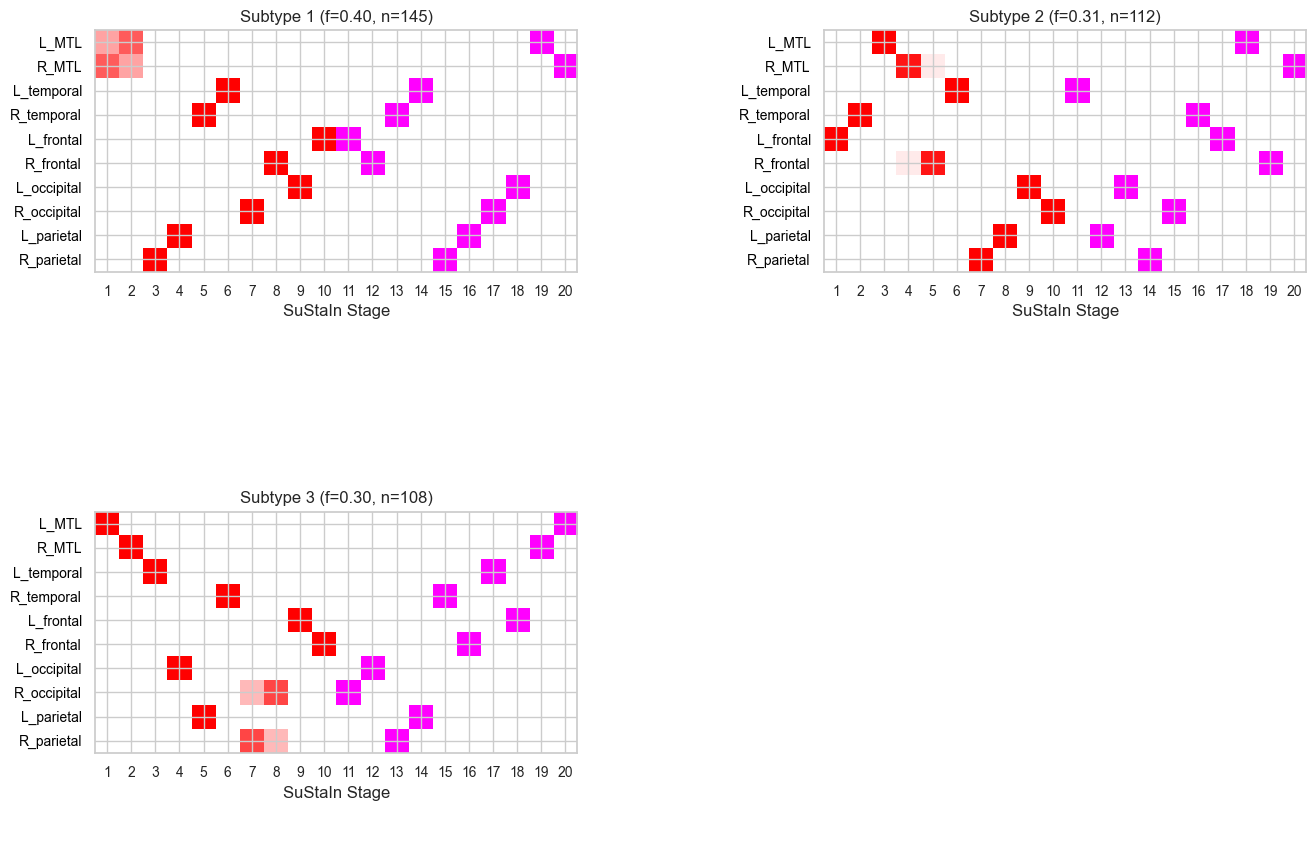

In [56]:
 
s = 2 # 1 split = 2 subtypes
M = len(zdata_eoad) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]
  
# use this information to plot the positional variance diagrams
figs, axs = pySuStaIn.ZscoreSustain._plot_sustain_model_fix(sustain_input,samples_sequence,samples_f,M,subtype_order=prevalence_order,
                                                       biomarker_labels=lobes,
                                                       #biomarker_colours=sns.color_palette('tab10'),
                                                       biomarker_order=range(10))#list(map(int,raw_stage[0][raw_stage[0] < 10])))

  
# Adjust figure size to prevent clustering of labels
try:
    for fig in figs:
        fig.set_size_inches(15, 10)  # Increase the size of each figure
except:
    figs.set_size_inches(15, 10)  # Increase the size of each figure


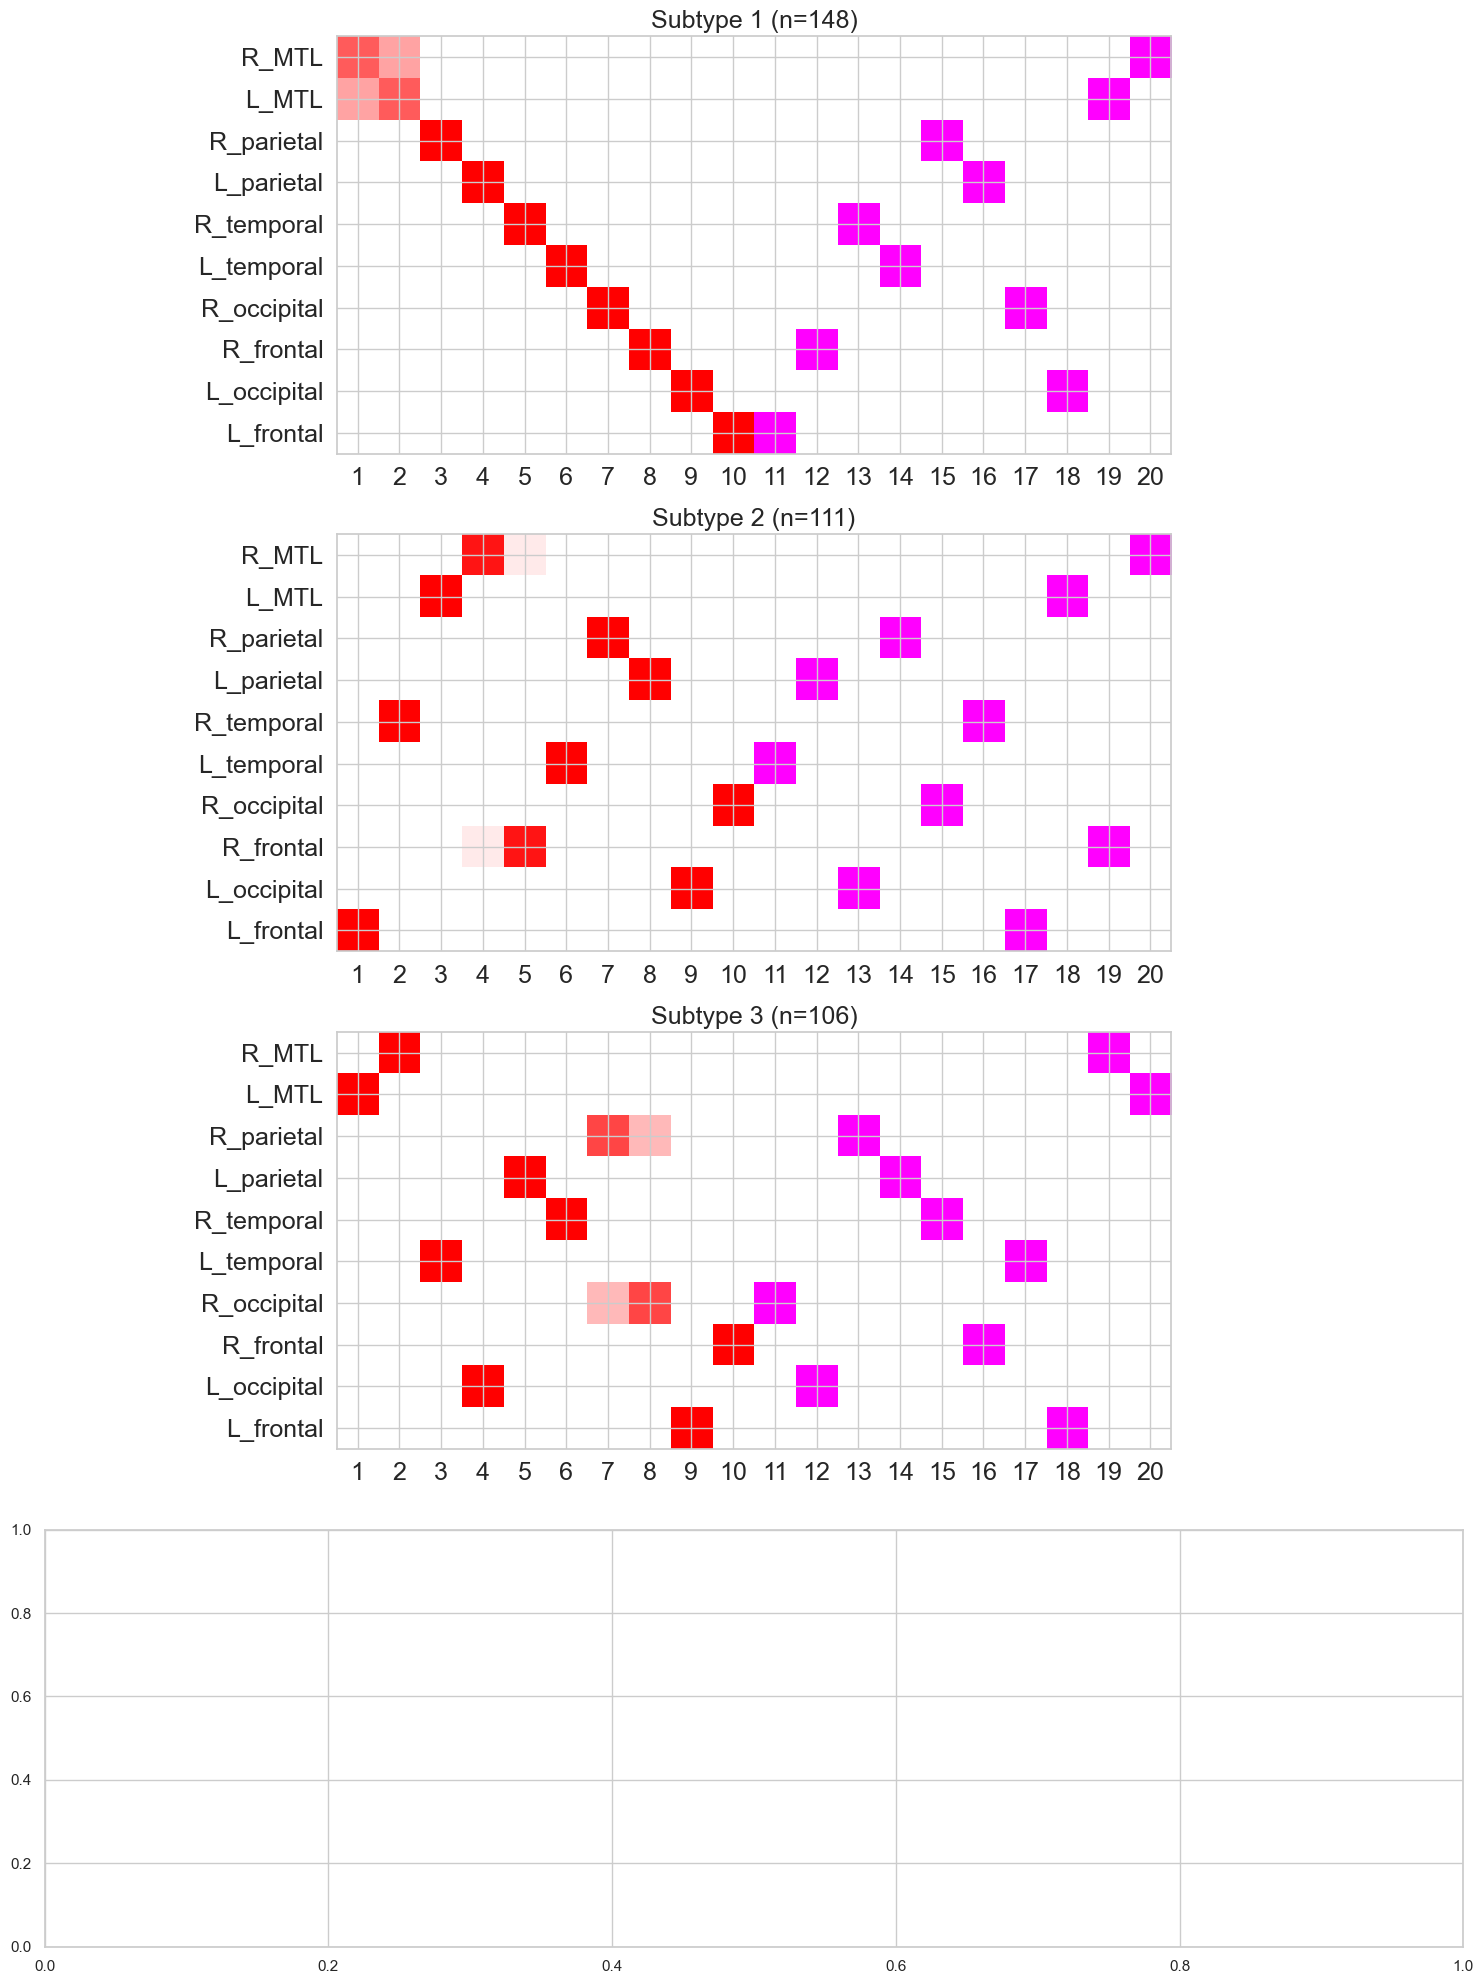

In [57]:

# Function to make sure each subplot is on a separate row
def arrange_subplots_on_rows(fig, axs, biomarker_orders):
    # Get the total number of subplots
    try:
        num_plots = len(axs.flatten())
    except:
        num_plots = 1

    # Re-create the figure with the correct number of rows
    fig, new_axs = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 5 * num_plots))
    for i in range(num_plots):
        ax = axs.flatten()[i] if num_plots != 1 else axs
        img = ax.get_images()
        
        if img:
            biomarker_order = biomarker_orders[i]
            confus_matrix_c = img[0].get_array().data
            
            # Determine the axis for plotting based on num_plots
            target_ax = new_axs[i] if num_plots != 1 else new_axs
            im = target_ax.imshow(confus_matrix_c[biomarker_order, :, :], interpolation='nearest')
            
            # Set up biomarker labels
            biomarker_labels = lobes
            bml = [biomarker_labels[k] for k in biomarker_order]
            
            target_ax.set_xticks(ax.get_xticks())
            target_ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)  # Adjust x tick label size
            target_ax.set_yticks(ax.get_yticks())
            target_ax.set_yticklabels(bml, fontsize=18, ha='right')  # Adjust y tick label size
            
            # Keep the original title with adjusted font size
            target_ax.set_title(f'Subtype {i+1} (n={prevalence.values[i]})', fontsize=18)#ax.get_title

    return fig, new_axs

biomarker_orders = [list(map(int,raw_stage[0][raw_stage[0] < 10]))] * 6
new_fig, new_axs = arrange_subplots_on_rows(fig, axs, biomarker_orders)
# Adjust layout to prevent overlapping
new_fig.tight_layout()
# Display all the new figures
plt.show(new_fig)



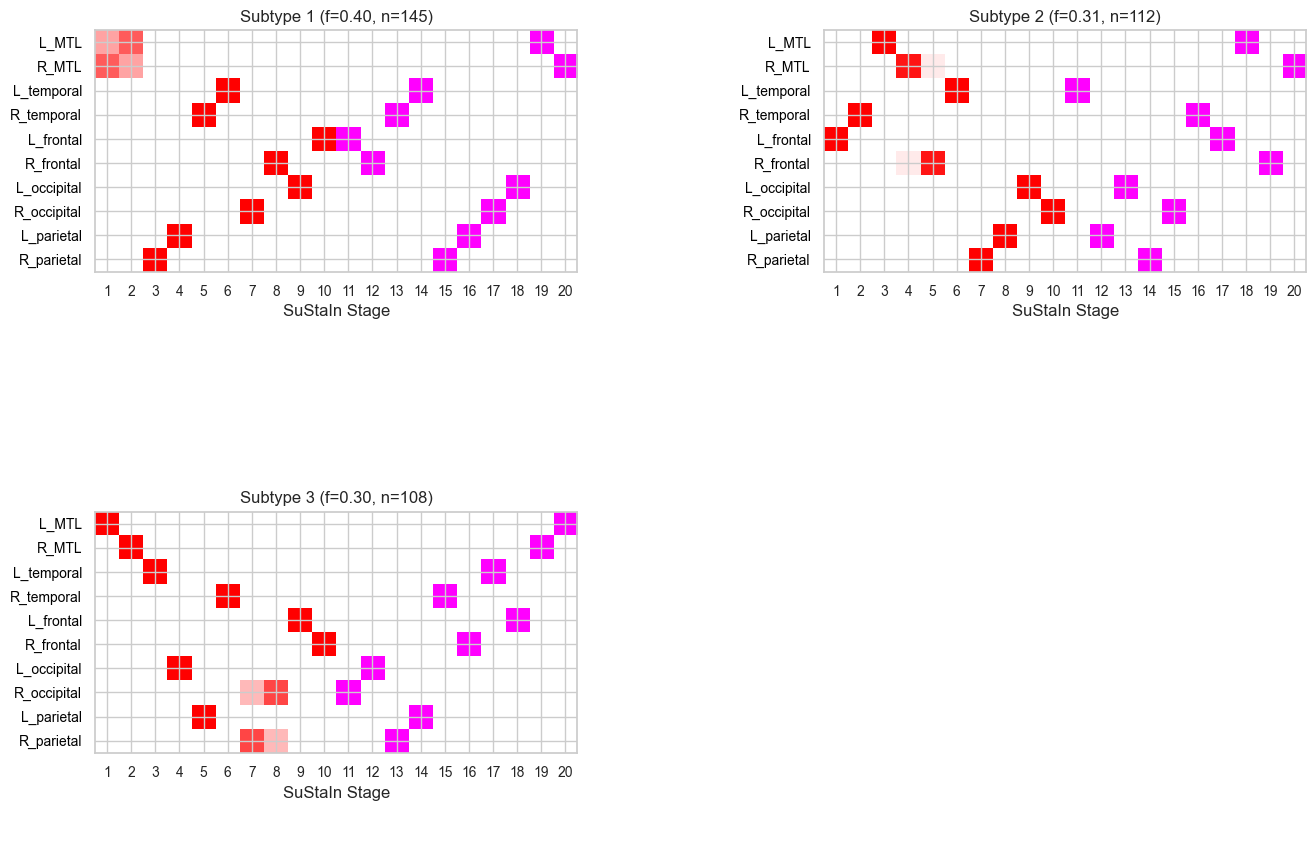

In [58]:
 
s = 2 # 1 split = 2 subtypes
M = len(zdata_eoad) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]
  
# use this information to plot the positional variance diagrams
figs, axs = pySuStaIn.ZscoreSustain._plot_sustain_model_fix(sustain_input,samples_sequence,samples_f,M,subtype_order=prevalence_order,
                                                       biomarker_labels=lobes,
                                                       #biomarker_colours=sns.color_palette('tab10'),
                                                       biomarker_order=range(10))

  
# Adjust figure size to prevent clustering of labels
try:
    for fig in figs:
        fig.set_size_inches(15, 10)  # Increase the size of each figure
except:
    figs.set_size_inches(15, 10)  # Increase the size of each figure


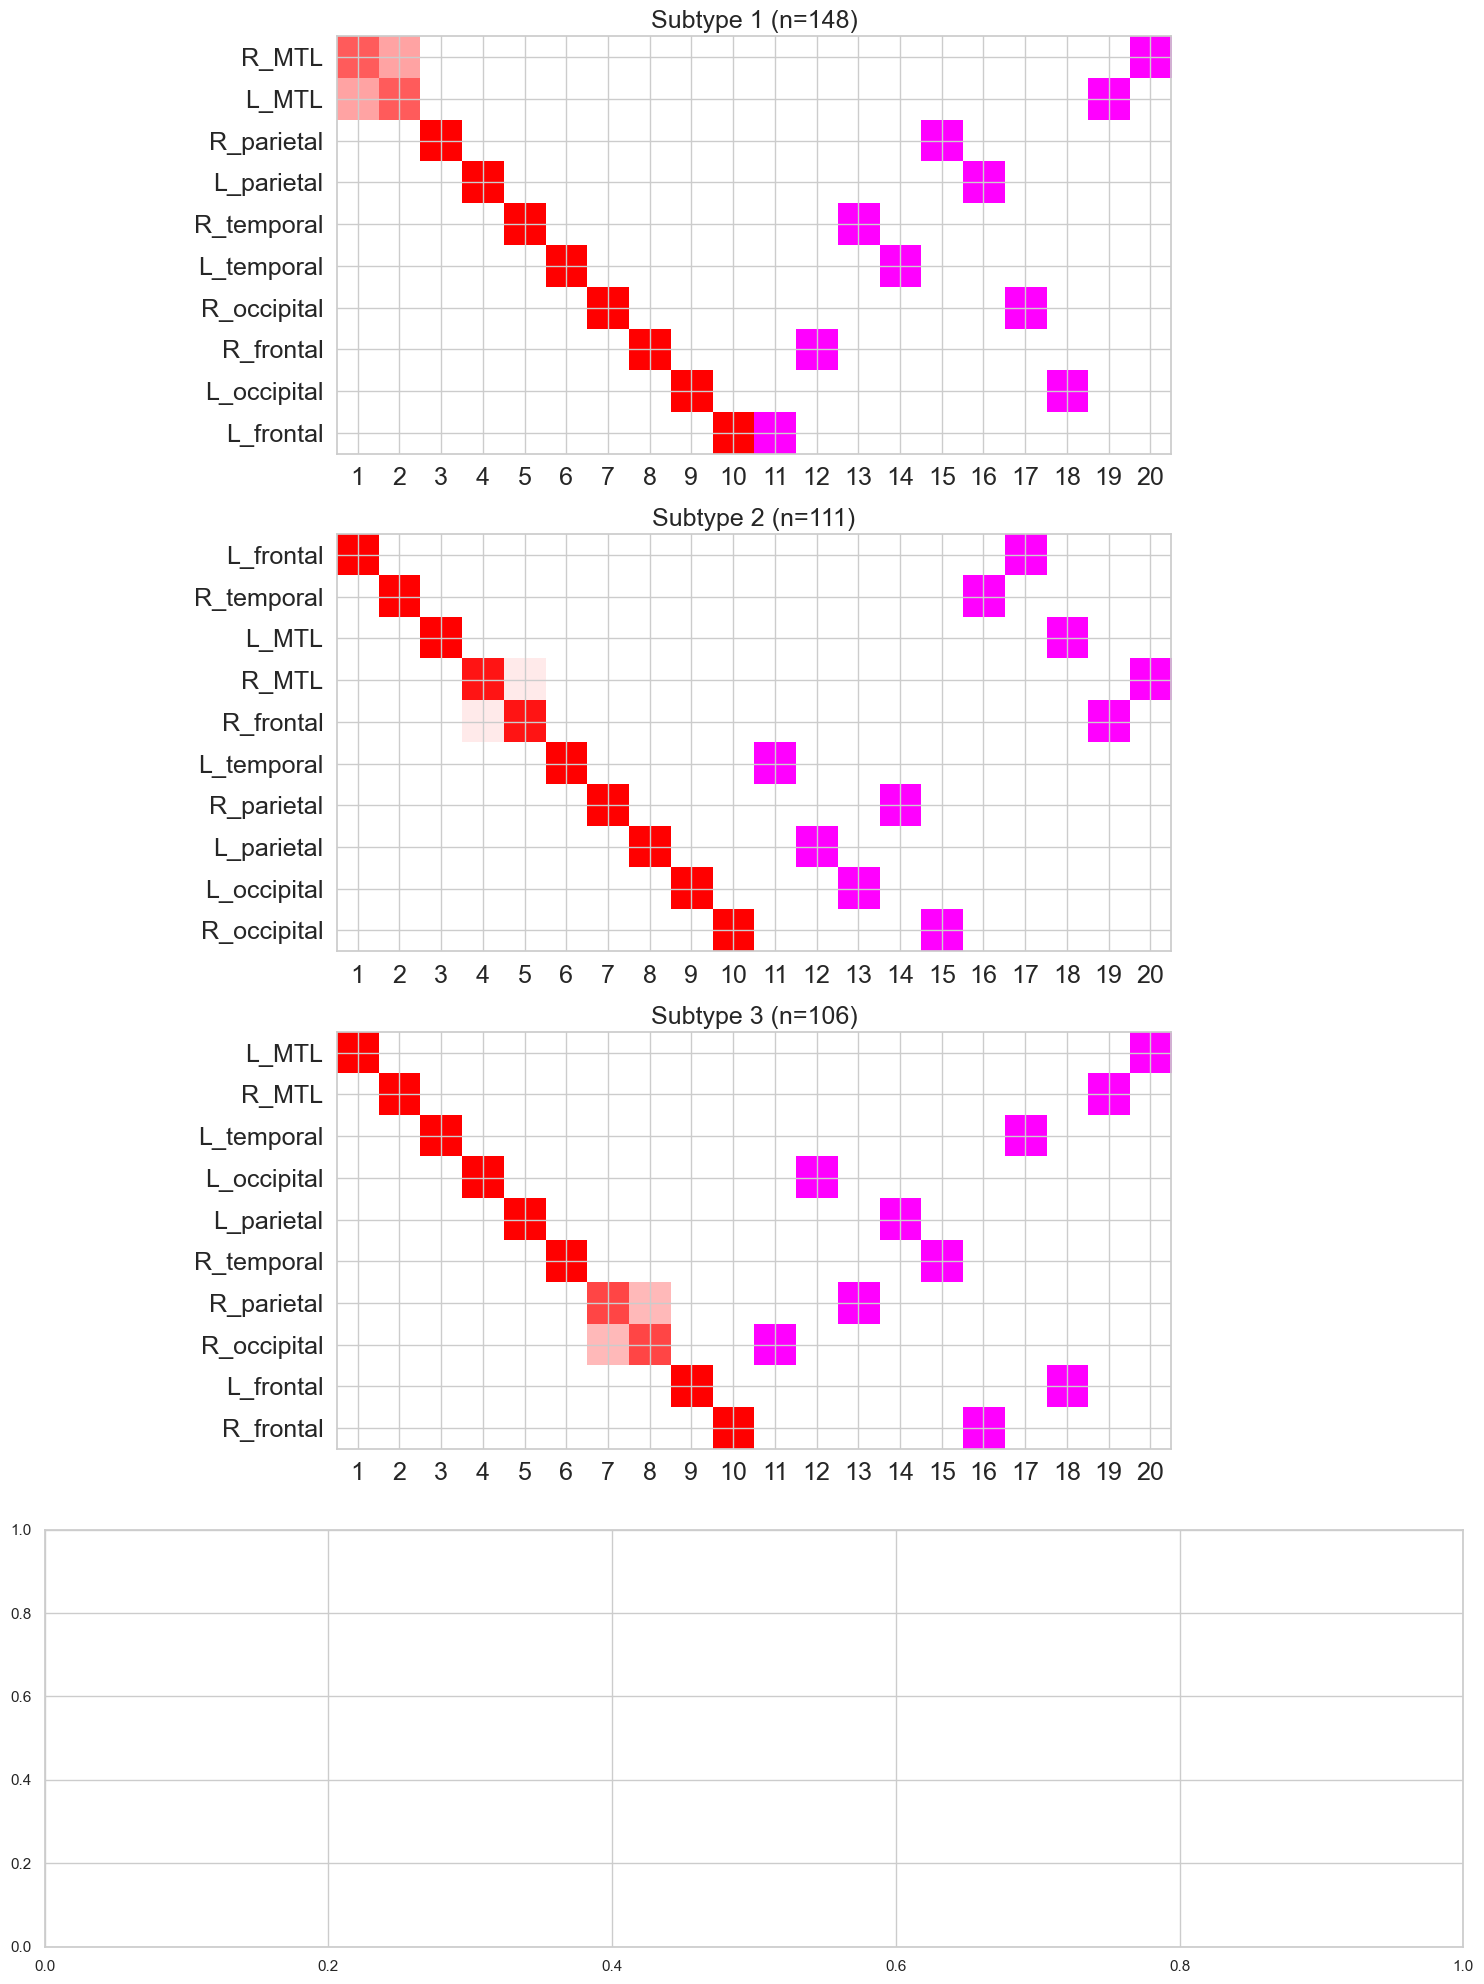

In [59]:
biomarker_orders =  [list(map(int, filter(lambda x: x < 10, arr))) for arr in raw_stage]
new_fig, new_axs = arrange_subplots_on_rows(fig, axs, biomarker_orders)
# Adjust layout to prevent overlapping
new_fig.tight_layout()
# Display all the new figures
plt.show(new_fig)


Fig. 5: Positional variance graph for each subtype. Red and magenta indicates crossing the lowest to highest threshold in an ROI, uncertainty indicated by blurriness of the square. Visualized as by the most prevalent subtype's event order, or each subtype's 

(Ignore: The raw count is inaccurate because it was derived from multiplying the total by a rounded percentage).

## event heatmap

most prevalent


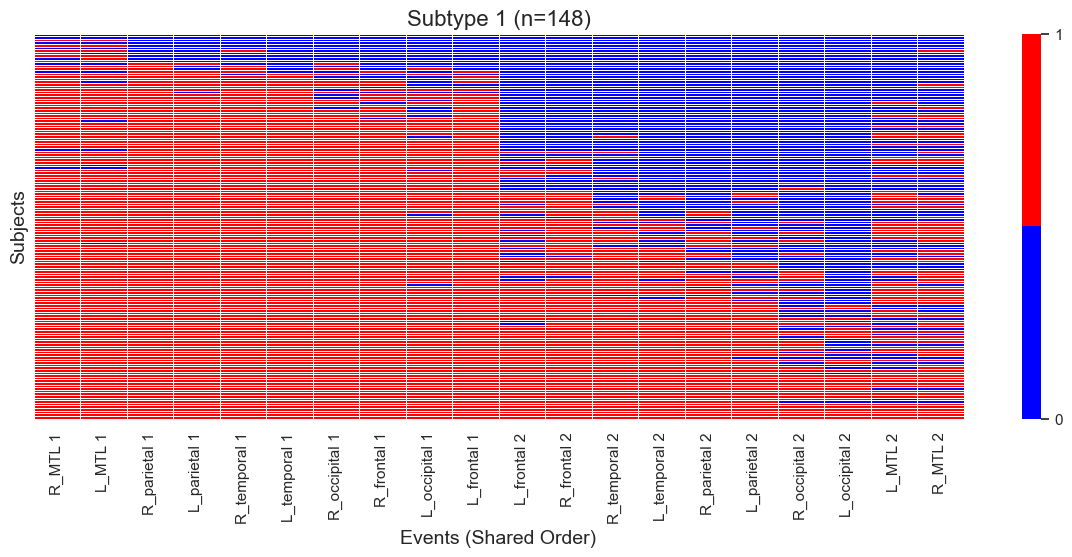

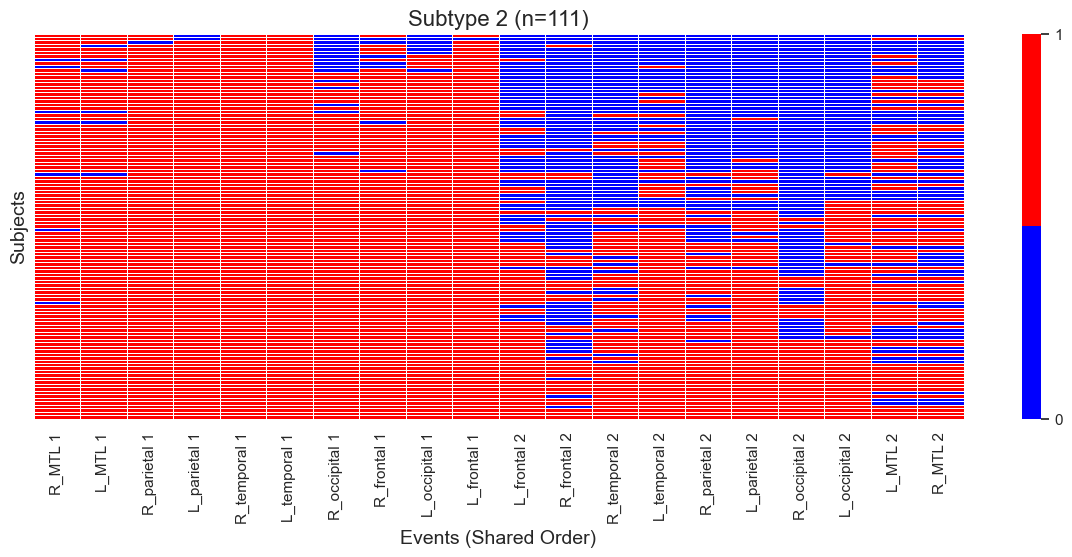

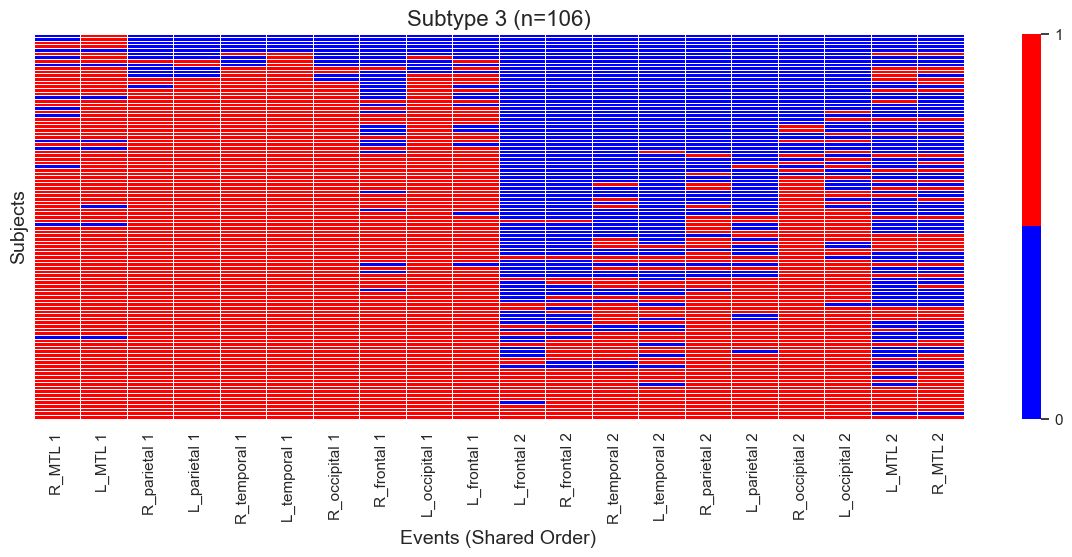

In [60]:
print('most prevalent')
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "red"], N=2)

# Translate raw stages to regional levels, accounting for regions with one level
def translate_raw_stage(seq, thresholds_dict, max_level_ct): 
    lobe_list = []
    level_list = []
    for i in range(max_level_ct):
        for lobe, thresholds in thresholds_dict.items():
            if len(thresholds) > i:  # Ensure there's at least one threshold
                lobe_list.append(lobe)  # Add the lobe to the lobe_list
                level_list.append(i+1)    # Add the index of the first item
    original_list = [f'{lobe_list[i]} {level_list[i]}' for i in range(len(lobe_list))]
    return [original_list[int(s)] for s in seq]


# Create thresholds dictionary from Z_vals
thresholds_dict = {
    lobes[i]: Z_vals[i, Z_vals[i] > 0].tolist()  # Exclude 0s, use only valid thresholds
    for i in range(len(lobes))
}

# Generate regional events for each subtype
regional_events_by_subtype = [
    translate_raw_stage(rs, thresholds_dict, max_level_ct) for rs in raw_stage
]

# Determine the event order for the most prevalent subtype
most_prevalent_subtype_index = 0#np.argmax(pk['samples_f'].mean(axis=1))  # Assuming `pk` contains prevalence data
reference_event_order = regional_events_by_subtype[most_prevalent_subtype_index]

# Sort all events based on the most prevalent subtype's event order
shared_event_order = {event: idx for idx, event in enumerate(reference_event_order)}

# Initialize a dictionary to store stage matrices by subtype
stage_matrices_by_subtype = {}

# Process each subtype's data
for subtype, events in enumerate(regional_events_by_subtype, start=1):
    # Align event indices with the shared x-axis order
    aligned_events = sorted(events, key=lambda event: shared_event_order[event])
    event_to_index = {event: i for i, event in enumerate(aligned_events)}

    subtype_subjects = df[df['ml_subtype'] == subtype]
    n_subjects = len(subtype_subjects)
    n_events = len(aligned_events)
    
    # Initialize the binary matrix for this subtype
    stage_matrix = np.zeros((n_subjects, n_events), dtype=int)
    
    # Determine fulfilled events for each subject in this subtype
    for subj_idx, (_, row) in enumerate(subtype_subjects.iterrows()):
        for lobe in lobes:
            z_score = row[lobe]
            thresholds = thresholds_dict.get(lobe, [float('inf')])  # Get thresholds for the current lobe

            # Iterate over thresholds dynamically
            for level, threshold in enumerate(thresholds, start=1):
                if z_score > threshold:  # Check if the threshold is fulfilled
                    # Construct the event name
                    event_name = f"{lobe} {level}"
                    if event_name in event_to_index:
                        stage_matrix[subj_idx, event_to_index[event_name]] = 1
    
    # Store the stage matrix and aligned events for this subtype
    stage_matrices_by_subtype[subtype] = (stage_matrix, aligned_events, subtype_subjects)

# Plot heatmaps for each subtype
for subtype, (stage_matrix, aligned_events, subtype_subjects) in stage_matrices_by_subtype.items():
    # Convert the matrix into a DataFrame with shared x-axis event order
    stage_df = pd.DataFrame(stage_matrix, columns=aligned_events)
    stage_df['ml_stage'] = subtype_subjects['ml_stage'].values
    
    # Sort by ml_stage for heatmap visualization
    stage_df_sorted = stage_df.sort_values(by='ml_stage').reset_index(drop=True)
    
    # Plot the heatmap
    plt.figure(figsize=(15, 5))
    
    ax = sns.heatmap(
        stage_df_sorted.iloc[:, :-1],  # Exclude ml_stage for the heatmap
        cmap=custom_cmap, cbar=True, yticklabels=False, linewidths=0.5
    )
    
    # Access and customize the colorbar
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1])  # Set tick positions
    colorbar.set_ticklabels(['0', '1'])  # Set tick labels
    
    #plt.title(f"Subtype {subtype} ({round(sorted_prevalence[subtype-1]*100, 3)}%)", fontsize=16)
    plt.title(f'Subtype {subtype} (n={prevalence.values[subtype-1]})',fontsize=16)
    plt.xlabel("Events (Shared Order)", fontsize=14)
    plt.ylabel("Subjects", fontsize=14)
    plt.show()


subtype-specific heatmap


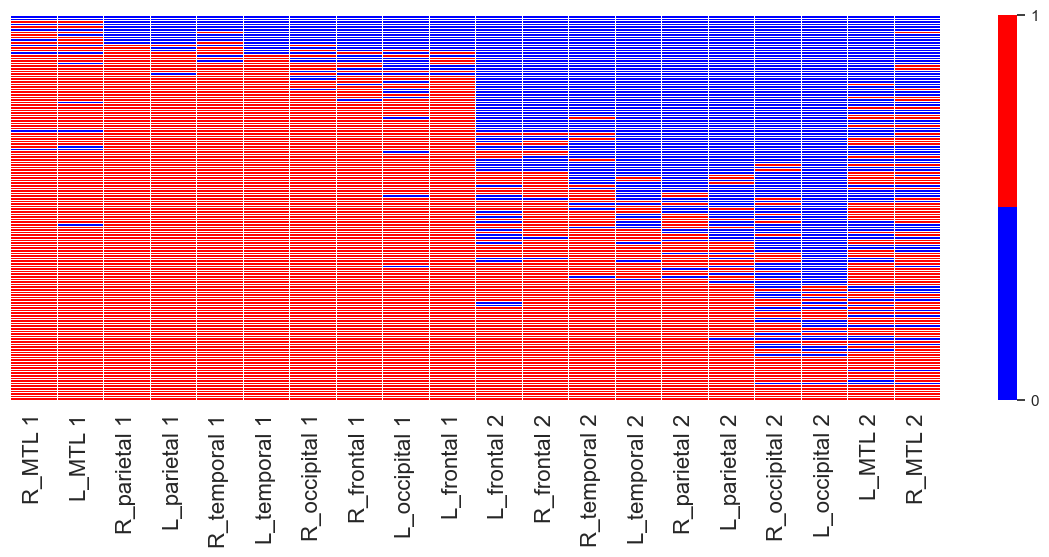

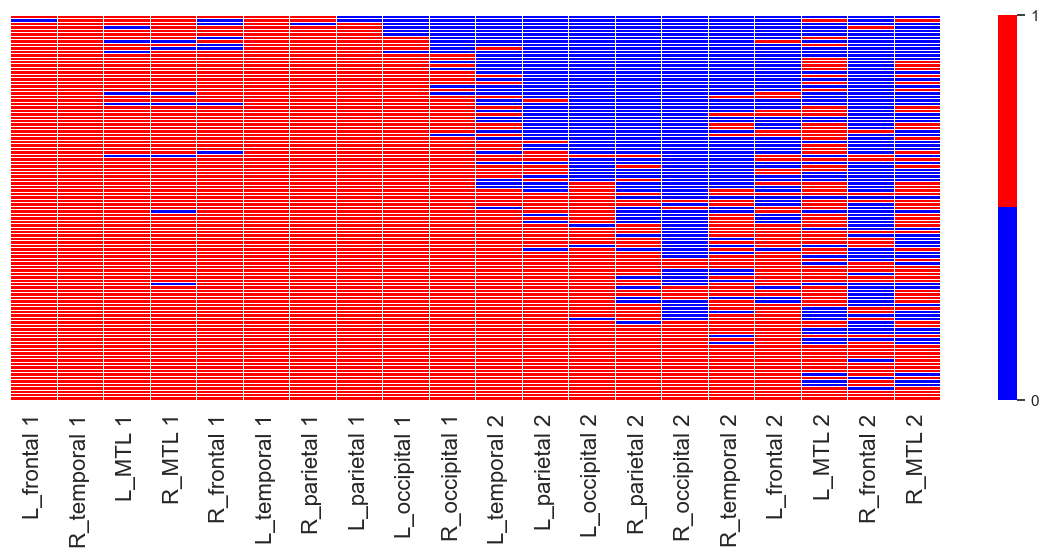

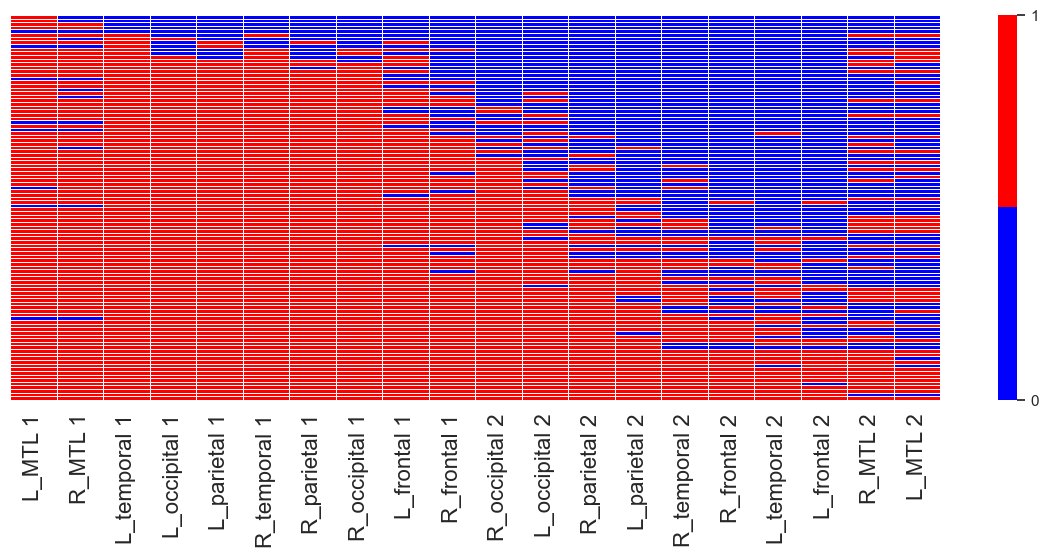

In [61]:
print('subtype-specific heatmap')
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "red"], N=2)

# Translate raw stages to regional levels, accounting for regions with one level
def translate_raw_stage(seq, thresholds_dict, max_level_ct): 
    lobe_list = []
    level_list = []
    for i in range(max_level_ct):
        for lobe, thresholds in thresholds_dict.items():
            if len(thresholds) > i:  # Ensure there's at least one threshold
                lobe_list.append(lobe)  # Add the lobe to the lobe_list
                level_list.append(i+1)    # Add the index of the first item
    original_list = [f'{lobe_list[i]} {level_list[i]}' for i in range(len(lobe_list))]
    return [original_list[int(s)] for s in seq]


# Create thresholds dictionary from Z_vals
thresholds_dict = {
    lobes[i]: Z_vals[i, Z_vals[i] > 0].tolist()  # Exclude 0s, use only valid thresholds
    for i in range(len(lobes))
}

# Generate regional events for each subtype
regional_events_by_subtype = [
    translate_raw_stage(rs, thresholds_dict, max_level_ct) for rs in raw_stage
]

# Initialize a dictionary to store stage matrices by subtype
stage_matrices_by_subtype = {}

# Process each subtype's data
for subtype, events in enumerate(regional_events_by_subtype, start=1):
    # Map subtype-specific events to indices
    event_to_index = {event: i for i, event in enumerate(events)}
    subtype_subjects = df[df['ml_subtype'] == subtype]
    n_subjects = len(subtype_subjects)
    n_events = len(events)
    
    # Initialize the binary matrix for this subtype
    stage_matrix = np.zeros((n_subjects, n_events), dtype=int)
    
    # Determine fulfilled events for each subject in this subtype
    for subj_idx, (_, row) in enumerate(subtype_subjects.iterrows()):
        for lobe in lobes:
            z_score = row[lobe]
            thresholds = thresholds_dict.get(lobe, [float('inf')])  # Get thresholds for the current lobe

            # Iterate over thresholds dynamically
            for level, threshold in enumerate(thresholds, start=1):
                if z_score > threshold:  # Check if the threshold is fulfilled
                    # Construct the event name
                    event_name = f"{lobe} {level}"
                    if event_name in event_to_index:
                        stage_matrix[subj_idx, event_to_index[event_name]] = 1
    
    # Store the stage matrix and events for this subtype
    stage_matrices_by_subtype[subtype] = (stage_matrix, events, subtype_subjects)

# Plot heatmaps for each subtype
for subtype, (stage_matrix, events, subtype_subjects) in stage_matrices_by_subtype.items():
    # Convert the matrix into a DataFrame with subtype-specific event order
    stage_df = pd.DataFrame(stage_matrix, columns=events)
    stage_df['ml_stage'] = subtype_subjects['ml_stage'].values
    
    # Sort by ml_stage for heatmap visualization
    stage_df_sorted = stage_df.sort_values(by='ml_stage').reset_index(drop=True)
    
    # Plot the heatmap
    plt.figure(figsize=(15, 5))
    
    ax = sns.heatmap(
        stage_df_sorted.iloc[:, :-1],  # Exclude ml_stage for the heatmap
        cmap=custom_cmap, cbar=True, yticklabels=False, linewidths=0.5
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    # Access and customize the colorbar
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1])  # Set tick positions
    colorbar.set_ticklabels(['0', '1'])  # Set tick labels
    
    #plt.title(f"Subtype {subtype} ({round(sorted_prevalence[subtype-1]*100, 3)}%)", fontsize=16)
    plt.title('',fontsize=16)#'Subtype {subtype} (n={prevalence.values[subtype-1]})'
    plt.xlabel("", fontsize=14)#Events
    plt.ylabel("", fontsize=14)#Subjects
    plt.show()
 

Fig. 6: Event heatmap showing the event progression for subjects in each subtype, based on the event ordering of the most prevalent subtype (top); and the event ordering of each subtype (bottom). Red indicates that a particular event is fulfilled = the z-score in that ROI has surpassed a specific threshold; blue indicates unfulfilled. The rows are ordered from top to bottom by patient stage assignments from low to high, the columns are ordered from left to right by events from early to late (low stage to high stage).  Visuzliaed as by most prevalent subtype's event sequence, or each subtype's 

## imperfection box 


In [62]:
from scipy.stats import t

avg_imperfection_by_subtype = {}
std_imperfection_by_subtype = {}
ci_imperfection_by_subtype = {}
all_imperfections = []

for subtype, (stage_matrix, events, subtype_subjects) in stage_matrices_by_subtype.items():
    stage_df = pd.DataFrame(stage_matrix, columns=events)
    stage_df['ml_stage'] = subtype_subjects['ml_stage'].values
    stage_df_sorted = stage_df.sort_values(by='ml_stage').reset_index(drop=True)

    imperfection_counts = []

    for _, row in stage_df_sorted.iterrows():
        subject_stage = int(row['ml_stage'])
        binary_values = row.iloc[:-1].values
        left_imperfections = np.sum(binary_values[:subject_stage] == 0)
        right_imperfections = np.sum(binary_values[subject_stage:] == 1)
        total_imperfections = left_imperfections + right_imperfections
        imperfection_counts.append(total_imperfections)
        all_imperfections.append(total_imperfections)

    n = len(imperfection_counts)
    mean = np.mean(imperfection_counts)
    std = np.std(imperfection_counts, ddof=1)
    se = std / np.sqrt(n)
    t_val = t.ppf(0.975, df=n-1)
    ci_low, ci_high = mean - t_val * se, mean + t_val * se

    avg_imperfection_by_subtype[subtype] = mean
    std_imperfection_by_subtype[subtype] = std
    ci_imperfection_by_subtype[subtype] = (ci_low, ci_high)

# Print subtype results
print("Subtype Imperfection Counts (Mean ± SD, 95% CI):")
for subtype in avg_imperfection_by_subtype:
    mean = avg_imperfection_by_subtype[subtype]
    std = std_imperfection_by_subtype[subtype]
    ci_low, ci_high = ci_imperfection_by_subtype[subtype]
    print(f"Subtype {subtype}: {mean:.2f} ± {std:.2f}, 95% CI [{ci_low:.2f}, {ci_high:.2f}]")

# Overall stats
n_all = len(all_imperfections)
mean_all = np.mean(all_imperfections)
std_all = np.std(all_imperfections, ddof=1)
se_all = std_all / np.sqrt(n_all)
t_val_all = t.ppf(0.975, df=n_all-1)
ci_low_all, ci_high_all = mean_all - t_val_all * se_all, mean_all + t_val_all * se_all

print(f"\nOverall: {mean_all:.2f} ± {std_all:.2f}, 95% CI [{ci_low_all:.2f}, {ci_high_all:.2f}]")


Subtype Imperfection Counts (Mean ± SD, 95% CI):
Subtype 1: 2.61 ± 1.40, 95% CI [2.39, 2.84]
Subtype 2: 3.08 ± 1.59, 95% CI [2.78, 3.38]
Subtype 3: 2.67 ± 1.54, 95% CI [2.37, 2.97]

Overall: 2.77 ± 1.51, 95% CI [2.62, 2.93]



ANOVA F-statistic: 3.4134, p-value: 0.0340
Result: Statistically significant differences across subtypes.

Post-hoc Pairwise Comparisons (Tukey HSD):
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.4662 0.0366  0.0229 0.9095   True
     1      3   0.0549 0.9554 -0.3943 0.5042  False
     2      3  -0.4113 0.1092 -0.8908 0.0682  False
---------------------------------------------------


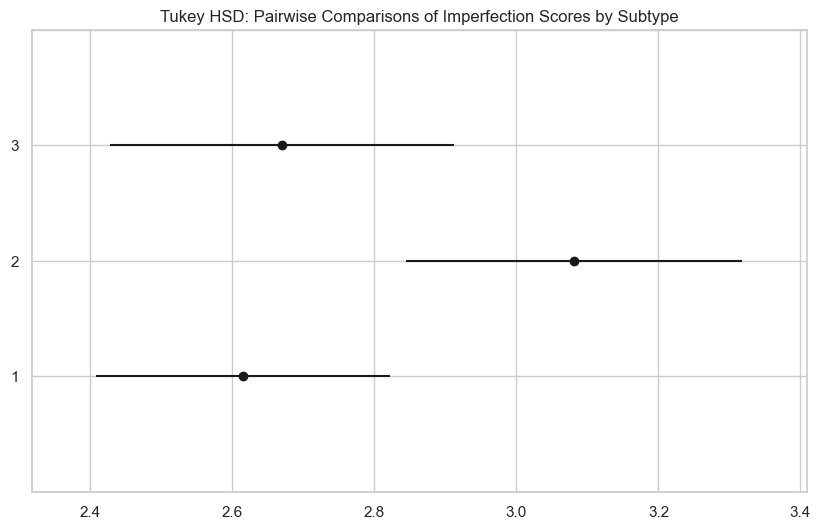

In [63]:
from scipy.stats import f_oneway

# Prepare data for ANOVA
imperfection_lists = []  # List of imperfection scores for each subtype
for subtype, (stage_matrix, events, subtype_subjects) in stage_matrices_by_subtype.items():
    stage_df = pd.DataFrame(stage_matrix, columns=events)
    stage_df['ml_stage'] = subtype_subjects['ml_stage'].values
    stage_df_sorted = stage_df.sort_values(by='ml_stage').reset_index(drop=True)

    imperfection_counts = []
    for _, row in stage_df_sorted.iterrows():
        subject_stage = int(row['ml_stage'])
        binary_values = row.iloc[:-1].values
        left_imperfections = np.sum(binary_values[:subject_stage] == 0)
        right_imperfections = np.sum(binary_values[subject_stage:] == 1)
        total_imperfections = left_imperfections + right_imperfections
        imperfection_counts.append(total_imperfections)
    
    imperfection_lists.append(imperfection_counts)

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*imperfection_lists)
print(f"\nANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: Statistically significant differences across subtypes.")
else:
    print("Result: No statistically significant differences across subtypes.")
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Create flat data for Tukey HSD
imperfection_scores = []
subtype_labels = []

for subtype, (stage_matrix, events, subtype_subjects) in stage_matrices_by_subtype.items():
    stage_df = pd.DataFrame(stage_matrix, columns=events)
    stage_df['ml_stage'] = subtype_subjects['ml_stage'].values
    stage_df_sorted = stage_df.sort_values(by='ml_stage').reset_index(drop=True)

    for _, row in stage_df_sorted.iterrows():
        subject_stage = int(row['ml_stage'])
        binary_values = row.iloc[:-1].values
        left_imperfections = np.sum(binary_values[:subject_stage] == 0)
        right_imperfections = np.sum(binary_values[subject_stage:] == 1)
        total_imperfections = left_imperfections + right_imperfections

        imperfection_scores.append(total_imperfections)
        subtype_labels.append(subtype)

# Create a DataFrame for clarity
df_tukey = pd.DataFrame({
    'Imperfection_Score': imperfection_scores,
    'Subtype': subtype_labels
})

# Perform Tukey HSD test
tukey = pairwise_tukeyhsd(
    endog=df_tukey['Imperfection_Score'],
    groups=df_tukey['Subtype'],
    alpha=0.05
)

print("\nPost-hoc Pairwise Comparisons (Tukey HSD):")
print(tukey.summary())

# Optionally, you can also plot the confidence intervals
import matplotlib.pyplot as plt
tukey.plot_simultaneous()
plt.title("Tukey HSD: Pairwise Comparisons of Imperfection Scores by Subtype")
plt.show()


In [64]:
k = len(imperfection_lists)   # number of subtypes
n_total = sum(len(lst) for lst in imperfection_lists)

df_between = k - 1
df_within = n_total - k

print(f"Degrees of freedom for F-statistic: df_between={df_between}, df_within={df_within}")


Degrees of freedom for F-statistic: df_between=2, df_within=362


In [65]:
# Store per-region imperfection data
region_imperfection_by_subtype = {}

for subtype, (stage_matrix, events, subtype_subjects) in stage_matrices_by_subtype.items():
    stage_df = pd.DataFrame(stage_matrix, columns=events)
    stage_df['ml_stage'] = subtype_subjects['ml_stage'].values

    n_subjects = stage_df.shape[0]
    n_events = len(events)

    # Initialize array to hold imperfection count per region/event
    region_imperfections = np.zeros(n_events, dtype=int)

    for _, row in stage_df.iterrows():
        subj_stage = int(row['ml_stage'])
        binary_vals = row.iloc[:-1].values  # exclude ml_stage

        for i in range(n_events):
            val = binary_vals[i]
            if subj_stage > i and val == 0:
                region_imperfections[i] += 1  # Expected 1, but got 0
            elif subj_stage <= i and val == 1:
                region_imperfections[i] += 1  # Expected 0, but got 1

    region_imperfection_by_subtype[subtype] = {
        'events': events,
        'counts': region_imperfections,
        'percent': region_imperfections / n_subjects * 100
    }

# Example: print summary
for subtype, data in region_imperfection_by_subtype.items():
    print(f"\nSubtype {subtype} Region Imperfections:")
    for event, count, pct in zip(data['events'], data['counts'], data['percent']):
        print(f"{event}: {count} subjects ({pct:.1f}%)")



Subtype 1 Region Imperfections:
R_MTL 1: 7 subjects (4.7%)
L_MTL 1: 11 subjects (7.4%)
R_parietal 1: 1 subjects (0.7%)
L_parietal 1: 3 subjects (2.0%)
R_temporal 1: 7 subjects (4.7%)
L_temporal 1: 3 subjects (2.0%)
R_occipital 1: 9 subjects (6.1%)
R_frontal 1: 6 subjects (4.1%)
L_occipital 1: 12 subjects (8.1%)
L_frontal 1: 17 subjects (11.5%)
L_frontal 2: 24 subjects (16.2%)
R_frontal 2: 8 subjects (5.4%)
R_temporal 2: 13 subjects (8.8%)
L_temporal 2: 15 subjects (10.1%)
R_parietal 2: 24 subjects (16.2%)
L_parietal 2: 30 subjects (20.3%)
R_occipital 2: 28 subjects (18.9%)
L_occipital 2: 24 subjects (16.2%)
L_MTL 2: 66 subjects (44.6%)
R_MTL 2: 79 subjects (53.4%)

Subtype 2 Region Imperfections:
L_frontal 1: 1 subjects (0.9%)
R_temporal 1: 0 subjects (0.0%)
L_MTL 1: 6 subjects (5.4%)
R_MTL 1: 7 subjects (6.3%)
R_frontal 1: 8 subjects (7.2%)
L_temporal 1: 1 subjects (0.9%)
R_parietal 1: 3 subjects (2.7%)
L_parietal 1: 1 subjects (0.9%)
L_occipital 1: 1 subjects (0.9%)
R_occipital 1: 5

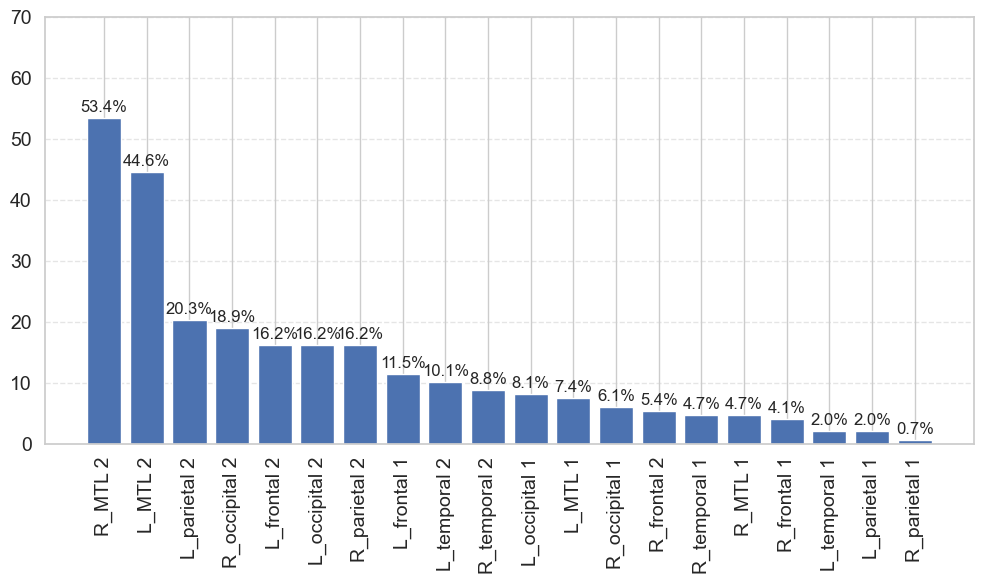

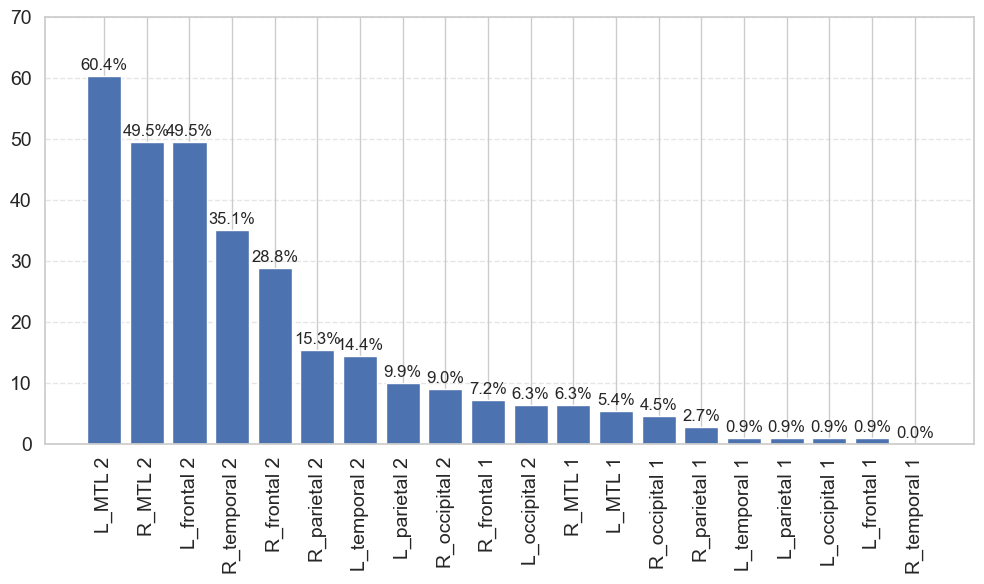

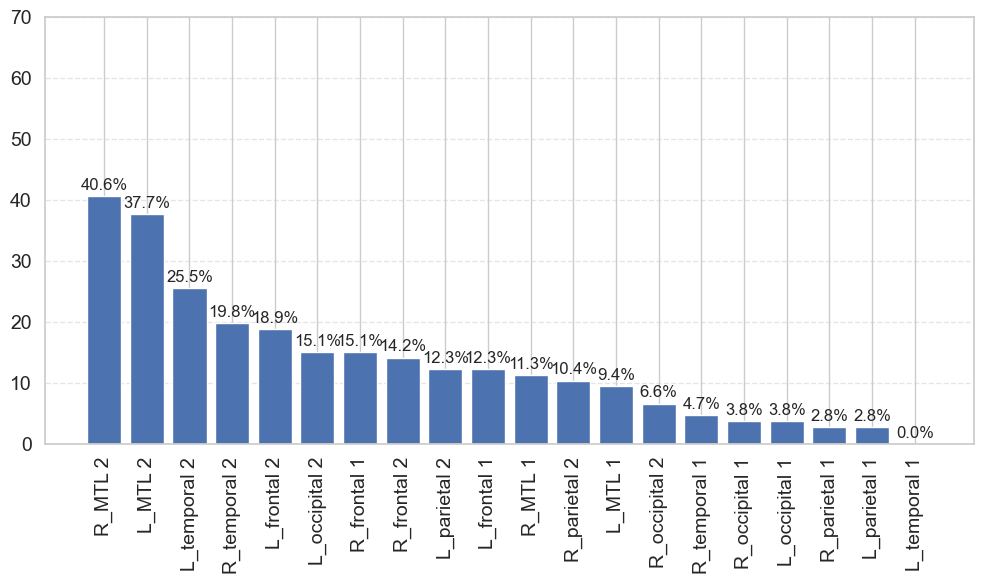

In [66]:
for subtype, data in region_imperfection_by_subtype.items():
    # Unpack and sort by percentage
    events = np.array(data['events'])
    counts = np.array(data['counts'])
    percents = np.array(data['percent'])

    sorted_indices = np.argsort(percents)[::-1]  # Descending sort
    sorted_events = events[sorted_indices]
    sorted_percents = percents[sorted_indices]

    # Plot
    plt.figure(figsize=(10, 6))  # Less wide
    bars = plt.bar(range(len(sorted_events)), sorted_percents)

    # Annotate each bar with percentage
    for i, p in enumerate(sorted_percents):
        plt.text(i, p + 0.5, f"{p:.1f}%", ha='center', va='bottom', fontsize=12)  # Bigger annotation

    plt.xticks(ticks=range(len(sorted_events)), labels=sorted_events, rotation=90, fontsize=14)  # Bigger tick labels
    plt.ylim(0, 70)  # Give space for text annotations
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.yticks(fontsize=14)  # Bigger y-ticks
    plt.tight_layout()
    plt.show()


Fig. 6 add: Regional imperfection 

# Baseline

## subtype and stage all scans + additional variables

In [299]:
warnings.filterwarnings("ignore")
# subtype and stage all scans
new_df = zdata_full[zdata_full.dx == 'EOAD']
typedf = new_df[['subj','visit','ftp_date']]
typedf1 = typedf[typedf.visit==1].copy()
typedf2 = typedf[typedf.visit!=1].copy()
for i in range(1, N_S_max): #i is the number of split, so starting from 1 split = 2 subtypes
    ##Subtype assignment
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(i) + '.pickle'
    pk = pd.read_pickle(pickle_filename_s) 
    subtypes = pk['ml_subtype']
    stages = pk['ml_stage']
    styp_prob = pk['prob_ml_subtype']
    #subtypes = [subtypes[i] if  styp_prob[i] >= 0.5 else 98 for i in range(len(subtypes))]
    typedf1[str(i+1)] = subtypes
    # Add 1 to the subtype (assuming it's indexed from 0 in original)
    typedf1[str(i+1)] = typedf1[str(i+1)].astype(int) + 1
    # Assign the ml_stage
    stage = str(i+1) + 's'
    typedf1[stage] = stages
    typedf1[stage] = typedf1[stage].astype(int) 
    subtype_prob_name = f'{str(i+1)}_subtype_prob'
    typedf1[subtype_prob_name] = pk['prob_ml_subtype']
    stage_prob_name = f'{str(i+1)}_stage_prob'
    typedf1[stage_prob_name] = pk['prob_ml_stage']

    
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(i) + '.pickle'
    pk = pd.read_pickle(pickle_filename_s)
    new_dat = new_df[new_df.visit!=1][lobes].values
    s_seq = pk['samples_sequence']
    s_f = pk['samples_f']
    n_s = len(new_df) - 365
    ml_subtype, prob_ml_subtype, ml_stage, prob_ml_stage, prob_subtype, prob_stage, prob_subtype_stage = \
        pySuStaIn.ZscoreSustain.subtype_and_stage_individuals_newData(sustain_input, data_new = new_dat, 
    samples_sequence = s_seq, samples_f = s_f , N_samples = n_s)
    # if the probability is smaller than 0.5, poorly fit
    subtypes = ml_subtype#[ml_subtype[i] if prob_ml_subtype[i] >= 0.5 else 98 for i in range(len(ml_subtype))]
    typedf2[str(i+1)] = subtypes
    # Add 1 to the subtype (assuming it's indexed from 0 in original)
    typedf2[str(i+1)] = typedf2[str(i+1)].astype(int) + 1
    # Assign the ml_stage
    stage = str(i+1) + 's'
    typedf2[stage] = ml_stage
    typedf2[stage] = typedf2[stage].astype(int) 
    subtype_prob_name = f'{str(i+1)}_subtype_prob'
    typedf2[subtype_prob_name] = prob_ml_subtype
    stage_prob_name = f'{str(i+1)}_stage_prob'
    typedf2[stage_prob_name] = prob_ml_stage
typedf = pd.concat([typedf1,typedf2],axis=0,ignore_index=True)
typedf['fname'] = typedf.apply(lambda row:f"wr{row['subj']}_FTP_{row['ftp_date']}_suvr-infcblgm.nii",axis=1)

In [300]:
# set those with poor model fit to subtype '99'
typedf99 = typedf.copy()
for n_clusters in range(2, 7):
    prob_col = f"{n_clusters}_subtype_prob"
    subtype_col = f"{n_clusters}"
    typedf99.loc[typedf99[prob_col] < 0.5, subtype_col] = 99

In [301]:
#save baseline and full assignment for matlab modeling
#typedf99[typedf99.visit==1].to_csv(data_path+'final_inter_c2mean_2_bl_ss.csv',index=False)\
#typedf99 = pd.read_csv(data_path+'ss_assignment/final_inter_c2mean_2_full_ss.csv')

In [303]:
ss3 = pd.read_csv(data_path+'ss_assignment/final_inter_c2mean_2_full_ss.csv') 
ss3 = ss3[['subj', 'visit', 'ftp_date', '3', '3s', '3_subtype_prob', '3_stage_prob', 'fname']]
ss3.columns = ['subj', 'visit', 'ftp_date', 'subtype', 'stage', 'subtype_prob', 'stage_prob', 'fname']
ss3['subtype'] = ss3['subtype'].astype(int)
ss3['stage'] = ss3['stage'].astype(int)
# existing dataframe with other variables
data = pd.read_csv(data_path + 'full_combined.csv')  # Convert ftp_date to datetime in both DataFrames
data['ftp_date'] = pd.to_datetime(data['ftp_date'], errors='coerce')
ss3['ftp_date'] = pd.to_datetime(ss3['ftp_date'], errors='coerce')
combined = pd.merge(data, ss3, on=['subj', 'ftp_date'], how='right')
combined = combined.sort_values(by=['subj', 'ftp_date']).reset_index(drop=True)
combined['visit'] = combined.groupby('subj').cumcount() + 1
#subtype_mapping = {old: new for new, old in enumerate(prevalence.index, start=1)}
#ombined['subtype'] = combined['subtype'].map(subtype_mapping)
combined['poorly'] = combined['subtype_prob'] < 0.5
combined_bl = combined[combined['visit']==1]
prevalence = combined_bl['subtype'].value_counts().sort_values(ascending=False)
# for the baseline df, filter out those scans with poor model fit, and output count
combined_exclude = combined_bl[~combined_bl.poorly]
print('baseline prevalence')
print(combined_exclude.subtype.value_counts())
print(f'total scans (after exclude poor fit): {len(combined)}')
print('variables:')
print(combined.columns)


baseline prevalence
subtype
1    144
2    111
3    104
Name: count, dtype: int64
total scans (after exclude poor fit): 699
variables:
Index(['subj', 'fbb_date', 'amy_file', 'ftp_file', 'ftp_date', 'event',
       'SUVR Frontal', 'SUVR MesialTemporal', 'SUVR MetaTemporal',
       'SUVR TemporoParietal', 'SUVR Universal', 'SUVR PET-Only Composite',
       'SUVR MRI-Based Composite', 'Centiloids MRI-Based Composite', 'Gender',
       'Yrs. of Education', 'Age', 'Diagnosis', 'CDR-SB', 'CDR-Global', 'MMSE',
       'Total 13', 'ApoE4', 'ApoE4 Carrier', 'ApoE4 Genotype',
       'Delayed Recall', 'Digit Total', 'Cognitive Behavior', 'Language CI',
       'Attention CI', 'Executive CI', 'Visuospatial CI', 'Memory CI', 'L_MTL',
       'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal',
       'L_occipital', 'R_occipital', 'L_parietal', 'R_parietal', 'L_MTL_z',
       'R_MTL_z', 'L_temporal_z', 'R_temporal_z', 'L_frontal_z', 'R_frontal_z',
       'L_occipital_z', 'R_occipital_z', 'L_pa

## average image

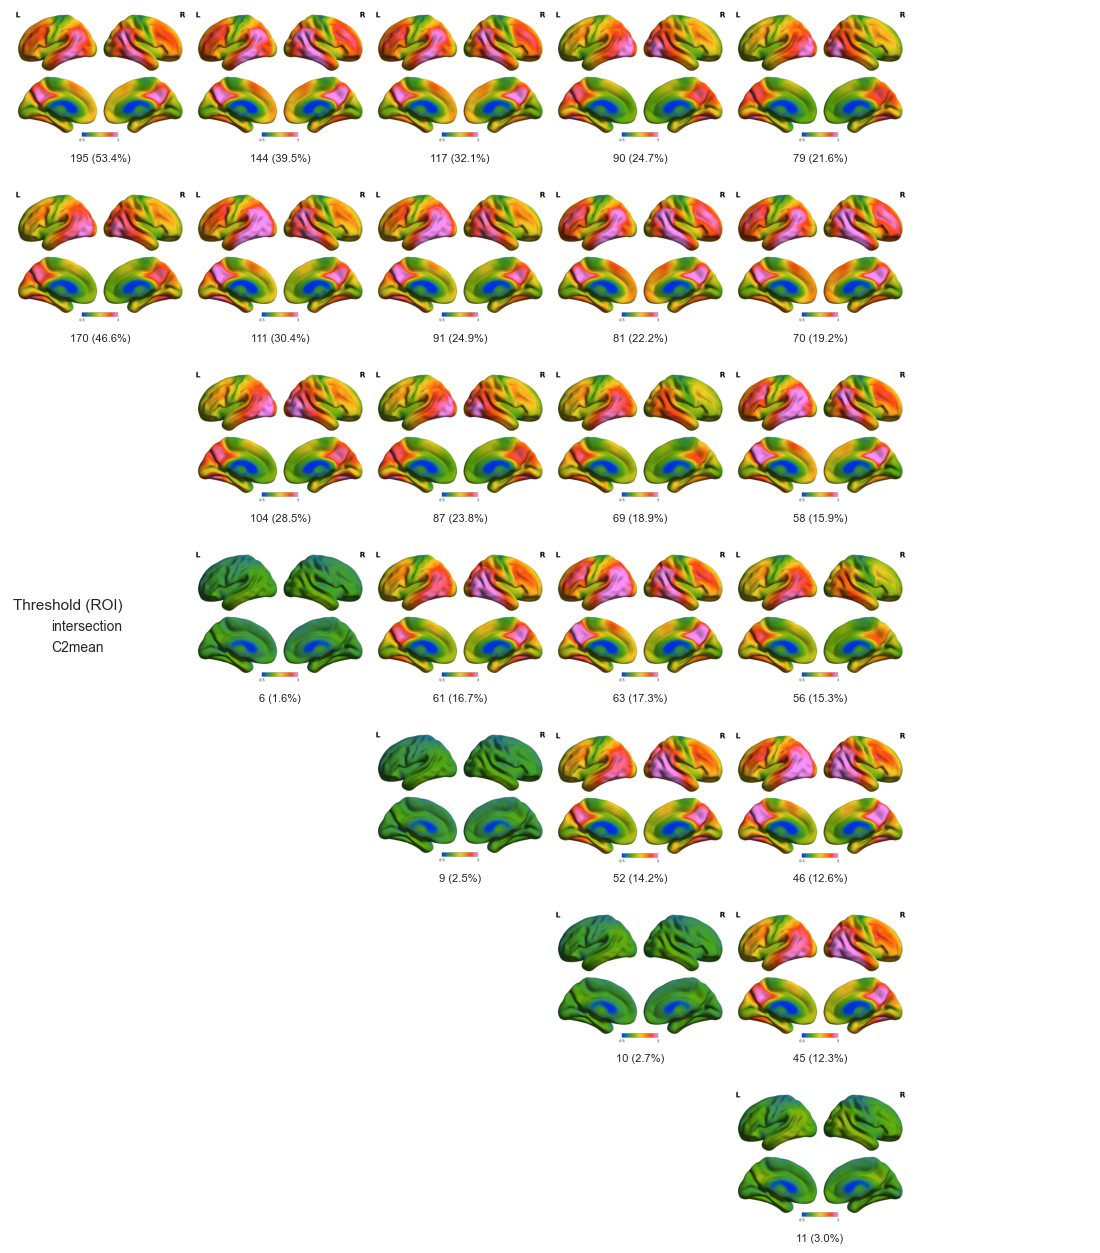

In [287]:
# configuration
img_path = '/Users/linlin/Desktop/brain stuff/graphs/'#'/Users/linlin/Desktop/brain stuff/data/'
type = 'ROI:intersection-C2mean'# threshold type
img_folder = img_path+'inter_c2mean/rainbows'# mean img folder 
typedf_subset = typedf99[typedf99.visit==1][['subj',  '2', '3', '4', '5', '6']] 
def plot_brain_grid(typedf, img_folder, type):
    

    # Set up the figure size dynamically based on grid size
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.axis('off')
    n_splits = range(2, 7)  # Columns 2 to 6 for clusters

    # Grid positioning
    for idx, n_clusters in enumerate(n_splits):
        col_name = str(n_clusters)  # e.g., '2', '3', '4', etc.
        subtype_counts = typedf[col_name].value_counts().sort_values(ascending=False)
        
        # Load and plot images based on sorted order
        for i, (cluster, count) in enumerate(subtype_counts.items()):
            percentage = round((count / len(typedf)) * 100, 1)
            image_name = f"brainnet_mean_x{n_clusters}_s{cluster}.jpg"#
            image_path = os.path.join(img_folder, image_name)
            
            if os.path.exists(image_path):
                img = mpimg.imread(image_path)
                ax_image = fig.add_axes([0.15 * idx, 0.85 - i * 0.15, 0.15, 0.15])  # Adjust position
                ax_image.imshow(img)
                ax_image.axis('off')
                
                # Add annotation
                ax_image.text(
                    0.5, -0.1, f"{count} ({percentage}%)", 
                    transform=ax_image.transAxes, ha='center', va='center', fontsize=8
                )
            else:
                print(f"Image not found: {image_path}")

    # Parse 'type' string to create legend entries
    type_items = type.split(':')[-1].split('-')  # Extract items after ':' and split by '-'
    legend_labels = type_items

    # Create dummy patches for the legend
    legend_handles = [
        mpatches.Patch(color='none', label=label) for label in legend_labels
    ]
    
    # Add legend to the lower left corner
    fig.legend(
        handles=legend_handles, 
        title='Threshold (ROI)', loc='center left', fontsize=10, title_fontsize=11,
        frameon=False
    )

    plt.show()

# Execute
plot_brain_grid(typedf_subset, img_folder, type)  

READ IN COLUMN ORDER. 2 SUBTYPES IS FIRST COLUMN...

## image and comparison

1
2
3


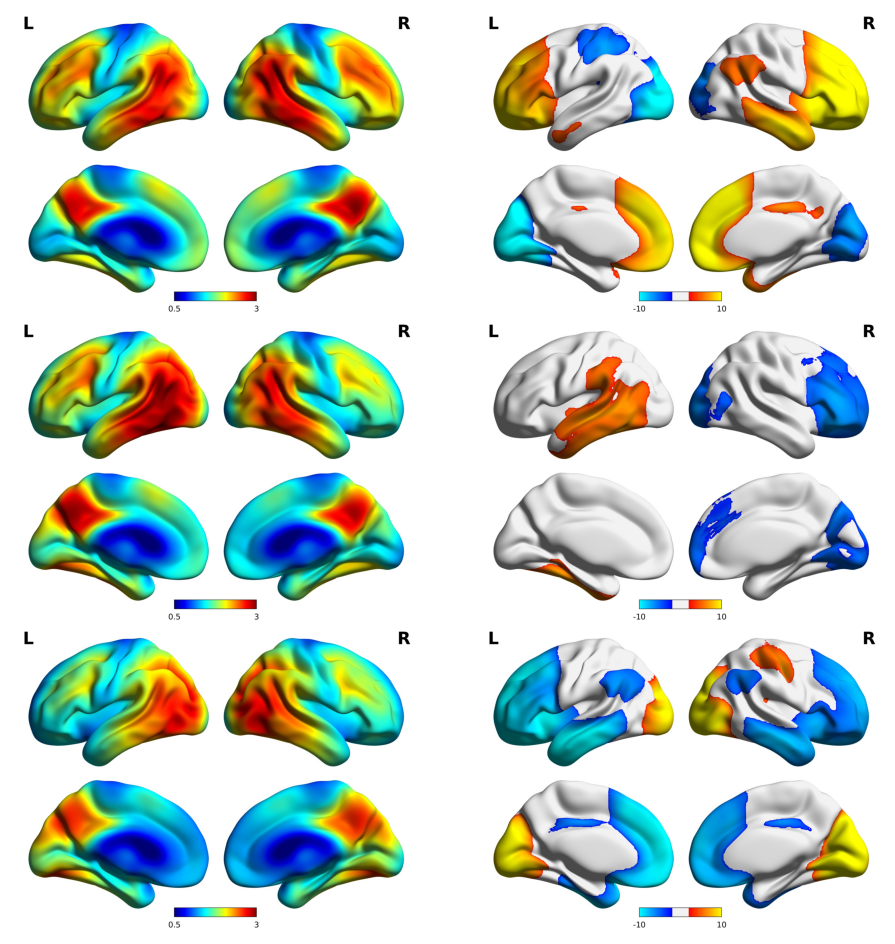

In [523]:


# Configuration
img_path = '/Users/linlin/Desktop/brain stuff/graphs/'
type = 'ROI:intersection-C2mean'
avg_folder = img_path + 'inter_c2mean/'
contrast_folder = img_path + 'contrast/'
n_clusters = 3

# Set up the figure dynamically based on the number of clusters
fig, axes = plt.subplots(n_clusters, 2, figsize=(12, 4 * n_clusters))
plt.subplots_adjust(wspace=0, hspace=0)  # Remove spacing between images

# Get subtype counts
col_name = str(n_clusters)
subtype_counts = typedf[typedf.visit==1][col_name].value_counts().sort_values(ascending=False)

# Loop through each cluster and load images from both folders
for i, (cluster, count) in enumerate(subtype_counts.items()):
    print(cluster)
    # Load and display the average image
    avg_image_path = os.path.join(avg_folder, f"brainnet_mean_x{n_clusters}_s{cluster}.jpg")#ICBM_
    avg_image = plt.imread(avg_image_path)
    axes[i, 0].imshow(avg_image)
    axes[i, 0].axis('off')  # Turn off the axis

    # Load and display the contrast image
    contrast_image_path = os.path.join(contrast_folder, f"1vr_contrast_x{n_clusters}s{cluster}.jpg")
    contrast_image = plt.imread(contrast_image_path)
    axes[i, 1].imshow(contrast_image)
    axes[i, 1].axis('off')  # Turn off the axis

# Show the final plot
plt.show()


## average image by stage group

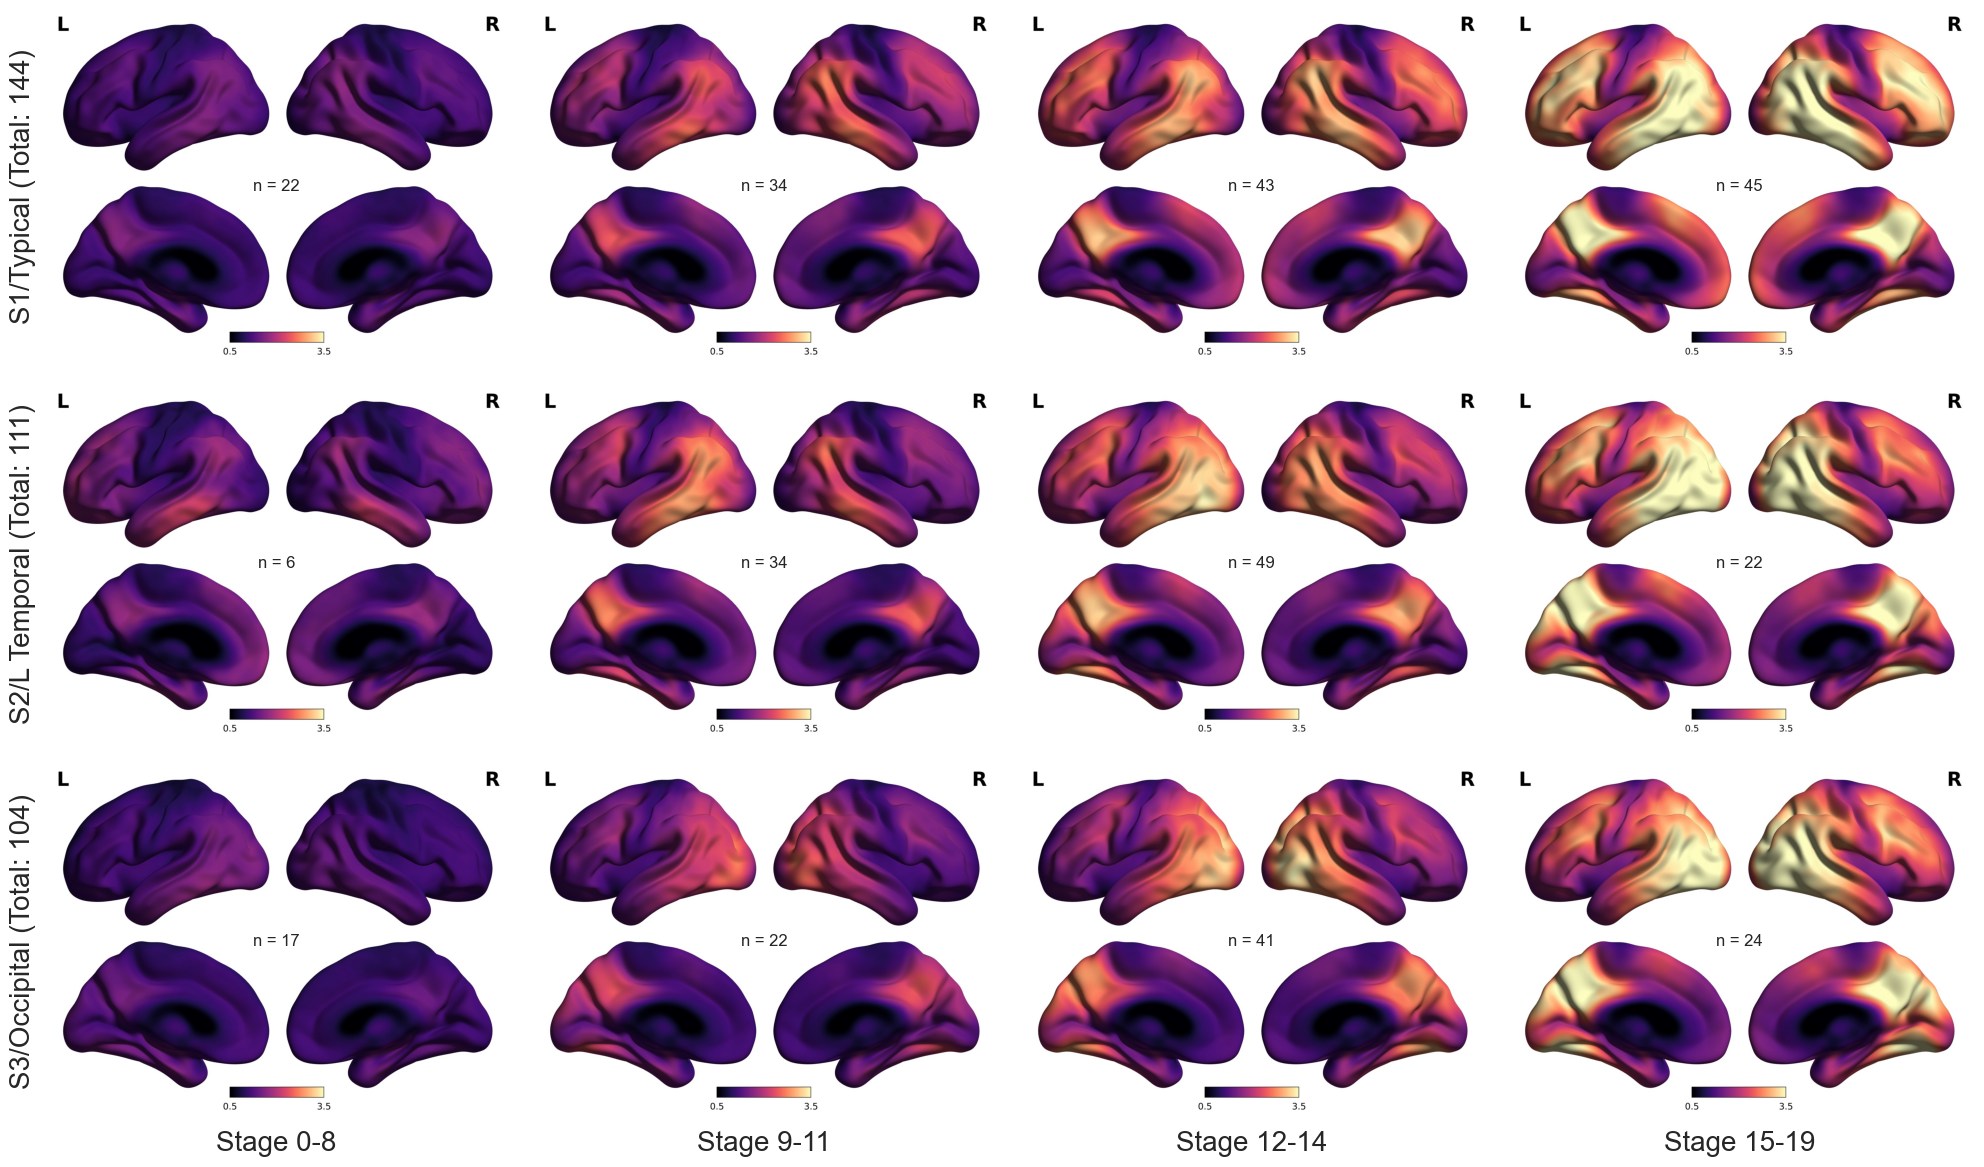

In [529]:
# configuration
img_path = '/Users/linlin/Desktop/brain stuff/graphs/'#'/Users/linlin/Desktop/brain stuff/data/'
type = 'ROI:intersection-C2mean'# threshold type
ss_folder = img_path+'inter_c2mean_subtype_stage_mean/'#'roi_c2meansd_3_subtype_stage_mean/'
def bin_stages(df):
        bins = [0, 8, 11, 14, 19]  #[0, 4, 9, 14, 19] #,24]
        labels =['0-8','9-11','12-14','15-19']#['0-4', '5-9', '10-14', '15-19']#'0-4', '5-9', '10-14', '15-19']#,'20-24','25-29']#0, '0-9', '10-12', '13:15', '16:19'
        df['3s_binned'] = pd.cut(df['3s'], bins=bins, labels=labels, include_lowest=True)
        return df
def calculate_scan_counts(df):
    return df.groupby(['3', '3s_binned']).size().unstack(fill_value=0)
def plot_subtype_stage_images_adjusted(typedf, ss_folder, baseline_folder):
    df = bin_stages(typedf)
    scan_counts = calculate_scan_counts(df)
    fig, axs = plt.subplots(3, 4, figsize=(20, 12))
    stage_labels =  ['0-8','9-11','12-14','15-19']#['0-4', '5-9', '10-14', '15-19']#,'20-24','25-29']
    total_counts = scan_counts.sum(axis=1)
    for subtype in range(3):
        for i, stage_bin in enumerate(stage_labels):
            # Default image path
            image_name = f"subtype{subtype+1}_stage{stage_bin}.jpg"#f"ICBM_mean_x3_subtype{subtype+1}_stage{stage_bin}.jpg"
            image_path = os.path.join(ss_folder, image_name)
            #print(image_path)

            # Check the scan count
            count = scan_counts.loc[subtype+1, stage_bin]

            if count == 1 and not os.path.exists(image_path):
                # If count is 1 and image doesn't exist, find the corresponding image in 'typedf'
                print('sus')
                row = typedf[(typedf['3'] == subtype+1) & (typedf['3s_binned'] == stage_bin)]
            
                if not row.empty:
                    # Use the 'fname' field to find the image in the baseline folder
                    fname = row['fname'].values[0]
                    print(row['fname'].values[0])
                    baseline_image_path = os.path.join(ss_folder,'ICBM_lateral_medial_'+fname[:-4]+'.png')
                    print(baseline_image_path)
                    if os.path.exists(baseline_image_path):
                        image_path = baseline_image_path  # Use this image if it exists

            if os.path.exists(image_path):
                img = plt.imread(image_path)
                axs[subtype, i].imshow(img)
            else:
                axs[subtype, i].axis('off')  # Leave blank if the image doesn't exist

            # Remove axis, boundaries, and ticks
            axs[subtype, i].set_xticks([])
            axs[subtype, i].set_yticks([])
            axs[subtype, i].set_xlabel(None) 
            axs[subtype, i].spines['top'].set_visible(False)
            axs[subtype, i].spines['right'].set_visible(False)
            axs[subtype, i].spines['left'].set_visible(False)
            axs[subtype, i].spines['bottom'].set_visible(False)

            # Add the count annotation above
            #axs[subtype, i].set_title(f"n = {count}")
            ymin, ymax = axs[subtype, i].get_ylim()
            xmin, xmax = axs[subtype, i].get_xlim()
            axs[subtype, i].text((xmin+xmax)/2, (ymin+ymax)/2, f"n = {count}", fontsize=12, ha='center', va='center')

            description = ['Typical','L Temporal','Occipital']
            if i == 0:
                axs[subtype, i].set_ylabel(f'S{subtype+1}/{description[subtype]} (Total: {total_counts[subtype+1]})',fontsize=20)
            else:
                axs[subtype, i].set_ylabel(None)

    # Annotate the stages once for the bottom row
    for i, stage_bin in enumerate(stage_labels):
        axs[2, i].set_xlabel(f'Stage {stage_bin}', fontsize=20, labelpad=10)
   # plt.suptitle('Mean FTP-PET SUVR images for subtype and stage (C=3)',fontsize=30)
    plt.tight_layout()  # Adjust layout to fit the suptitle
    plt.show()

plot_subtype_stage_images_adjusted(typedf99[typedf99.visit==1], ss_folder, '')  
 

## table 1 
https://pmc.ncbi.nlm.nih.gov/articles/PMC6951995/ 

https://tableone.readthedocs.io/en/latest/quickstart.html 

In [75]:
from tableone import TableOne

In [77]:
#data cleaning to merge variables 
final  = pd.read_csv(data_path+"ss_assignment/final_inter_c2mean_2_bl_ss.csv" )
cogt1 = pd.read_csv(data_path+"sustain_dat_baseline_filtered.csv")  
# composite cognitive scores for fluency 
cogt1['Phonemic_fluency'] = cogt1['UDSVERLC'] + cogt1['UDSVERLC']
cogt1['Semantic_fluency'] = cogt1['VEG'] + cogt1['ANIMALS']
cogt1[cogt1.dx=='EOAD'].isna().sum()
# merge with existing
combined_bl_merged = combined_bl.merge(
    cogt1[['subj', 'UDSBENTC', 'Line_orientation', 'Line_length', 'TRAILA', 'DIGFORCT',
           'CRAFTURS', 'FTDREAAS', 'FTDSEMSU', 'FTDANATS', 'FTDRATIO', 'FTDVERBC',
           'FTDNOUNC', 'FTDWORRC', 'FTDWORIC', 'FTDSEMMT', 'FTDSENAS', 'VEG',
           'ANIMALS', 'MINTTOTS', 'MOCATOTS', 'CDRSB', 'NACCGDS', 'TRAILB',
           'DIGBACCT', 'UDSVERLC', 'UDSVERFC', 'digittotal', 'Match', 'Flanker',
           'avdel30min', 'avdeltot', 'CRAFTDRE', 'UDSBENTD', 'AVTOT5', 'AVDEL30MIN',
           'Phonemic_fluency', 'Semantic_fluency']],
    on='subj',
    how='left'
)
# calculate forgetting
combined_bl_merged['Benson_Forgetting'] = combined_bl_merged['UDSBENTC'] - combined_bl_merged['UDSBENTD']
combined_bl_merged['RAVLT_Forgetting'] = combined_bl_merged['AVTOT5'] - combined_bl_merged['AVDEL30MIN']
combined_bl_merged['Craft_Forgetting'] = combined_bl_merged['CRAFTURS'] - combined_bl_merged['CRAFTDRE']
# filter by ranges
cog_name = pd.read_csv(data_path+'cognitive measures.csv')
for idx, row in cog_name.iterrows():
    related_var = row['related_var']
    if pd.notna(related_var) and related_var in combined_bl_merged.columns:
        min_val = row['min']
        max_val = row['max']
        
        # Set values outside [min, max] to NaN
        combined_bl_merged.loc[~combined_bl_merged[related_var].between(min_val, max_val, inclusive='both'), related_var] = np.nan

# merge with SUVR universal from tau quarterly
taubl = pd.read_csv(data_path+"Marlene_LEADS-FTP-infcblgm_roi-extractions_2025-02-11.csv")
tauqtr = pd.read_csv('/Users/linlin/Desktop/brain stuff/data/LEADS_data_used/2024-q3-ftp.csv') 
# Ensure proper date format
taubl['pet_date'] = pd.to_datetime(taubl['pet_date'], errors='coerce')
combined_bl_merged['ftp_date'] = pd.to_datetime(combined_bl['ftp_date'], errors='coerce')

# Rename for merging
taubl_renamed = taubl.rename(columns={
    'subject_id': 'subj',
    'pet_date': 'ftp_date'
})

# other tau-PET composites
combined_bl_merged = combined_bl_merged.merge(
    taubl_renamed[['subj', 'ftp_date', \
"meta_temporal_MRIBASED_SUVR","mtl_no_hippocampus_MRIBASED_SUVR","basolateral_temporal_MRIBASED_SUVR","temporoparietal_MRIBASED_SUVR","ctx_desikan_MRIBASED_SUVR"
 ]],
    on=['subj', 'ftp_date'],
    how='left'
) 

# save as table one data 
#combined_bl_merged.to_csv(data_path+'tableone_dat.csv',index=False)
# read 
combined_bl_merged = pd.read_csv(data_path+'tableone_dat.csv' )
combined_bl_merged.head(2)

subj fbb_date                                           amy_file  \
0  LDS0070166  8/22/19  I1779005_FBB_Coreg,_Avg,_Std_Img_and_Vox_Siz,_...   
1  LDS0070174  9/10/19  I1778181_FBB_Coreg,_Avg,_Std_Img_and_Vox_Siz,_...   

                    ftp_file ftp_date event  SUVR Frontal  \
0  LDS0070166_FTP_2019-08-21  8/21/19    sc      4.060057   
1  LDS0070174_FTP_2019-09-11  9/11/19    sc      2.835582   

   SUVR MesialTemporal  SUVR MetaTemporal  SUVR TemporoParietal  ...  \
0             2.486346           3.298206              3.806097  ...   
1             1.776591           2.590591              2.836201  ...   

   Phonemic_fluency  Semantic_fluency  meta_temporal_MRIBASED_SUVR  \
0               0.0               5.0                     3.019595   
1               8.0              12.0                     2.351983   

   mtl_no_hippocampus_MRIBASED_SUVR basolateral_temporal_MRIBASED_SUVR  \
0                          2.065431                           3.223368   
1                          1.470560                           2.579943   

   temporoparietal_MRIBASED_SUVR  ctx_desikan_MRIBASED_SUVR Benson_Forgetting  \
0                       3.309344                   2.675168               2.0   
1                       2.551292                   2.065932               3.0   

   RAVLT_Forgetting  Craft_Forgetting  
0               NaN               0.0  
1               0.0              -2.0  

[2 rows x 105 columns]

### one vs rest

In [80]:
cont = [ 'Centiloids MRI-Based Composite',
       'Yrs. of Education','Age', 'CDR-SB',# 'Total 13','Delayed Recall',
       'SUVR Frontal', 'SUVR MesialTemporal', 'SUVR MetaTemporal', 'SUVR TemporoParietal',
       'MMSE','stage',  'SUVR Universal','ctx_desikan_MRIBASED_SUVR','meta_temporal_MRIBASED_SUVR', 
"mtl_no_hippocampus_MRIBASED_SUVR",
"basolateral_temporal_MRIBASED_SUVR",  
"temporoparietal_MRIBASED_SUVR", "SUVR MRI-Based Composite",
'UDSBENTC', 'Line_orientation',
       'Line_length', 'TRAILA', 'DIGFORCT', 'CRAFTURS', 'FTDREAAS', 'FTDSEMSU',
       'FTDANATS', 'FTDRATIO', 'FTDVERBC', 'FTDNOUNC', 'FTDWORRC', 'FTDWORIC',
       'FTDSEMMT', 'FTDSENAS', 'VEG', 'ANIMALS', 'MINTTOTS', 'MOCATOTS',
       'CDRSB', 'NACCGDS',     'TRAILB', 'DIGBACCT',
       'UDSVERLC', 'UDSVERFC', 'digittotal', 'Match', 'Flanker', 'avdel30min',
       'avdeltot', 'CRAFTDRE', 'UDSBENTD','RAVLT_Forgetting','Craft_Forgetting','Benson_Forgetting','Phonemic_fluency','Semantic_fluency']#,"SUVR PET-Only Composite"]
cat = ['Gender', 'Diagnosis', 'ApoE4 Carrier','Cognitive Behavior','ApoE4 Genotype']#'CDR-Global',
#'CDR-Global',
print('check subtype ordering (excluding poorly fit):')
tdata = combined_bl_merged[~combined_bl_merged.poorly][cont+cat+['subtype']].copy() #exclude poorly classified scans
#tdata['CDR-Global'] = tdata['CDR-Global'].astype('str').replace({'nan':None})
tdata.subtype.value_counts()
 

check subtype ordering (excluding poorly fit):


subtype
1    144
2    111
3    104
Name: count, dtype: int64

In [ ]:
 
#t1 = TableOne(data=tdata[tdata.subtype.isin([1,2,3])], columns=cont+cat, categorical=cat, groupby='subtype', pval=True, pval_adjust='bonferroni')
# one vs rest
subtype = 1
# Create a new column for the "rest" (excluding control)
tdata['subtype_vs_rest'] = tdata.apply(lambda x: 1 if x['subtype'] == subtype else (0 if pd.notna(x['subtype']) else np.nan), axis=1)
# Generate TableOne for subtype vs rest (excluding control)
tb = TableOne(data=tdata.dropna(subset=['subtype_vs_rest']), columns=cont+cat, categorical=cat, groupby='subtype_vs_rest', pval=True,
         order = {'CDR-Global':['0.0','0.5','1.0','2.0','3.0'],
                  'Gender':['Female','Male'],
                  'Diagnosis':['MCI','Dementia'],
                  'Cognitive Behavior':['Amnestic-predominant CI (single/multi-domain)', 'Non-amnestic CI (single/multi-domain)','PPA','PCA'],
                  'ApoE4 Carrier':['Carrier','Non carrier'],
                  'ApoE4 Genotype':['Homozygote','Heterozygote','Non carrier']},
                #  nonnormal = ['MMSE', 'Total 13', 'Yrs. of Education', 'stage'],
                  row_percent=True,
                  include_null=False,
              #    pval_adjust='bonferroni',
                  normal_test=True,
                 dip_test=True,
                  tukey_test=True)

#error with this: pval_adjust='holm-sidak')
#print(tbl.tabulate(tablefmt="grid")) 


In [83]:
# List to store the processed DataFrames for each subtype
all_tables = []

# Loop over subtypes
for subtype in [1, 2, 3]:
    # Update the `subtype_vs_rest` column for the current subtype
    tdata['subtype_vs_rest'] = tdata.apply(
        lambda x: 1 if x['subtype'] == subtype else (0 if pd.notna(x['subtype']) else np.nan), axis=1
    )
    
    # Generate the TableOne and save it to a temporary CSV
    tbl = TableOne(
        data=tdata.dropna(subset=['subtype_vs_rest']),
        columns=cont + cat,
        categorical=cat,
        groupby='subtype_vs_rest',
        pval=True,
        order={
            'CDR-Global': ['0.0', '0.5', '1.0', '2.0', '3.0'],
            'Gender': ['Female', 'Male'],
            'Diagnosis': ['MCI', 'Dementia'],
            'Clinical Phenotype': [
                'Amnestic-predominant CI (single/multi-domain)',
                'Non-amnestic CI (single/multi-domain)',
                'PPA',
                'PCA',
            ],
            'ApoE4 Carrier': ['Carrier', 'Non carrier'],
            'ApoE4 Genotype': ['Homozygote', 'Heterozygote', 'Non carrier'],
        },
      #  row_percent=True,
        include_null=False,
        tukey_test=True,
        pval_adjust = 'simes-hochberg'#'bonferroni'
    )
    tbl.to_csv('tmptbl.csv')

    # Load the table and process it
    tmptbl = pd.read_csv('tmptbl.csv', header=1)
    tmptbl['OriginalOrder'] = tmptbl.index  # Save the original order
    tmptbl = tmptbl.rename(
        columns={
            'Unnamed: 0': 'Variable',
            'Unnamed: 1': 'Category',
            '1': f'S{subtype}',
            'P-Value (adjusted)': f'adj.p S{subtype}',
        }
    )
    
    # Select relevant columns and add the processed table to the list
    tmptbl = tmptbl[['OriginalOrder', 'Variable', 'Category', 'Missing', 'Overall', f'S{subtype}', f'adj.p S{subtype}']]#P-Value (adjusted)
    all_tables.append(tmptbl)

# Merge all tables on the common columns, preserving order
merged_table = all_tables[0]
for tbl in all_tables[1:]:
    merged_table = pd.merge(
        merged_table,
        tbl.drop(columns=['OriginalOrder']),  # Drop OriginalOrder for subsequent merges
        on=['Variable', 'Category', 'Missing', 'Overall'],
        how='outer',
        sort=False  # Avoid any re-sorting
    )

# Restore the original order from the first table
merged_table = merged_table.sort_values(by='OriginalOrder').reset_index(drop=True)
merged_table = merged_table.drop(columns=['OriginalOrder'])  # Clean up auxiliary column
#merged_table['Missing'] = merged_table['Missing'].fillna('0').astype(int).replace({0:np.nan})
merged_table.fillna('',inplace=True)
merged_table


Variable      Category Missing  \
0                                           n                         
1   Centiloids MRI-Based Composite, mean (SD)                   0.0   
2                Yrs. of Education, mean (SD)                   0.0   
3                              Age, mean (SD)                   0.0   
4                           CDR-SB, mean (SD)                   3.0   
..                                        ...           ...     ...   
64                  Cognitive Behavior, n (%)           PCA           
65                  Cognitive Behavior, n (%)           PPA           
66                      ApoE4 Genotype, n (%)    Homozygote     9.0   
67                      ApoE4 Genotype, n (%)  Heterozygote           
68                      ApoE4 Genotype, n (%)   Non carrier           

         Overall            S1 adj.p S1            S2 adj.p S2            S3  \
0            359           144                    111                    104   
1   103.1 (27.9)  104.0 (29.5)    0.982  103.3 (24.5)    0.952  101.6 (29.0)   
2     15.6 (2.4)    15.6 (2.5)    0.982    15.6 (2.4)    0.952    15.8 (2.4)   
3     59.1 (4.0)    58.9 (4.1)    0.982    58.9 (3.9)    0.952    59.6 (3.9)   
4      3.9 (2.0)     4.1 (2.3)    0.982     3.7 (1.8)    0.952     3.8 (1.8)   
..           ...           ...      ...           ...      ...           ...   
64      24 (6.7)       3 (2.1)                2 (1.8)              19 (18.3)   
65      23 (6.4)       6 (4.2)              14 (12.6)                3 (2.9)   
66     56 (16.0)     20 (14.3)    0.982     16 (14.8)    0.952     20 (19.6)   
67    139 (39.7)     51 (36.4)              43 (39.8)              45 (44.1)   
68    155 (44.3)     69 (49.3)              49 (45.4)              37 (36.3)   

   adj.p S3  
0            
1     1.000  
2     1.000  
3     1.000  
4     1.000  
..      ...  
64           
65           
66    1.000  
67           
68           

[69 rows x 10 columns]

Table 1. Summary statistics and 1 vs. rest combined comparison of biomarker, clinical, and demographic variables, two-sample t-tests for continuous variables, and chi-squared tests for categorical variables. For categorical variables, the percentage is row-based. 

In [95]:
 

# Define a function to handle asterisks based on p-value thresholds
def append_asterisks(value, p_value):
    if pd.isnull(value) or pd.isnull(p_value):
        return value  # Return the original value if either is NaN
    
    # Handle p-values written as '<0.001' directly
    if isinstance(p_value, str) and '<' in p_value:
        return f"{value}***"

    # Convert p_value to float if it's not a string
    try:
        p_value = float(p_value)
    except ValueError:
        return value  # Return the original value if conversion fails

    # Apply asterisk rules
    if p_value <= 0.001:
        return f"{value}***"
    elif p_value <= 0.01:
        return f"{value}**"
    elif p_value <= 0.05:
        return f"{value}*"
    else:
        return value

# Iterate over each subtype column and its corresponding p-value column
for subtype in ['S1', 'S2', 'S3']:
    p_col = f'adj.p {subtype}'
    merged_table[subtype] = merged_table.apply(lambda row: append_asterisks(row[subtype], row[p_col]), axis=1)

# Drop the adjusted p-value columns
merged_table.drop(columns=[f'adj.p {subtype}' for subtype in ['S1', 'S2', 'S3']], inplace=True)
merged_table


Variable      Category Missing  \
0                                           n                         
1   Centiloids MRI-Based Composite, mean (SD)                   0.0   
2                Yrs. of Education, mean (SD)                   0.0   
3                              Age, mean (SD)                   0.0   
4                           CDR-SB, mean (SD)                   3.0   
..                                        ...           ...     ...   
64                  Cognitive Behavior, n (%)           PCA           
65                  Cognitive Behavior, n (%)           PPA           
66                      ApoE4 Genotype, n (%)    Homozygote     9.0   
67                      ApoE4 Genotype, n (%)  Heterozygote           
68                      ApoE4 Genotype, n (%)   Non carrier           

         Overall            S1            S2            S3  
0            359           144           111           104  
1   103.1 (27.9)  104.0 (29.5)  103.3 (24.5)  101.6 (29.0)  
2     15.6 (2.4)    15.6 (2.5)    15.6 (2.4)    15.8 (2.4)  
3     59.1 (4.0)    58.9 (4.1)    58.9 (3.9)    59.6 (3.9)  
4      3.9 (2.0)     4.1 (2.3)     3.7 (1.8)     3.8 (1.8)  
..           ...           ...           ...           ...  
64      24 (6.7)       3 (2.1)       2 (1.8)     19 (18.3)  
65      23 (6.4)       6 (4.2)     14 (12.6)       3 (2.9)  
66     56 (16.0)     20 (14.3)     16 (14.8)     20 (19.6)  
67    139 (39.7)     51 (36.4)     43 (39.8)     45 (44.1)  
68    155 (44.3)     69 (49.3)     49 (45.4)     37 (36.3)  

[69 rows x 7 columns]

### anova version

In [96]:
t1 = TableOne(data=tdata[tdata.subtype.isin([1,2,3])], columns=cont+cat, categorical=cat, groupby='subtype', pval=True,row_percent=False)
t1.to_csv('tmp_table.csv')
t1 = pd.read_csv('tmp_table.csv').iloc[2:,:]
t1.columns = ['variable','category','missing','overall','1','2','3','p']
t1

variable      category missing  \
2   Centiloids MRI-Based Composite, mean (SD)           NaN       0   
3                Yrs. of Education, mean (SD)           NaN       0   
4                              Age, mean (SD)           NaN       0   
5                           CDR-SB, mean (SD)           NaN       3   
6                     SUVR Frontal, mean (SD)           NaN       0   
..                                        ...           ...     ...   
68                  Cognitive Behavior, n (%)           PPA     NaN   
69                      ApoE4 Genotype, n (%)  Heterozygote     NaN   
70                      ApoE4 Genotype, n (%)    Homozygote     NaN   
71                      ApoE4 Genotype, n (%)   Non carrier     NaN   
72                      ApoE4 Genotype, n (%)           NaN     NaN   

         overall             1             2             3       p  
2   103.1 (27.9)  104.0 (29.5)  103.3 (24.5)  101.6 (29.0)   0.794  
3     15.6 (2.4)    15.6 (2.5)    15.6 (2.4)    15.8 (2.4)   0.660  
4     59.1 (4.0)    58.9 (4.1)    58.9 (3.9)    59.6 (3.9)   0.305  
5      3.9 (2.0)     4.1 (2.3)     3.7 (1.8)     3.8 (1.8)   0.220  
6      2.4 (0.7)     2.6 (0.8)     2.4 (0.6)     2.1 (0.7)  <0.001  
..           ...           ...           ...           ...     ...  
68      23 (6.4)       6 (4.2)     14 (12.6)       3 (2.9)     NaN  
69    139 (38.7)     51 (35.4)     43 (38.7)     45 (43.3)   0.599  
70     56 (15.6)     20 (13.9)     16 (14.4)     20 (19.2)     NaN  
71    155 (43.2)     69 (47.9)     49 (44.1)     37 (35.6)     NaN  
72       9 (2.5)       4 (2.8)       3 (2.7)       2 (1.9)     NaN  

[71 rows x 8 columns]

### pairwise for significant 

In [87]:
# Get variables with p < 0.05
sig_vars = t1.loc[t1['p'].astype(str).str.replace('<', '').astype(float) < 0.05, 'variable'].tolist()
sig_vars = [i.split(',')[0] for i in sig_vars ]
sig_vars = [s for s in sig_vars if s in cont ]
print("Significant variables:", sig_vars)


Significant variables: ['SUVR Frontal', 'SUVR MesialTemporal', 'SUVR MetaTemporal', 'SUVR TemporoParietal', 'ctx_desikan_MRIBASED_SUVR', 'meta_temporal_MRIBASED_SUVR', 'mtl_no_hippocampus_MRIBASED_SUVR', 'basolateral_temporal_MRIBASED_SUVR', 'UDSBENTC', 'Line_orientation', 'Line_length', 'TRAILA', 'CRAFTURS', 'FTDREAAS', 'FTDSENAS', 'VEG', 'ANIMALS', 'MINTTOTS', 'MOCATOTS', 'TRAILB', 'UDSVERLC', 'UDSVERFC', 'CRAFTDRE', 'RAVLT_Forgetting', 'Craft_Forgetting', 'Benson_Forgetting', 'Phonemic_fluency', 'Semantic_fluency']


In [90]:

results = []

for var in sig_vars:
    # Drop rows where the variable or subtype is missing
    temp_data = tdata[['subtype', var]].dropna()

    # Tukey's HSD
    tukey = pairwise_tukeyhsd(endog=temp_data[var],
                              groups=temp_data['subtype'],
                              alpha=0.05)

    # Collect results
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:],  # Skip header row
                            columns=tukey.summary().data[0])
    tukey_df['variable'] = var

    results.append(tukey_df)

# Concatenate all Tukey results into one DataFrame
tukey_results = pd.concat(results, ignore_index=True)
tukey_df = tukey_results.copy() 
tukey_df['comparison'] = tukey_df['group1'].astype(int).astype(str) + 'vs' + tukey_df['group2'].astype(int).astype(str)
tukey_df = tukey_df[['variable', 'comparison', 'p-adj']]
tukey_wide = tukey_df.pivot(index='variable', columns='comparison', values='p-adj').reset_index()
tukey_wide = tukey_wide.rename(columns={
    '1vs2': 'p_1vs2',
    '1vs3': 'p_1vs3',
    '2vs3': 'p_2vs3'
})

tukey_wide.to_clipboard()

## legend definition

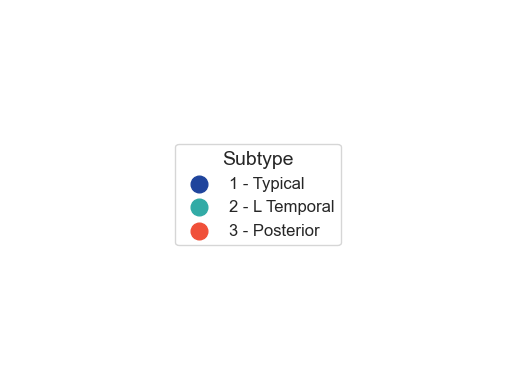

In [100]:

# Define the labels and colors
labels = ['1 - Typical','2 - L Temporal','3 - Posterior']
cols = ["#1f449c","#32ABA6","#f05039"]
# Create dummy scatter plots for legend
for color, label in zip(cols, labels):
    plt.scatter([], [], color=color, label=label)
# Create the legend 
plt.legend(title="Subtype", loc='center', frameon=True, fontsize=12, title_fontsize=14)
plt.axis('off')  # Hide the axes since this is just for the legend
plt.show()

## laterality  

In [101]:

plt.rcParams['axes.titlesize'] = 16 # Set title font size
plt.rcParams['axes.labelsize'] = 16  # Set label font size
plt.rcParams['lines.markersize'] = 12  # Set marker size
plt.rcParams['axes.titleweight'] = 'regular'#'bold'  # Set title font weight to bold
plt.rcParams['axes.labelweight'] = 'regular'#'bold'  # Set label font weight to bold
plt.rcParams['xtick.labelsize'] = 16  # Set tick label font size
plt.rcParams['ytick.labelsize'] = 16  # Set tick label font size 
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16

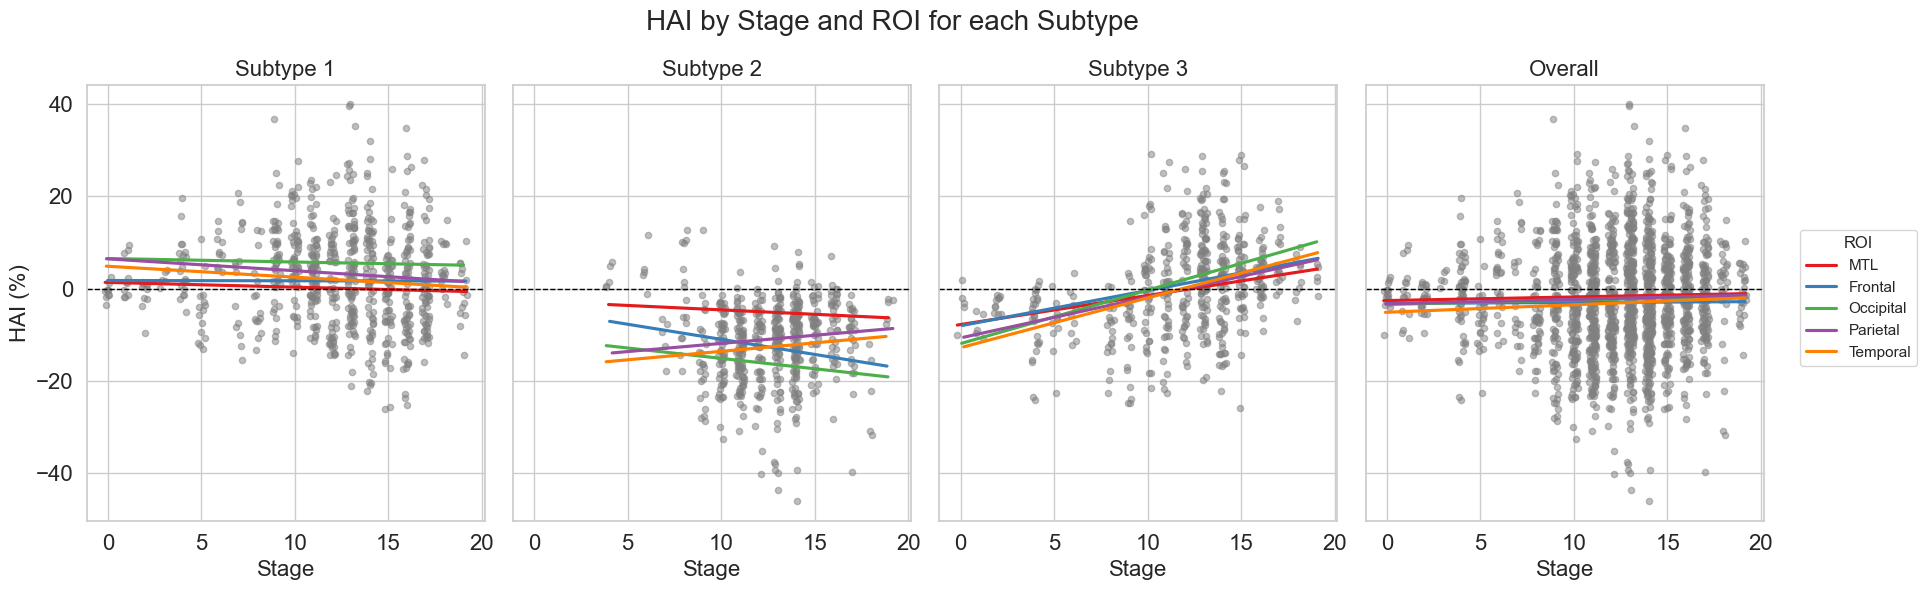

In [102]:
full_data = combined_exclude.copy()
# Define the ROIs and their corresponding columns in the data
rois = {
    'MTL': ('R_MTL', 'L_MTL'),
    'Frontal': ('R_frontal', 'L_frontal'),
    'Occipital': ('R_occipital', 'L_occipital'),
    'Parietal': ('R_parietal', 'L_parietal'),
    'Temporal': ('R_temporal', 'L_temporal')
}

# Calculate HAI for each ROI and add it as a new column in full_data
for roi, (right_col, left_col) in rois.items():
    full_data[f'{roi}_HAI'] = 200 * (full_data[right_col] - full_data[left_col]) / (full_data[right_col] + full_data[left_col])

# Filter for subjects with valid subtypes and stages with 'visit' == 1
filtered_data = full_data[full_data['visit'] == 1].dropna(subset=['subtype', 'stage'])
 
# Melt the data for plotting with Seaborn
hai_columns = [f'{roi}_HAI' for roi in rois]
melted_data = filtered_data.melt(id_vars=['subtype', 'stage'], value_vars=hai_columns, 
                                 var_name='ROI', value_name='HAI')
melted_data['ROI'] = melted_data['ROI'].str.replace('_HAI', '')  # Clean up ROI names

# Add jitter to the stage values for plotting clarity
melted_data['stage_jittered'] = melted_data['stage'] + np.random.uniform(-0.2, 0.2, size=len(melted_data))

# Define color palette for each ROI
roi_palette = sns.color_palette("Set1", len(rois))

# Set up the plot grid with each subtype and an overall plot
unique_subtypes = sorted(melted_data['subtype'].unique())
fig, axes = plt.subplots(1, len(unique_subtypes) + 1, figsize=(18, 6), sharey=True,sharex=True)
fig.suptitle("HAI by Stage and ROI for each Subtype",fontsize=20)

# Plot for each subtype
for j, subtype in enumerate(unique_subtypes):
    ax = axes[j]
    subtype_data = melted_data[melted_data['subtype'] == subtype]
    
    # Plot each ROI's scatter with jittered dots in grey and regression line with separate colors
    for k, (roi, color) in enumerate(zip(rois.keys(), roi_palette)):
        roi_data = subtype_data[subtype_data['ROI'] == roi]
        sns.regplot(
            data=roi_data, x='stage_jittered', y='HAI', 
            scatter_kws={'color': 'grey', 'alpha': 0.5,'s':20}, 
            line_kws={'label': roi, 'color': color}, 
            ax=ax, ci=None
        )
    
    # Add a dashed line at y = 0
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    
    ax.set_title(f'Subtype {subtype}')#({len(subtype_data)/5})
    ax.set_xlabel("Stage")
    if j == 0:
        ax.set_ylabel("HAI (%)")
    else:
        ax.set_ylabel("")

# Overall plot in the last subplot
ax = axes[-1]
for k, (roi, color) in enumerate(zip(rois.keys(), roi_palette)):
    roi_data = melted_data[melted_data['ROI'] == roi]
    sns.regplot(
        data=roi_data, x='stage_jittered', y='HAI', 
        scatter_kws={'color': 'grey', 'alpha': 0.5,'s':20}, 
        line_kws={'label': roi, 'color': color}, 
        ax=ax, ci=None
    )

# Add a dashed line at y = 0 for the overall plot
ax.axhline(0, color='black', linestyle='--', linewidth=1)

ax.set_title('Overall')
ax.set_xlabel("Stage")
ax.set_ylabel("")

# Adjust the legend to show ROI colors outside the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="ROI",  loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()#rect=[0, 0, 1, 0.99]
plt.show()


alternative fit

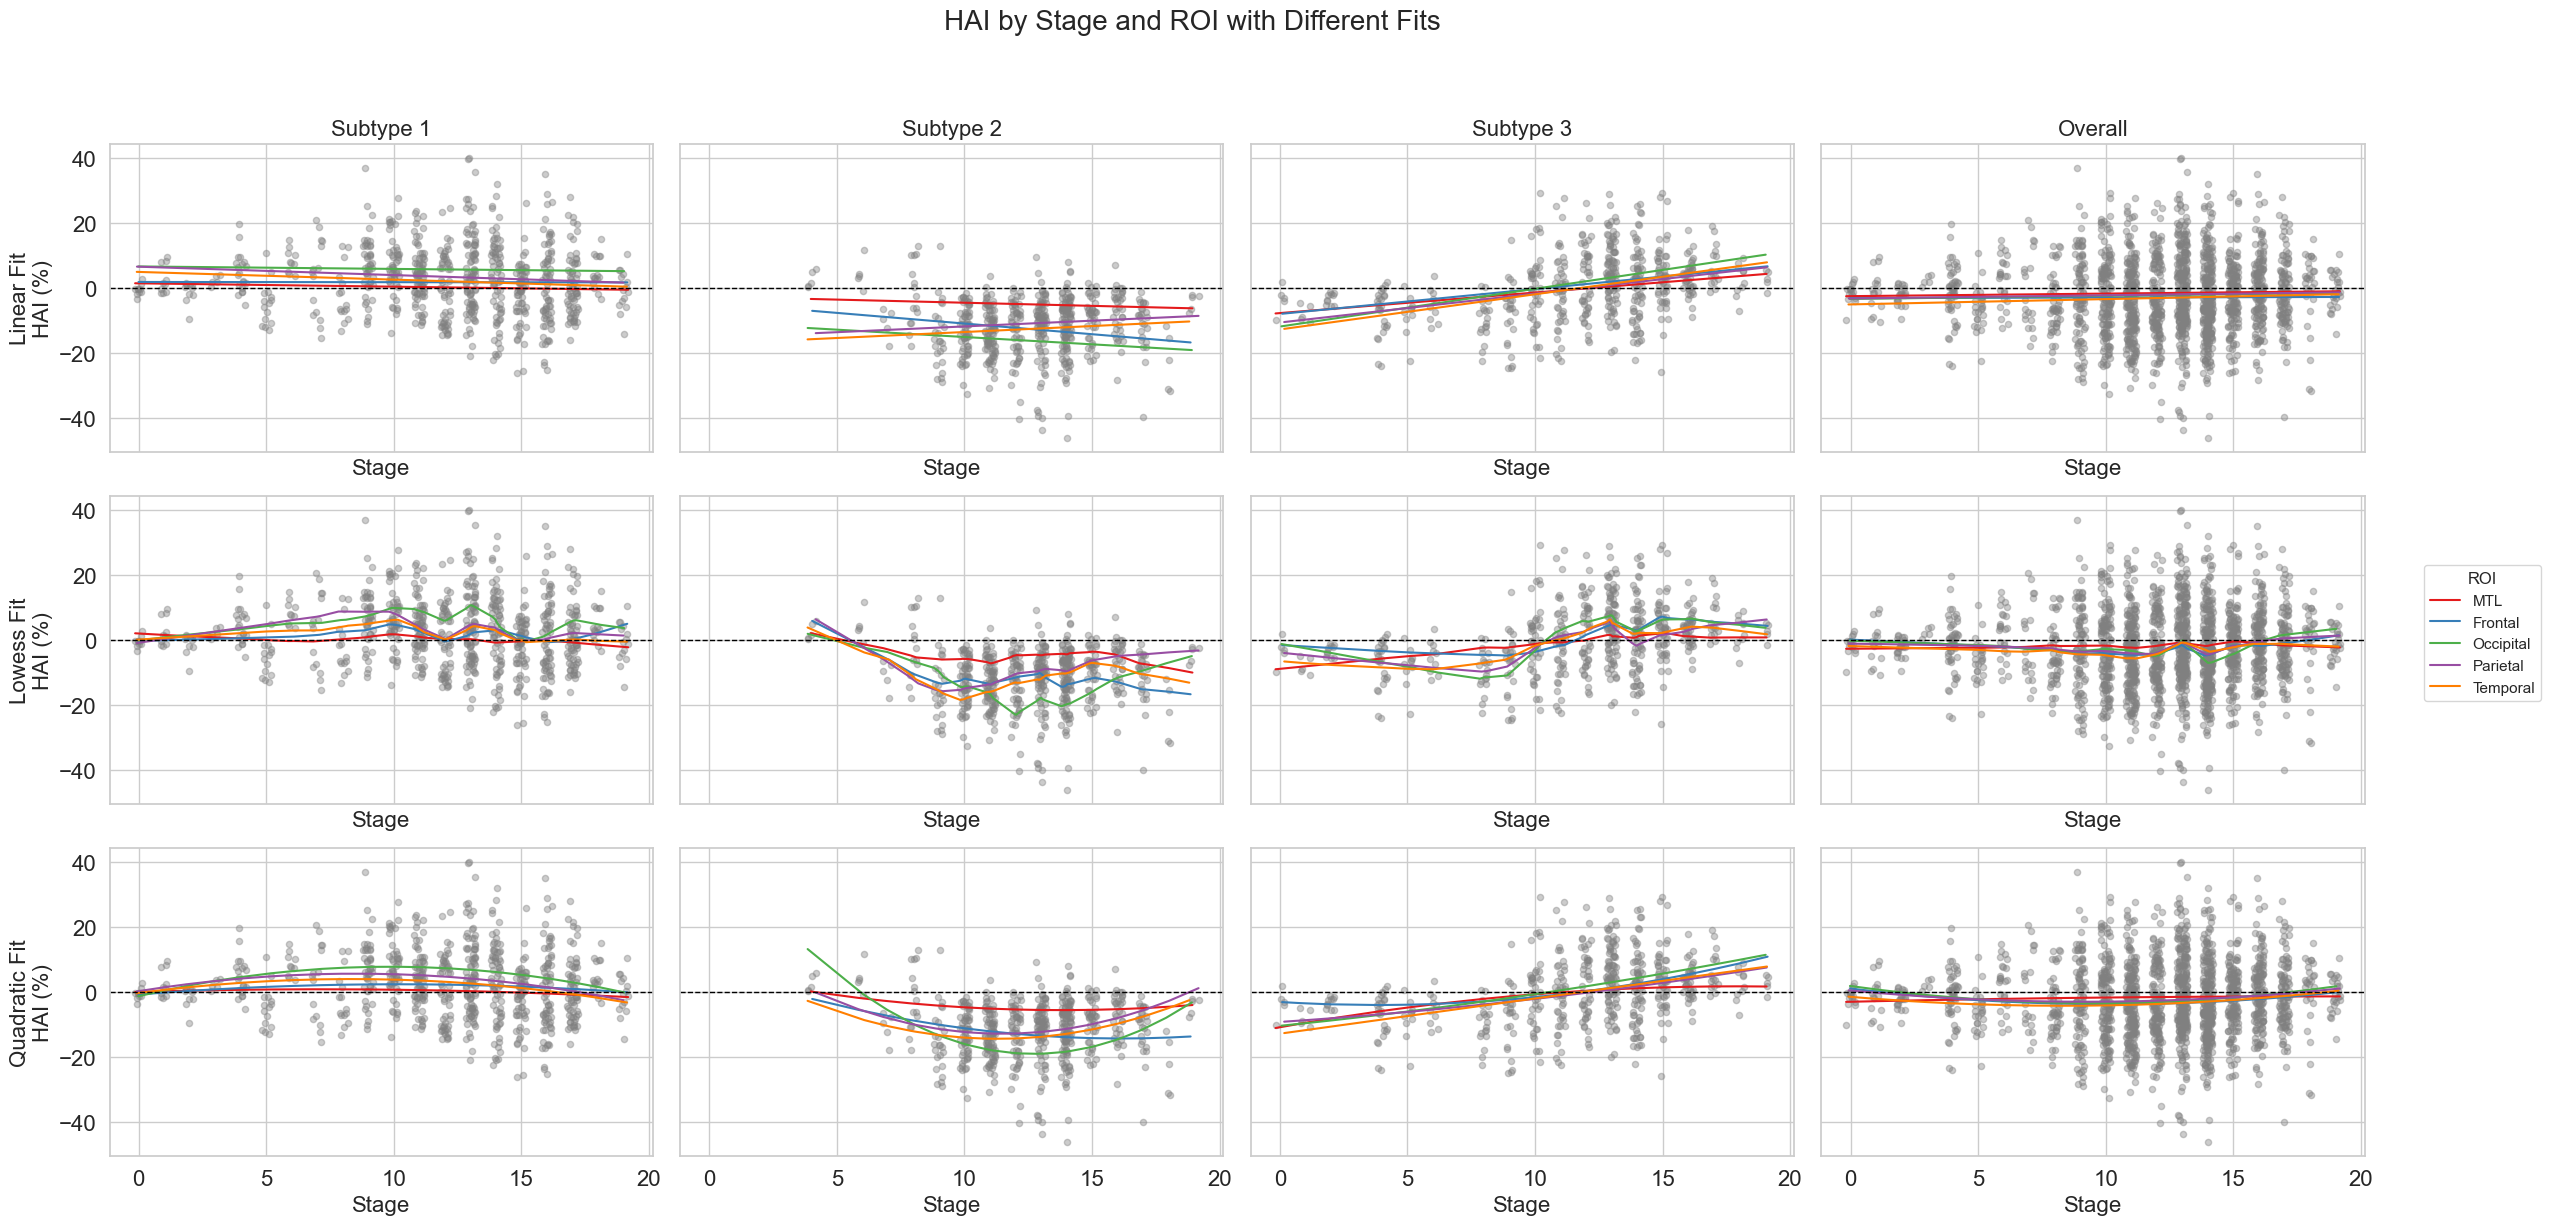

In [103]:
 
from sklearn.metrics import r2_score

# Assuming 'melted_data' is pre-defined from the user's context

# Define ROIs and their color palette
rois = {
    'MTL': ('R_MTL', 'L_MTL'),
    'Frontal': ('R_frontal', 'L_frontal'),
    'Occipital': ('R_occipital', 'L_occipital'),
    'Parietal': ('R_parietal', 'L_parietal'),
    'Temporal': ('R_temporal', 'L_temporal')
}
roi_palette = sns.color_palette("Set1", len(rois))

# Setup
fit_types = ['linear', 'lowess', 'quadratic']
unique_subtypes = sorted(melted_data['subtype'].unique())
n_cols = len(unique_subtypes) + 1  # +1 for overall
n_rows = len(fit_types)

# Create figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True, sharey=True)
fig.suptitle("HAI by Stage and ROI with Different Fits", fontsize=20, y=1.02)

# Store R² values
r2_records = []

# Plot loop
for row_idx, fit_type in enumerate(fit_types):
    for col_idx, subtype in enumerate(unique_subtypes + ['overall']):
        ax = axes[row_idx, col_idx] if n_rows > 1 else axes[col_idx]

        if subtype == 'overall':
            plot_data = melted_data.copy()
            title = 'Overall'
        else:
            plot_data = melted_data[melted_data['subtype'] == subtype]
            title = f'Subtype {subtype}'

        for (roi, color) in zip(rois.keys(), roi_palette):
            roi_data = plot_data[plot_data['ROI'] == roi]
            x = roi_data['stage_jittered'].values
            y = roi_data['HAI'].values

            # Plot scatter
            ax.scatter(x, y, color='grey', alpha=0.4, s=20)

            # Fit and plot
            sorted_idx = np.argsort(x)
            x_sorted = x[sorted_idx]
            y_sorted = y[sorted_idx]

            if fit_type == 'linear':
                coeffs = np.polyfit(x, y, 1)
                fit_func = np.poly1d(coeffs)
                y_pred = fit_func(x)
                ax.plot(x_sorted, fit_func(x_sorted), color=color, label=roi)
                r2 = r2_score(y, y_pred)
                if subtype != 'overall':
                    r2_records.append({'Subtype': subtype, 'ROI': roi, 'Fit': 'linear', 'R2': r2})

            elif fit_type == 'quadratic':
                coeffs = np.polyfit(x, y, 2)
                fit_func = np.poly1d(coeffs)
                y_pred = fit_func(x)
                ax.plot(x_sorted, fit_func(x_sorted), color=color, label=roi)
                r2 = r2_score(y, y_pred)
                if subtype != 'overall':
                    r2_records.append({'Subtype': subtype, 'ROI': roi, 'Fit': 'quadratic', 'R2': r2})

            elif fit_type == 'lowess':
                lowess_fit = sm.nonparametric.lowess(y, x, frac=0.3)
                ax.plot(lowess_fit[:, 0], lowess_fit[:, 1], color=color, label=roi)

        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        if row_idx == 0:
            ax.set_title(title,fontsize=16)
        if col_idx == 0:
            ax.set_ylabel(f"{fit_type.capitalize()} Fit\nHAI (%)", fontsize=16)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("Stage", fontsize=16)
        if row_idx == 0 and col_idx == n_cols - 1:
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, title="ROI", loc='center left', bbox_to_anchor=(1.01, 0.5))

plt.tight_layout(rect=[0, 0, 1, 0.98])


In [104]:

# Convert R² results to DataFrame
r2_df = pd.DataFrame(r2_records)
r2_df.sort_values(by=['ROI','Subtype','R2'],ascending=False)


Subtype        ROI        Fit        R2
29        3   Temporal  quadratic  0.175927
14        3   Temporal     linear  0.175927
24        2   Temporal  quadratic  0.068131
9         2   Temporal     linear  0.011259
19        1   Temporal  quadratic  0.033026
4         1   Temporal     linear  0.010918
28        3   Parietal  quadratic  0.123405
13        3   Parietal     linear  0.122050
23        2   Parietal  quadratic  0.115200
8         2   Parietal     linear  0.014423
18        1   Parietal  quadratic  0.037754
3         1   Parietal     linear  0.010947
27        3  Occipital  quadratic  0.099679
12        3  Occipital     linear  0.098979
22        2  Occipital  quadratic  0.181732
7         2  Occipital     linear  0.013049
17        1  Occipital  quadratic  0.020515
2         1  Occipital     linear  0.000442
25        3        MTL  quadratic  0.281619
10        3        MTL     linear  0.255248
20        2        MTL  quadratic  0.024713
5         2        MTL     linear  0.009992
15        1        MTL  quadratic  0.011810
0         1        MTL     linear  0.006676
26        3    Frontal  quadratic  0.120659
11        3    Frontal     linear  0.102060
21        2    Frontal  quadratic  0.059099
6         2    Frontal     linear  0.047458
16        1    Frontal  quadratic  0.006698
1         1    Frontal     linear  0.000010

Fig. 8: Hemispheric Asymmetry Index (R-L)/[(R+L)/2] * 100 of each lobar ROI vs. Stage by subtype, and overall combined. Above 0 indicates higher in right, below indicates higher in left, the black line at 0 indicates symmetry. 

## clinical phenotype

### by subtype

In [105]:
plt.rcParams['axes.titlesize'] = 18  # Set title font size
plt.rcParams['axes.labelsize'] = 16  # Set label font size
plt.rcParams['lines.markersize'] = 14  # Set marker size
plt.rcParams['axes.titleweight'] = 'regular'#'bold'  # Set title font weight to bold
plt.rcParams['axes.labelweight'] = 'regular'#'bold'  # Set label font weight to bold 
plt.rcParams['xtick.labelsize'] = 14  # Set tick label font size
plt.rcParams['ytick.labelsize'] = 14  # Set tick label font size 

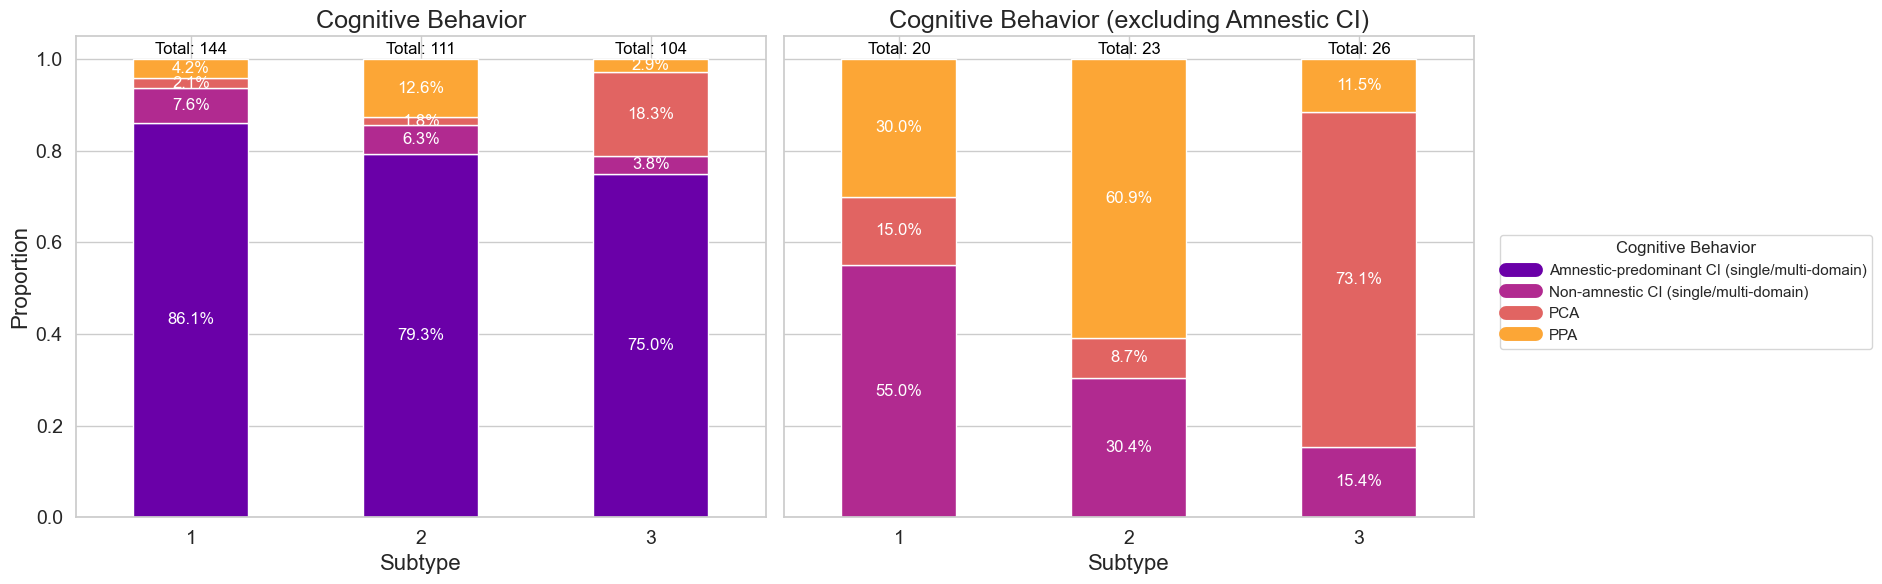

In [106]:
img10 = combined_exclude[combined_exclude.visit == 1].copy()

# Calculate proportions for Cognitive Behavior (including Amnestic CI)
cognitive_behavior_with_amnesic = img10.groupby(['subtype', 'Cognitive Behavior']).size().unstack().apply(lambda x: x / x.sum(), axis=1)

# Calculate proportions for Cognitive Behavior (excluding Amnestic CI)
cognitive_behavior_without_amnesic = img10[img10['Cognitive Behavior'] != 'Amnestic-predominant CI (single/multi-domain)'] \
    .groupby(['subtype', 'Cognitive Behavior']).size().unstack().apply(lambda x: x / x.sum(), axis=1)

# Calculate total counts for annotations
total_counts_with_amnesic = img10.groupby('subtype').size()
total_counts_without_amnesic = img10[img10['Cognitive Behavior'] != 'Amnestic-predominant CI (single/multi-domain)'] \
    .groupby('subtype').size()

# Ensure the same color scale for both subplots
all_categories = set(cognitive_behavior_with_amnesic.columns).union(cognitive_behavior_without_amnesic.columns)
category_palette = sns.color_palette('plasma', len(all_categories))
category_color_mapping = {category: color for category, color in zip(sorted(all_categories), category_palette)}

# Set up the figure for stacked bar plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot Cognitive Behavior (including Amnestic CI)
bars = cognitive_behavior_with_amnesic.plot(
    kind='bar', stacked=True, ax=axes[0],
    color=[category_color_mapping[cat] for cat in cognitive_behavior_with_amnesic.columns], legend=False
)
axes[0].tick_params(axis='x', labelrotation=0)
axes[0].set_title('Cognitive Behavior')
axes[0].set_xlabel('Subtype')
axes[0].set_ylabel('Proportion')

# Adding percentage annotations and total counts
for container in axes[0].containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            axes[0].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f'{height * 100:.1f}%',  # Convert proportion to percentage
                ha='center', va='center', fontsize=12, color='white'
            )

# Adding total count annotations above bars
for x, total in enumerate(total_counts_with_amnesic):
    axes[0].text(
        x, 1.005,  # Position slightly above the bar
        f'Total: {total}', ha='center', va='bottom', fontsize=12, color='black'
    )

# Plot Cognitive Behavior (excluding Amnestic CI)
bars = cognitive_behavior_without_amnesic.plot(
    kind='bar', stacked=True, ax=axes[1],
    color=[category_color_mapping[cat] for cat in cognitive_behavior_without_amnesic.columns], legend=False
)
axes[1].tick_params(axis='x', labelrotation=0)
axes[1].set_title('Cognitive Behavior (excluding Amnestic CI)')
axes[1].set_xlabel('Subtype')
axes[1].set_ylabel('Proportion')

# Adding percentage annotations and total counts
for container in axes[1].containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            axes[1].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f'{height * 100:.1f}%',  # Convert proportion to percentage
                ha='center', va='center', fontsize=12, color='white'
            )

# Adding total count annotations above bars
for x, total in enumerate(total_counts_without_amnesic):
    axes[1].text(
        x, 1.005,  # Position slightly above the bar
        f'Total: {total}', ha='center', va='bottom', fontsize=12, color='black'
    )

# Add a shared legend
handles = [plt.Line2D([0], [0], color=color, linewidth=10) for color in category_color_mapping.values()]
labels = [label for label in sorted(all_categories)]
fig.legend(handles, labels, title="Cognitive Behavior", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()


In [107]:
# Group and count the data to prepare for the Sankey diagram
sankey_data = img10.groupby(['subtype', 'Cognitive Behavior']).size().reset_index(name='Count')

# Create lists of unique nodes for subtypes and behaviors
subtype_nodes = [f"Subtype {x}" for x in sorted(img10['subtype'].unique())]
behavior_nodes = sorted(img10['Cognitive Behavior'].unique())

# Combine all nodes into a single list
all_nodes = subtype_nodes + behavior_nodes

# Create source and target indices
sankey_data['Source'] = sankey_data['subtype'].apply(lambda x: all_nodes.index(f"Subtype {x}"))
sankey_data['Target'] = sankey_data['Cognitive Behavior'].apply(lambda x: all_nodes.index(x))

# Calculate total counts for each cognitive behavior to compute percentages
total_counts = sankey_data.groupby('Target')['Count'].transform('sum')
sankey_data['Percentage'] = (sankey_data['Count'] / total_counts) * 100

# Define the consistent color scheme for cognitive behavior subtypes
color_scheme = {
    'Non-amnestic CI (single/multi-domain)': 'rgba(128, 0, 128, 0.8)',  # Purple
    'PPA': 'rgba(255, 165, 0, 0.8)',  # Orange
    'PCA': 'rgba(220, 20, 60, 0.8)',  # Crimson
    'Amnestic-predominant CI (single/multi-domain)': 'rgba(75, 0, 130, 0.8)'  # Indigo
}

# Map colors to nodes
node_colors = [
    color_scheme.get(node, 'rgba(200, 200, 200, 0.8)') if node in behavior_nodes else 'rgba(200, 200, 200, 0.8)'
    for node in all_nodes
]

# Add hover information for links
hover_text = [
    f"Subtype: {all_nodes[row['Source']]}<br>"
    f"Cognitive Behavior: {all_nodes[row['Target']]}<br>"
    f"Count: {row['Count']}<br>"
    f"Percentage: {row['Percentage']:.2f}%"
    for _, row in sankey_data.iterrows()
]

# Sankey Diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,  # All unique labels
        color=node_colors  # Color nodes based on subtype
    ),
    link=dict(
        source=sankey_data['Source'],  # Source indices
        target=sankey_data['Target'],  # Target indices
        value=sankey_data['Count'],    # Link weights
        color=[color_scheme.get(all_nodes[target], 'rgba(128, 128, 128, 0.8)') for target in sankey_data['Target']],
        customdata=hover_text,  # Add custom hover text
        hovertemplate='%{customdata}<extra></extra>'  # Hover template with no extra text
    )
))

# Update layout
fig.update_layout(
    title_text="Sustain Subtype Assignment vs Cognitive Behavior (Percentage by Cognitive Behavior)",
    font_size=12
)

# Render inline
fig.show()


In [112]:
 
# Define color scheme for subtypes
subtype_color_scheme = {
    "S1/Typical": "#1f449c", 
    "S2/L Temporal":"#32ABA6",  
    "S3/Occipital":  "#f05039" 
}
 
# Map node colors based on subtype
node_colors = [
    subtype_color_scheme.get(node, 'rgba(200, 200, 200, 0.8)') if node in subtype_nodes else 'rgba(200, 200, 200, 0.8)'
    for node in all_nodes
]

# Assign colors to links based on source subtype
link_colors = [
    subtype_color_scheme.get(all_nodes[source], 'rgba(128, 128, 128, 1)')  # Default to gray if missing
    for source in sankey_data['Source']
]

# Add hover information for links
hover_text = [
    f"Subtype: {row['subtype']}<br>"
    f"Cognitive Behavior: {all_nodes[row['Target']]}<br>"
    f"Count: {row['Count']}<br>"
    f"Percentage: {row['Percentage']:.2f}%"
    for _, row in sankey_data.iterrows()
]

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,  # Use the ordered all_nodes list
        color=node_colors,  # Color nodes based on the subtype
        hoverlabel=dict(font=dict(size=12)),  # Adjust hover label font size if needed
    ),
    link=dict(
        source=sankey_data['Source'],  # Source indices
        target=sankey_data['Target'],  # Target indices
        value=sankey_data['Count'],    # Link weights
        color=link_colors,  # Color links based on the source subtype
        customdata=hover_text,  # Add custom hover text
        hovertemplate='%{customdata}<extra></extra>'  # Hover template with no extra text
    )
))

# Update layout
fig.update_layout(
    title=dict(
        text="SuStaIn vs. Cognitive Behavior Subtype",
        x=0.5,
        xanchor='center',
        font=dict(size=12)
    ),
    font_size=1,
    font_color='black',
    width=700,
    height=500
)

# Show the plot
fig.show()


Fig. 9: Clinical phenotype profile of each subtype (left) and excluding those with amnestic-predominant cognitive impairment (CI) (right). S3 is characterized by high percentage of PCA, while S2 is characterized by high percentage of PPA. 

Revision: add sankey. (the percentage is based on the clinical phentype/right side)

### stage by diagnosis

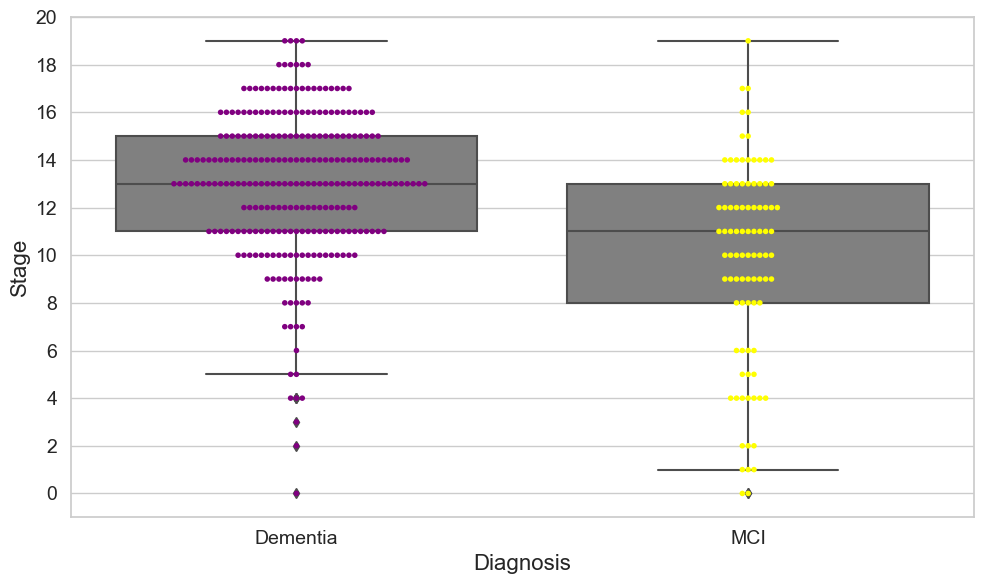

Group 1 (MCI): Mean = 9.75, SD = 4.25, n = 91
Group 2 (Dementia): Mean = 12.96, SD = 3.10, n = 267
t-statistic: -6.6169
p-value: 9.8211e-10
Cohen's d (Effect Size): -0.93
95% CI for Mean Difference: [-4.16, -2.26]


In [102]:
 
warnings.filterwarnings('ignore')
# Prepare the data (Cognitive Behavior including Amnestic-predominant CI)
img10_add = img10.dropna(subset=['Diagnosis'])
# Create a single box+swarm plot
plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(
    data=img10_add, x='Diagnosis', y='stage', color='grey'
)
category_color_mapping = {'Dementia':'purple','MCI':'yellow'}
# Swarmplot with consistent colors
sns.swarmplot(
    data=img10_add, x='Diagnosis', y='stage',
    palette=[category_color_mapping[cat] for cat in img10_add['Diagnosis'].unique()],
    size=4  # Adjust marker size for better visibility
)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=category) 
           for category, color in category_color_mapping.items()]
#plt.legend(handles=handles, title='Diagnosis', loc='lower right', fontsize=10, title_fontsize=12)

# Plot settings
#plt.title('Stage Distribution by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Stage')
plt.ylim(-1, 20)  # Set y-axis range
plt.yticks(range(0, 21, 2))  # Set y-axis ticks at 2-unit increments
plt.xticks(rotation=0, ha='center')  # Rotate x-axis labels for readability
plt.tight_layout()

# Display the plot
plt.show()


# Filter the img11 DataFrame by Diagnosis groups
group1 = img10_add[img10_add['Diagnosis'] == 'MCI']['stage']
group2 = img10_add[img10_add['Diagnosis'] == 'Dementia']['stage']

# Perform two-sample t-test (assuming unequal variances)
t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
mean1, std1 = np.mean(group1), np.std(group1, ddof=1)
mean2, std2 = np.mean(group2), np.std(group2, ddof=1)
# Calculate the effect size (Cohen's d)
n1, n2 = len(group1), len(group2)
pooled_sd = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
cohens_d = (mean1 - mean2) / pooled_sd

# Calculate the 95% confidence interval for the difference in means
mean_diff = mean1 - mean2
se_diff = np.sqrt(std1**2 / n1 + std2**2 / n2)
ci_lower = mean_diff - norm.ppf(0.975) * se_diff
ci_upper = mean_diff + norm.ppf(0.975) * se_diff

# Print the results
print(f"Group 1 (MCI): Mean = {mean1:.2f}, SD = {std1:.2f}, n = {n1}")
print(f"Group 2 (Dementia): Mean = {mean2:.2f}, SD = {std2:.2f}, n = {n2}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Cohen's d (Effect Size): {cohens_d:.2f}")
print(f"95% CI for Mean Difference: [{ci_lower:.2f}, {ci_upper:.2f}]")

 

Fig. 10: Distribution of stages across diagnoses. 

### by subtype and stage

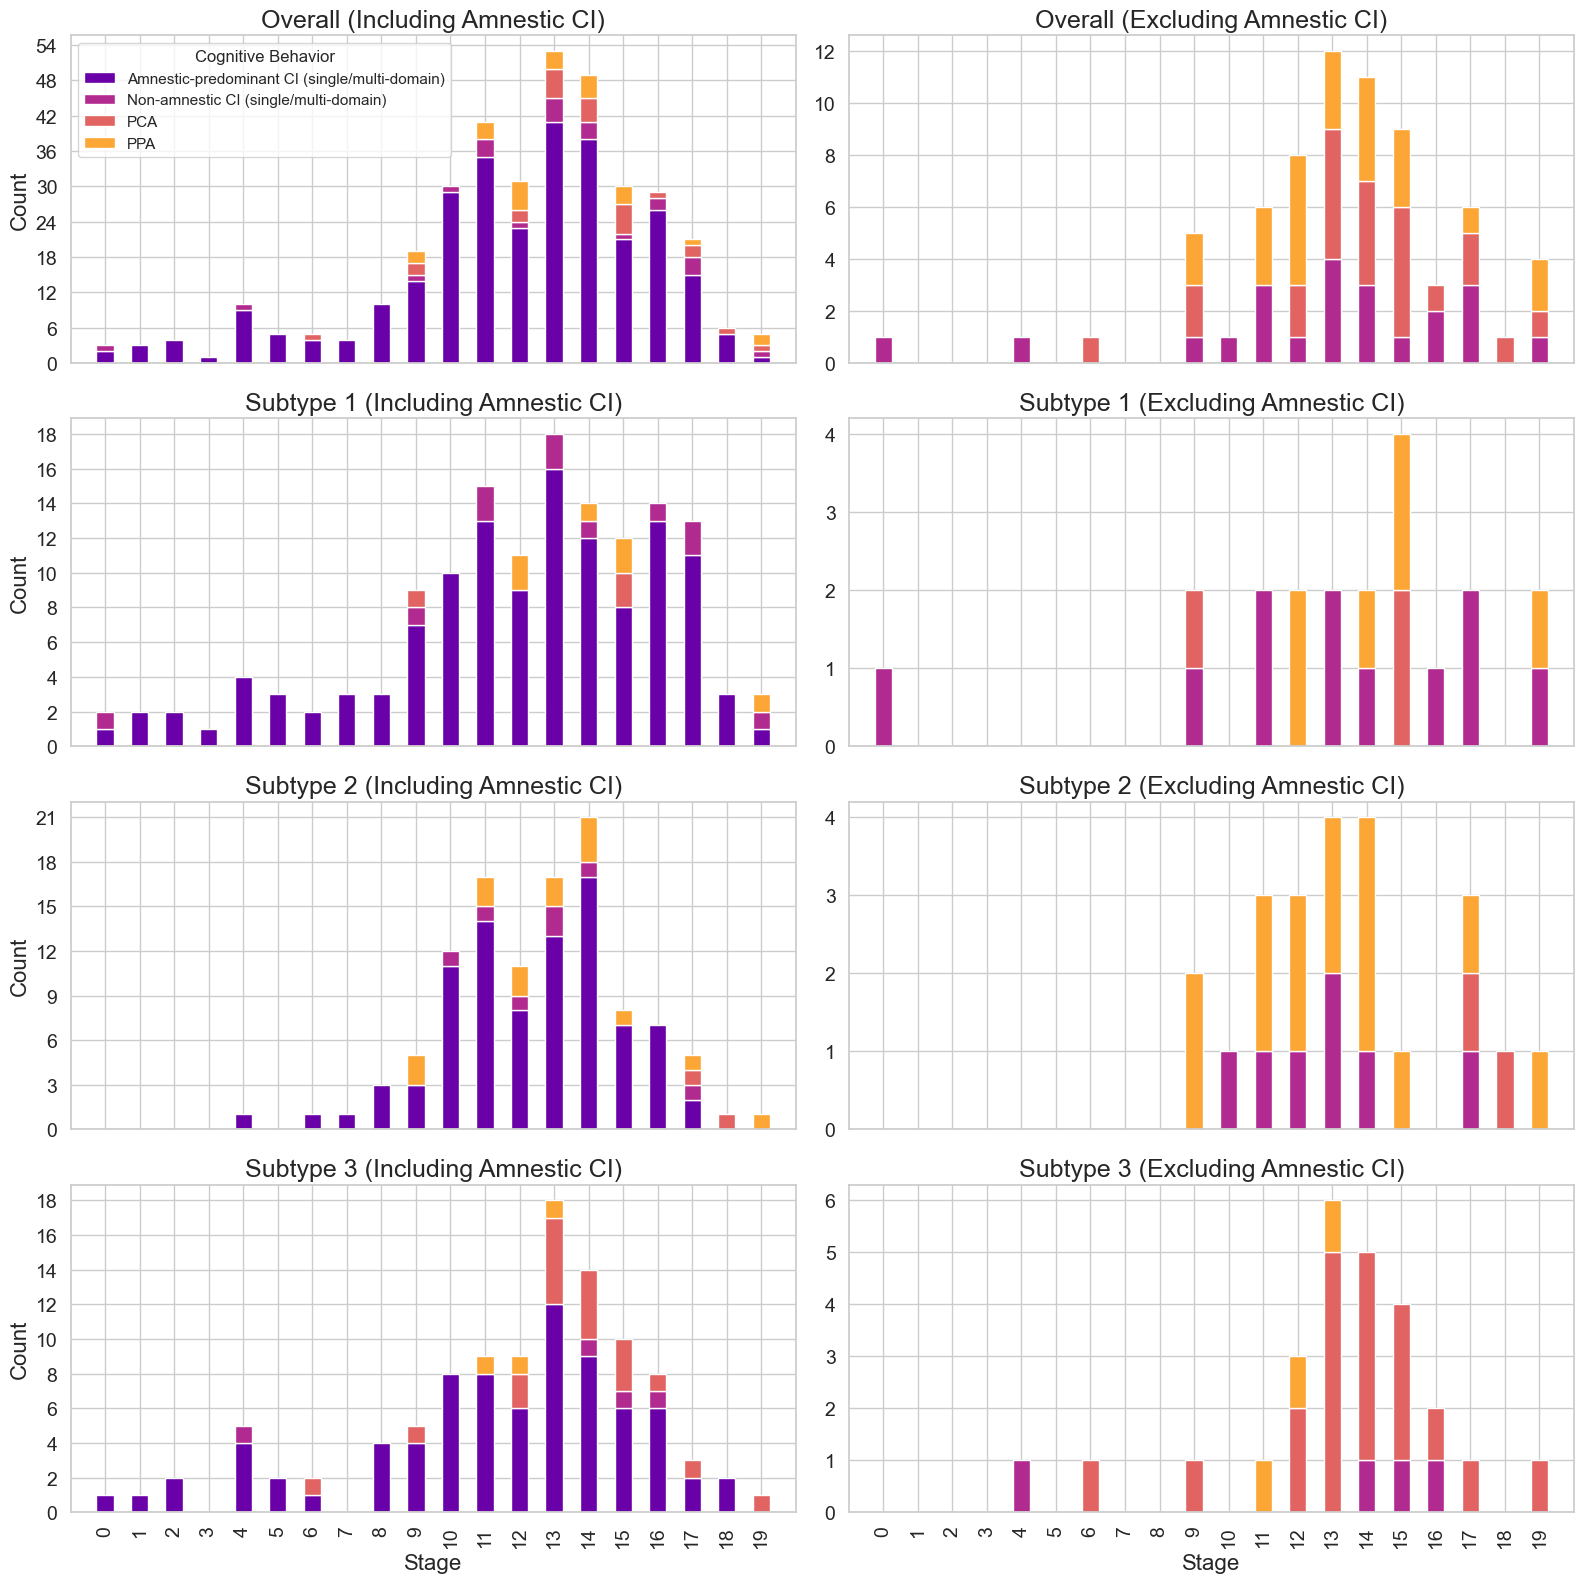

In [114]:


upperr = 20
img11 = img10.copy()

# Define the complete range of stages (0 to upperr) to ensure consistency
all_stages = range(0, upperr)

# List of unique subtypes, including 'Overall' for the first row
subtypes = ['Overall'] + sorted(img11['subtype'].unique().tolist())

# Create a consistent color palette for Cognitive Behavior categories
all_categories = sorted(img11['Cognitive Behavior'].unique())
category_palette = sns.color_palette('plasma', len(all_categories))
category_color_mapping = {category: color for category, color in zip(all_categories, category_palette)}

# Set up the figure with 2 columns (with and without Amnestic) and rows based on subtypes + overall
fig, axes = plt.subplots(len(subtypes), 2, figsize=(16, 4 * len(subtypes)), sharex=True, sharey=False)

# Loop through each subtype, including overall, to plot Cognitive Behavior by stage
for i, subtype in enumerate(subtypes):
    for j, exclude_amnestic in enumerate([False, True]):
        # Filter data for excluding or including Amnestic
        filtered_data = img11 if not exclude_amnestic else img11[img11['Cognitive Behavior'] != 'Amnestic-predominant CI (single/multi-domain)']
        
        # Generate title suffix for the column
        title_suffix = "(Including Amnestic CI)" if not exclude_amnestic else "(Excluding Amnestic CI)"

        # Pivot table for stage vs. Cognitive Behavior
        if subtype == 'Overall':
            cognitive_behavior_counts = filtered_data.pivot_table(
                index='stage', columns='Cognitive Behavior', aggfunc='size', fill_value=0
            )
            cognitive_behavior_counts = cognitive_behavior_counts.reindex(all_stages, fill_value=0)
            title_prefix = "Overall"
        else:
            subtype_data = filtered_data[filtered_data['subtype'] == subtype]
            cognitive_behavior_counts = subtype_data.pivot_table(
                index='stage', columns='Cognitive Behavior', aggfunc='size', fill_value=0
            )
            cognitive_behavior_counts = cognitive_behavior_counts.reindex(all_stages, fill_value=0)
            title_prefix = f"Subtype {subtype}"
        
        # Plot Cognitive Behavior by stage with consistent colors
        cognitive_behavior_counts.plot(
            kind='bar', stacked=True, ax=axes[i, j],
            color=[category_color_mapping[cat] for cat in cognitive_behavior_counts.columns]
        )
        axes[i, j].set_title(f'{title_prefix} {title_suffix}')
        axes[i, j].set_xlabel('Stage' if i == len(subtypes) - 1 else "")
        axes[i, j].set_ylabel('Count' if j == 0 else "")
        axes[i, j].set_xlim([-1, upperr])
        axes[i, j].yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer tick marks
        
        # Remove legend for all but the first plot
        if i > 0 or j > 0:
            axes[i, j].legend().remove()

# Add a shared legend for the entire figure
handles = [plt.Line2D([0], [0], color=color, linewidth=10) for color in category_palette]
labels = [label for label in all_categories]
#fig.legend(handles, labels, title="Cognitive Behavior", loc='center right', bbox_to_anchor=(1.1, 0.5))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Fig. 11: Distribution of cognitive behavior subtypes across stages for each subtype (left), excluding amnestic-predominant CI (right). The left-skewedness reflects the general subtype and stage assignment of patients to be centered around higher stages.

## saving file for ROI definition map 

In [ ]:


# create dict to map parcellations to lobar ROI

cpath='/Users/linlin/Desktop/brain stuff/data/'
ftp = pd.read_csv(cpath+'baseline_FTP_6mm.csv')
# visit = 1, parc = hemfs_roi - dropped
ftp.drop(['ftp_date'],axis=1,inplace=True)
ftp.rename(columns={'ftp_vol':'vol','ftp_suvr':'suvr'},inplace=True)
ftp.head(2)
lobe_dict = {
'L_MTL': ['L_entorhinal','L_amygdala','L_hippocampus' ],
'R_MTL': ['R_entorhinal','R_amygdala','R_hippocampus'],

'L_temporal': ['L_superiortemporal', 'L_middletemporal', 'L_inferiortemporal','L_transversetemporal',
               'L_parahippocampal','L_fusiform'],
'R_temporal': ['R_superiortemporal', 'R_middletemporal','R_inferiortemporal','R_transversetemporal',
               'R_parahippocampal','R_fusiform'],

'L_frontal':['L_superiorfrontal','L_rostralmiddlefrontal','L_caudalmiddlefrontal', #middle frontal gyrus
             'L_parsopercularis', 'L_parsorbitalis', 'L_parstriangularis', #inferior frontal gyrus 
            'L_lateralorbitofrontal','L_medialorbitofrontal', #occipitalfrontal cortex
            'L_rostralanteriorcingulate', 'L_caudalanteriorcingulate',#cingulate
            'L_precentral','L_insula'],
            
'R_frontal':['R_superiorfrontal', 'R_rostralmiddlefrontal', 'R_caudalmiddlefrontal',
             'R_parsopercularis', 'R_parsorbitalis', 'R_parstriangularis',  
             'R_lateralorbitofrontal','R_medialorbitofrontal',
             'R_rostralanteriorcingulate','R_caudalanteriorcingulate', 
              'R_precentral', 'R_insula'], #paracentral?
 
'L_occipital':['L_lateraloccipital','L_lingual','L_cuneus','L_pericalcarine'],
'R_occipital':['R_lateraloccipital','R_lingual','R_cuneus','R_pericalcarine'],

'L_parietal':['L_superiorparietal','L_inferiorparietal','L_supramarginal',
             'L_postcentral','L_precuneus',
             'L_posteriorcingulate','L_isthmuscingulate'],#cingulate
'R_parietal':['R_superiorparietal','R_inferiorparietal','R_supramarginal',
              'R_postcentral','R_precuneus', 
             'R_posteriorcingulate', 'R_isthmuscingulate']
}
# use this to subset data for correct ordering!
lobes = ['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal', 
         'L_occipital', 'R_occipital','L_parietal', 'R_parietal' ]
ftp['lobe'] = ftp['roi'].apply(lambda roi: next((lobe for lobe, regions in lobe_dict.items() if roi in regions), None))
ftp = ftp[ftp.subj.isin(['LDS0070120'])]
ftp.drop(columns=['dx','vol'],inplace=True)
ftp = ftp[~ftp.lobe.isna()]
 
# Replace "R_" and "L_" in the `roi` column
ftp['roi'] = ftp['roi'].str.replace("R_", "Right-").str.replace("L_", "Left-")

# Set `suvr` value by `lobe`
lobe_to_value = {"L_parietal": 1, "R_parietal": 1, "L_temporal": 2, "R_temporal": 2,
                 "L_frontal": 3, "R_frontal": 3, "L_occipital": 4,"R_occipital": 4, "L_MTL": 5, "R_MTL": 5}
ftp['suvr'] = ftp['lobe'].map(lobe_to_value)

# Drop the `lobe` column
ftp = ftp.drop(columns=['lobe'])

# Pivot the dataframe
wide_ftp = ftp.pivot(index='subj', columns='roi', values='suvr').reset_index()
wide_ftp.rename(columns={'subj':'Image-name-unique'},inplace=True)
# Reset index for a cleaner display
#wide_ftp.to_csv(data_path+'roi_def_0.csv',index=False)
pd.read_csv(data_path+'roi_def.csv')

# Longitudinal 
- annual rate of change in SuStaIn stage (box+swarm, t-test)
- percentage of subjects that progress/regress/remain in their SuStaIn stage (table, t-test)
- subtype agreement between baseline visit (confusion matrix, kappa)


##  visit overview

In [304]:
# longitudinal data: exclude those that were poorly classified at baseline 
# pre-processing
# 1. exclude sta  ge 0 or poorly fit p < 0.5 at V1 
print(len(combined))
print(len(combined.subj.unique()))
combined_exclude_long = combined.sort_values(by=['subj', 'ftp_date']).copy()
# Filter out subjects with stage 0 or subtype probability < 0.5 at the first visit
first_visit = combined_exclude_long.groupby('subj').first().reset_index()
exclude_mask = (first_visit['subtype_prob'] < 0.5) | (first_visit['stage'] == 0.) 
combined_exclude_long = combined_exclude_long[~combined_exclude_long['subj'].isin(first_visit.loc[exclude_mask, 'subj'])]
print(f'total number of scans after excluding scans from subjects that are poorly & stage 0 assigned at baseline: {len(combined_exclude_long)}')
print(f'total number of subjects after excluding scans from subjects that are poorly assigned & stage 0 at baseline: {len(combined_exclude_long.subj.unique())}')

699
365
total number of scans after excluding scans from subjects that are poorly & stage 0 assigned at baseline: 682
total number of subjects after excluding scans from subjects that are poorly assigned & stage 0 at baseline: 356


In [305]:
# anti amyloid
treatment = pd.read_csv(data_path + 'treatment_exclude.csv')
treatment['startdate'] = treatment['startdate'].str.replace('xx', '01', regex=False)
treatment['startdate'] = pd.to_datetime(treatment['startdate'], format='%Y-%m-%d', errors='coerce')

combined_exclude_long['ftp_date'] = pd.to_datetime(combined_exclude_long['ftp_date'], format='%Y-%m-%d', errors='coerce')
treatment_filtered = treatment[~treatment.txname.isna()][['subject_code', 'startdate']]
treatment_filtered['subject_code'] = treatment_filtered['subject_code'].str.upper()
merged_df = combined_exclude_long.merge(
    treatment_filtered, 
    left_on='subj', 
    right_on='subject_code', 
    how='inner'
)
scans_to_exclude = merged_df[merged_df['ftp_date'] > merged_df['startdate']] 
scans_to_exclude[['subj', 'ftp_date', 'startdate']]
# Exclude scans from combined_exclude_long that match subj and ftp_date in scans_to_exclude
print(len(combined_exclude_long.subj.unique()))
print(len(scans_to_exclude.subj.unique()))

356
15


In [306]:
combined_exclude_long = combined_exclude_long.merge(
    scans_to_exclude[['subj', 'ftp_date']],
    on=['subj', 'ftp_date'],
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns=['_merge']) 


In [307]:

# Subject IDs before exclusion
before_subjects = set(merged_df['subj'].unique())
# Subject IDs after exclusion
after_subjects = set(combined_exclude_long['subj'].unique())
# Which subjects were dropped
dropped_subjects = before_subjects - after_subjects
print("Subjects dropped:", dropped_subjects)
print("Number dropped:", len(dropped_subjects))

Subjects dropped: {'LDS0360520', 'LDS9410450'}
Number dropped: 2


In [308]:
# exclude poorly fitted longtudinal scans
combined_exclude_long = combined_exclude_long[~combined_exclude_long.poorly]
print(len(combined_exclude_long))
print(len(combined_exclude_long.subj.unique()))

660
354


In [309]:
# add baseline variable
bl_var = [
    'CDR-Global', 'Gender', 'Diagnosis', 'Cognitive Behavior', 'ApoE4 Genotype', 'ftp_file', 'ftp_date',
    'Yrs. of Education', 'Age', 'CDR-SB', 'SUVR PET-Only Composite', 'SUVR MRI-Based Composite', 'MMSE',
    'Centiloids MRI-Based Composite', 'Delayed Recall', 'Digit Total'
]
combined_with_baseline = combined_exclude_long.merge(
    combined_exclude[['subj'] + bl_var].drop_duplicates('subj'),
    on='subj',
    suffixes=('', '.baseline'),
    how='left'
)
print(len(combined_with_baseline.subj.unique()))
# Convert dates to datetime format
combined_with_baseline['ftp_date'] = pd.to_datetime(combined_with_baseline['ftp_date'], errors='coerce')
combined_with_baseline['ftp_date.baseline'] = pd.to_datetime(combined_with_baseline['ftp_date.baseline'], errors='coerce')
# Calculate days from baseline
combined_with_baseline['day_to_baseline'] = (
    (combined_with_baseline['ftp_date'] - combined_with_baseline['ftp_date.baseline']).dt.days
)
# Convert to integer
combined_with_baseline['day_to_baseline'] = combined_with_baseline['day_to_baseline'].fillna(0).astype(int)
# Create the file name column
combined_with_baseline['fname'] = combined_with_baseline.apply(
    lambda row: f"/home/mac/mlin2/cluster_analysis/scans/swr{row['ftp_file']}_suvr-infcblgm.nii", axis=1
)
# List of subjects with incorrect dates
wrong_date = ['LDS9410287', 'LDS9410396']
# For the subjects in wrong_date, retain only their visit 1 data
combined_with_baseline = combined_with_baseline[~combined_with_baseline['subj'].isin(wrong_date) | (combined_with_baseline['visit'] == 1)]
print(len(combined_with_baseline.subj.unique()))
combined_exclude_long = combined_with_baseline.copy()
print(f'total number of scans after further exclusion of those obtained after subjects started treatments (or wrong dates): {len(combined_exclude_long)}')
print(f'total number of subjects after further exclusion of those obtained after subjects started treatments (or wrong dates): {len(combined_exclude_long.subj.unique())}')


354
354
total number of scans after further exclusion of those obtained after subjects started treatments (or wrong dates): 657
total number of subjects after further exclusion of those obtained after subjects started treatments (or wrong dates): 354


In [310]:
visit_counts = combined_exclude_long.groupby('subj')['visit'].max().value_counts().sort_index(ascending=False).cumsum().sort_index()
visit_counts

visit
1    354
2    201
3     77
4     25
Name: count, dtype: int64

In [311]:
 

# Sample data (replace with actual visit count data)
visit_counts = [354, 201, 76, 25]  # Cumulative subject counts
visit_labels = ["1", "2", "3", "4+"]  # Corresponding visit count labels

# Create a 3D-style funnel-like bar chart
fig = go.Figure(go.Funnel(
    x=visit_counts, 
    y=visit_labels,
    textinfo="value+percent initial",
    marker=dict(color='black', line=dict(width=1, color="lightgrey"))
))

# Customize layout to resemble the uploaded image
fig.update_layout(
    title="Funnel Chart of Cumulative Subjects by Visit Count",
    xaxis_title="Number of Subjects",
    yaxis_title="Visit Count",
    plot_bgcolor="white",
    paper_bgcolor="white",
    width=600,
    height=500
)

# Display the plot
fig.show()


### followup

In [312]:
# Ensure 'combined_exclude_long' is loaded with a column 'ftp_date'
# Convert 'ftp_date' to datetime format
combined_exclude_long['ftp_date'] = pd.to_datetime(combined_exclude_long['ftp_date'])

# Find the first (baseline) and last visit for each subject
first_last_visits = combined_exclude_long.groupby('subj')['ftp_date'].agg(['min', 'max']).reset_index()

# Exclude subjects where the first and last visit dates are the same
valid_visits = first_last_visits[first_last_visits['min']!=first_last_visits['max']]

# Calculate the difference between the first and last visit in years
valid_visits['follow_up_interval'] = (valid_visits['max'] - valid_visits['min']).dt.days / 365

# Merge baseline visit date (min) with the original data to retain subtype assignment
baseline_visits = valid_visits[['subj', 'min']].merge(
    combined_exclude_long,
    left_on=['subj', 'min'],
    right_on=['subj', 'ftp_date'],
    how='left'
)

# Retain the subtype from the baseline visit in the valid_visits DataFrame
valid_visits = valid_visits.merge(baseline_visits[['subj', 'subtype']], on='subj', how='left')

# Ensure 'subtype' refers to the subtype assigned at the first visit
valid_visits.rename(columns={'subtype': 'baseline_subtype'}, inplace=True)

# Calculate mean and standard deviation of the follow-up interval
mean_interval = valid_visits['follow_up_interval'].mean()
std_interval = valid_visits['follow_up_interval'].std()

print(f"Average Follow-Up Interval: {mean_interval:.2f} years")
print(f"Standard Deviation of Follow-Up Interval: {std_interval:.2f} years") 


Average Follow-Up Interval: 1.90 years
Standard Deviation of Follow-Up Interval: 0.94 years


In [313]:
 
# Group follow-up intervals by subtypes
subtype_groups = [
    valid_visits[valid_visits['baseline_subtype'] == subtype]['follow_up_interval']
    for subtype in valid_visits['baseline_subtype'].unique()
]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*subtype_groups)

# Print results
print("One-Way ANOVA Results:")
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print(f"total subjects with follow-up: {len(valid_visits.subj.unique())}")
# Optional: Print means and standard deviations for each subtype
for subtype in valid_visits['baseline_subtype'].unique():
    data = valid_visits[valid_visits['baseline_subtype'] == subtype]['follow_up_interval']
    print(f"Subtype {subtype}:")
    print(f"  Mean Follow-Up Interval: {data.mean():.2f} years")
    print(f"  SD Follow-Up Interval: {data.std():.2f} years")
    print("-" * 40)


One-Way ANOVA Results:
F-Statistic: 0.65
P-Value: 0.5216
total subjects with follow-up: 201
Subtype 2:
  Mean Follow-Up Interval: 1.95 years
  SD Follow-Up Interval: 1.03 years
----------------------------------------
Subtype 1:
  Mean Follow-Up Interval: 1.80 years
  SD Follow-Up Interval: 0.93 years
----------------------------------------
Subtype 3:
  Mean Follow-Up Interval: 1.97 years
  SD Follow-Up Interval: 0.88 years
----------------------------------------


Fig. 12: Vist overview 

## saving for r (subj list reference)

In [314]:
renamed_lme = combined_exclude_long.copy()
renamed_lme['CDR_SB'] = renamed_lme['CDR-SB']
combined_exclude_long['ftp_date'] = pd.to_datetime(combined_exclude_long['ftp_date'])
first_last_visits = combined_exclude_long.groupby('subj')['ftp_date'].agg(['min', 'max']).reset_index()
valid_visits = first_last_visits[first_last_visits['min']!=first_last_visits['max']]
renamed_lme = renamed_lme[renamed_lme.subj.isin(valid_visits.subj)]
#renamed_lme.to_csv(data_path+'combined_exclude_long_forR_longi.csv',index=False)
len(renamed_lme)

504

## changed subtype subjects

In [326]:
d_changed = combined_exclude_long.copy()
# Ensure 'ftp_date' is datetime and 'stage' is numeric
d_changed['ftp_date'] = pd.to_datetime(d_changed['ftp_date'], errors='coerce')
d_changed['stage'] = pd.to_numeric(d_changed['stage'], errors='coerce') 
# Calculate first and last stage for each subject
first_visit = d_changed.groupby('subj').first().reset_index()
last_visit = d_changed.groupby('subj').last().reset_index()
# Merge first and last visit information
progression_data = pd.merge(
    first_visit[['subj', 'subtype', 'stage', 'ftp_date', 'subtype_prob', 'stage_prob']],
    last_visit[['subj', 'subtype', 'stage', 'ftp_date', 'subtype_prob', 'stage_prob']],
    on='subj', suffixes=('_first', '_last')
)

# Calculate yearly stage change
progression_data['years_diff'] = (progression_data['ftp_date_last'] - progression_data['ftp_date_first']).dt.days / 365
progression_data['rate_of_progression'] = (progression_data['stage_last'] - progression_data['stage_first']) / progression_data['years_diff']

# Identify subjects who changed subtype
progression_data['changed_subtype'] = progression_data['subtype_first'] != progression_data['subtype_last']

# Add "Changed Subtype" as a category for plotting
progression_data['subtype_plot'] = progression_data['subtype_first'].astype(str)
progression_data.loc[progression_data['changed_subtype'], 'subtype_plot'] = 'Changed Subtype'

# Filter the baseline visit (most recent = visit 1)
baseline_data = d_changed[d_changed['visit'] == 1]

# Merge progression data with baseline data
merged_data = pd.merge(progression_data, baseline_data, on='subj')
# only those with longitudinal
longitudinal_subjects = d_changed['subj'].value_counts()
longitudinal_subjects = longitudinal_subjects[longitudinal_subjects > 1].index
merged_data = merged_data[merged_data['subj'].isin(longitudinal_subjects)]
variables_to_compare = [  'stage_first',  
       'subtype_prob_first', 'stage_prob_first',  
       'rate_of_progression',   'SUVR_Frontal', 'SUVR_MesialTemporal',
       'SUVR_MetaTemporal', 'SUVR_TemporoParietal', 'SUVR_Universal', 
       'SUVR_PET_Only_Composite_baseline', 'SUVR_MRI_Based_Composite_baseline', 
       'Centiloids_MRI_Based_Composite_baseline', 'MMSE_baseline',  
       'CDR_SB_baseline',
       'Age_baseline', 'Yrs_of_Education_baseline',
       'ApoE4_Genotype',  'Gender', 'Diagnosis_baseline']

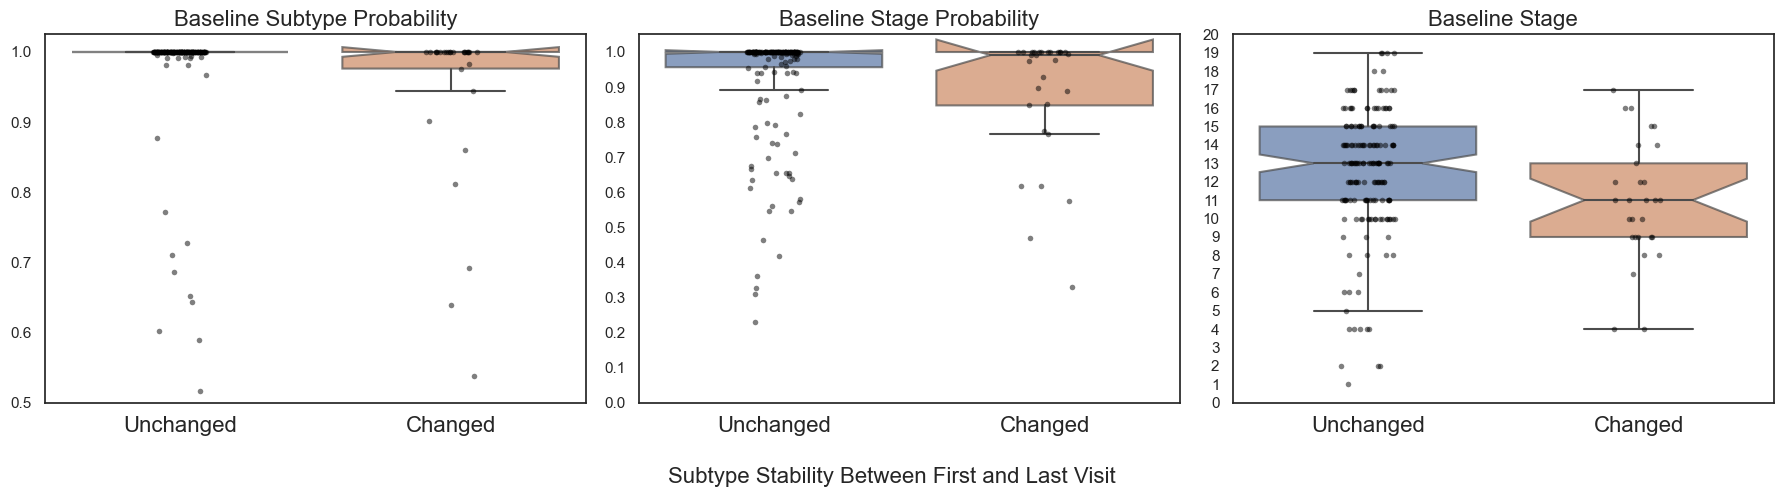

In [332]:
 
# Set seaborn theme without grid
sns.set(style="white")

# Define variables
parametric_vars = ['subtype_prob', 'stage_prob', 'stage']
pretty_labels = {
    'subtype_prob': 'Baseline Subtype Probability',
    'stage_prob': 'Baseline Stage Probability',
    'stage': 'Baseline Stage'
}
y_lims = {
    'subtype_prob': (0.5, 1.025),
    'stage_prob': (0, 1.05),
    'stage': (0.2, 20)
}
y_ticks = {
    'subtype_prob': np.arange(0.5, 1.05, 0.1),
    'stage_prob': np.arange(0, 1.1, 0.1),
    'stage': np.arange(0, 21, 1)
}

# Set up the figure with 3 subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)

for ax, var in zip(axes, parametric_vars):
    # Boxplot
    sns.boxplot(
        data=merged_data, 
        x='changed_subtype', 
        y=var, 
        notch=True,
        showfliers=False, 
        boxprops=dict(alpha=0.7),
        ax=ax
    )
    
    # Overlay stripplot
    sns.stripplot(
        data=merged_data,
        x='changed_subtype',
        y=var,
        color='black',
        size=4,
        alpha=0.5,
        jitter=True,
        ax=ax
    )
    
    # Set labels (only y-axis individually)
    ax.set_title(pretty_labels[var], fontsize=16)
    ax.set_ylabel('')
    ax.set_ylim(y_lims[var])
    ax.set_yticks(y_ticks[var])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Unchanged', 'Changed'],fontsize=16)
    
    # Remove individual x-axis labels
    ax.set_xlabel('')

    # Turn off grid
    ax.grid(False)

# Add one unified x-axis label
fig.supxlabel('Subtype Stability Between First and Last Visit', fontsize=16)

plt.tight_layout()
plt.show()


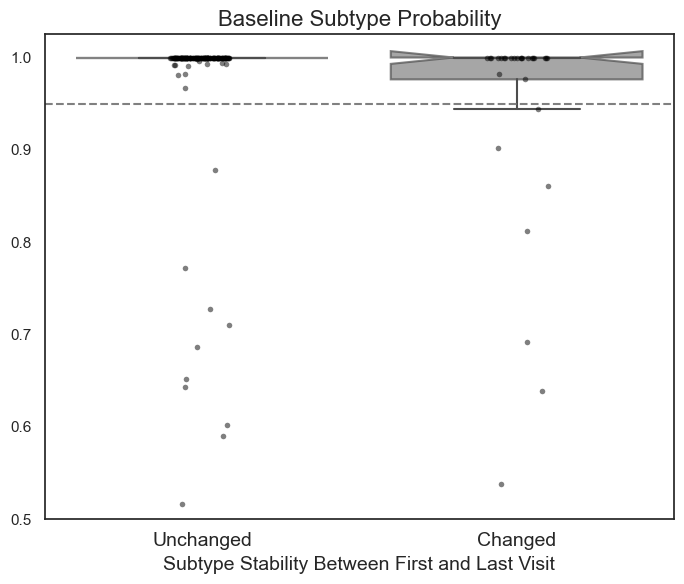

In [329]:
# Set seaborn theme without grid
sns.set(style="white")

# Define variables
var = 'subtype_prob'
pretty_label = 'Baseline Subtype Probability'
y_lim = (0.5, 1.025)
y_ticks = np.arange(0.5, 1.05, 0.1)

fig, ax = plt.subplots(figsize=(7, 6))

# Boxplot
sns.boxplot(
    data=merged_data, 
    x='changed_subtype', 
    y=var, 
    notch=True,
    showfliers=False, 
    boxprops=dict(alpha=0.7),
    color='grey',
    ax=ax
)

# Overlay stripplot
sns.stripplot(
    data=merged_data,
    x='changed_subtype',
    y=var,
    color='black',
    size=4,
    alpha=0.5,
    jitter=True,
    ax=ax
)

# Set title and axis limits
ax.set_title(pretty_label, fontsize=16)
ax.set_ylim(y_lim)
ax.set_yticks(y_ticks)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Unchanged', 'Changed'], fontsize=14)
ax.set_xlabel('Subtype Stability Between First and Last Visit', fontsize=14)
ax.set_ylabel('')

# Dashed line at 0.95
ax.axhline(0.95, color='gray', linestyle='--')

# Annotate counts and percentages
total_n = len(merged_data)
for x_pos, group_label in zip([0, 1], ['Unchanged', 'Changed']):
    count = merged_data[merged_data['changed_subtype'] == x_pos].shape[0]
    pct = (count / total_n) * 100
    ax.annotate(f'n = {count}\n({pct:.1f}%)', 
                xy=(x_pos, y_lim[0] - 0.015), 
                ha='center', va='top', 
                fontsize=12)

plt.tight_layout()
plt.show()


In [339]:


# Binary indicator: high subtype probability at baseline
merged_data['high_subtype_prob'] = merged_data['subtype_prob_first'] > 0.95
merged_data['changed'] = merged_data['changed_subtype'].astype(bool)

# Chi-square test: high subtype probability vs changed
contingency_table = pd.crosstab(merged_data['changed'], merged_data['high_subtype_prob'])
chi2_stat, chi2_p, chi2_df, _ = chi2_contingency(contingency_table)

print("\n--- Chi-Square Test: baseline subtype prob ---")
print(f"Chi2 Statistic: {chi2_stat:.3f}")
print(f"Degrees of Freedom: {chi2_df}")
print(f"p-value: {chi2_p:.4f}") 

# T-test: baseline stage between changed and unchanged groups
stage_changed = merged_data.loc[merged_data['changed'], 'stage_first'].dropna()
stage_unchanged = merged_data.loc[~merged_data['changed'], 'stage_first'].dropna()

t_stat, t_p = ttest_ind(stage_unchanged, stage_changed, equal_var=False)
df_ttest = len(stage_changed) + len(stage_unchanged) - 2

print("\n--- T-Test: Baseline Stage ---")
print(f"T Statistic: {t_stat:.3f}")
print(f"Degrees of Freedom: {df_ttest}")
print(f"p-value: {t_p:.4f}")
print(f"Mean Stage (Unchanged): {stage_unchanged.mean():.2f}")
print(f"Mean Stage (Changed): {stage_changed.mean():.2f}")



--- Chi-Square Test: baseline subtype prob ---
Chi2 Statistic: 8.525
Degrees of Freedom: 1
p-value: 0.0035

--- T-Test: Baseline Stage ---
T Statistic: 2.354
Degrees of Freedom: 199
p-value: 0.0236
Mean Stage (Unchanged): 12.49
Mean Stage (Changed): 10.93


## first and last visit 

### progression rate


--- Annual Progression Rate of Stage ≠ 0 ---

Subtype 1:
  Mean Progression Rate: 0.61 [0.43, 0.79]
  SD Progression Rate: 0.77
  95% CI: [0.43, 0.79]
  t-statistic: 6.72, p-value: 0.0000

Subtype 2:
  Mean Progression Rate: 0.76 [0.50, 1.03]
  SD Progression Rate: 1.06
  95% CI: [0.50, 1.03]
  t-statistic: 5.76, p-value: 0.0000

Subtype 3:
  Mean Progression Rate: 0.51 [0.35, 0.67]
  SD Progression Rate: 0.63
  95% CI: [0.35, 0.67]
  t-statistic: 6.51, p-value: 0.0000


--- Overall Progression Rate ---
Mean Progression Rate: 0.56 [0.45, 0.66]
SD Progression Rate: 0.71
95% CI: [0.45, 0.66]
t-statistic: 10.38, p-value: 0.0000


--- ANOVA Test for Differences Between Subtypes ---
F-statistic: 0.93, p-value: 0.3975



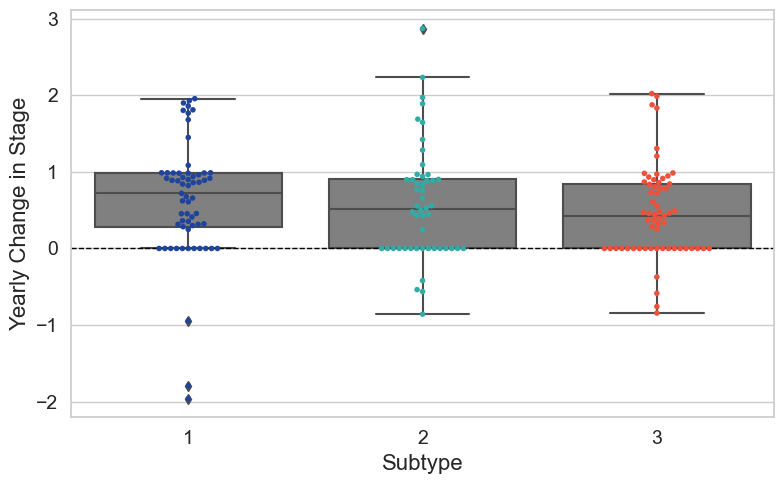

In [317]:

# Step 1: Prepare Data
img1 = combined_exclude_long.copy()

# Ensure 'ftp_date' is datetime and 'stage' is numeric
img1['ftp_date'] = pd.to_datetime(img1['ftp_date'], errors='coerce')
img1['stage'] = pd.to_numeric(img1['stage'], errors='coerce')

# Drop rows with invalid or missing data
img1 = img1.dropna(subset=['ftp_date', 'stage'])

# Calculate first and last stage for each subject
first_visit = img1.groupby('subj').first().reset_index()
last_visit = img1.groupby('subj').last().reset_index()

# Merge first and last visit information
progression_data = pd.merge(
    first_visit[['subj', 'subtype', 'stage', 'ftp_date']],
    last_visit[['subj', 'subtype', 'stage', 'ftp_date']],
    on='subj', suffixes=('_first', '_last')
)

# Calculate yearly stage change
progression_data['years_diff'] = (progression_data['ftp_date_last'] - progression_data['ftp_date_first']).dt.days / 365
progression_data['rate_of_progression'] = (progression_data['stage_last'] - progression_data['stage_first']) / progression_data['years_diff']

# Identify subjects who changed subtype
progression_data['changed_subtype'] = progression_data['subtype_first'] != progression_data['subtype_last']

# Filter out subjects with only one visit
progression_data = progression_data[progression_data['years_diff'] > 0]

# Step 2: Add "Changed Subtype" as a category
progression_data['subtype_plot'] = progression_data['subtype_first'].astype(str)
# progression_data.loc[progression_data['changed_subtype'], 'subtype_plot'] = 'Changed Subtype'

# Step 3: Test progression rate within each subtype
print("\n--- Annual Progression Rate of Stage ≠ 0 ---\n")
for subtype, group in progression_data.groupby('subtype_plot'):
    group = group['rate_of_progression'].dropna()  # Remove NaNs
    n = len(group)
    mean_progression = group.mean()
    sd_progression = group.std()

    # Perform one-sample t-test
    t_stat, p_value = ttest_1samp(group, 0)

    # Calculate 95% CI for the mean progression rate
    ci_range = t.ppf(0.975, df=n-1) * (sd_progression / np.sqrt(n))
    ci_lower = mean_progression - ci_range
    ci_upper = mean_progression + ci_range

    # Print results
    print(f"Subtype {subtype}:")
    print(f"  Mean Progression Rate: {mean_progression:.2f} [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"  SD Progression Rate: {sd_progression:.2f}")
    print(f"  95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"  t-statistic: {t_stat:.2f}, p-value: {p_value:.4f}\n")
overall_group = progression_data[~progression_data.changed_subtype]['rate_of_progression'].dropna()  # Remove NaNs
n_overall = len(overall_group)
mean_overall = overall_group.mean()
sd_overall = overall_group.std()

# Perform one-sample t-test for overall progression rate
t_stat_overall, p_value_overall = ttest_1samp(overall_group, 0)

# Calculate 95% CI for overall progression rate
ci_range_overall = t.ppf(0.975, df=n_overall-1) * (sd_overall / np.sqrt(n_overall))
ci_lower_overall = mean_overall - ci_range_overall
ci_upper_overall = mean_overall + ci_range_overall

# Print overall results
print("\n--- Overall Progression Rate ---")
print(f"Mean Progression Rate: {mean_overall:.2f} [{ci_lower_overall:.2f}, {ci_upper_overall:.2f}]")
print(f"SD Progression Rate: {sd_overall:.2f}")
print(f"95% CI: [{ci_lower_overall:.2f}, {ci_upper_overall:.2f}]")
print(f"t-statistic: {t_stat_overall:.2f}, p-value: {p_value_overall:.4f}\n")

# Step 4: ANOVA to test differences among subtypes
anova_groups = [group['rate_of_progression'].dropna() for _, group in progression_data[~progression_data.changed_subtype].groupby('subtype_plot')]
anova_stat, anova_pval = f_oneway(*anova_groups)

print("\n--- ANOVA Test for Differences Between Subtypes ---")
print(f"F-statistic: {anova_stat:.2f}, p-value: {anova_pval:.4f}\n")

# Step 5: Post-hoc Tukey's HSD Test (if ANOVA is significant)
if anova_pval < 0.05:
    print("\n--- Post-hoc Pairwise Comparison (Tukey's HSD) ---\n")
    tukey = pairwise_tukeyhsd(
        endog=progression_data['rate_of_progression'],
        groups=progression_data['subtype_plot'],
        alpha=0.05
    )
    print(tukey)


# Step 6: Plot the boxplot with annotations
unique_subtypes = progression_data['subtype_plot'].unique()
sorted_subtypes = sorted(unique_subtypes)

progression_data['subtype_plot'] = pd.Categorical(
    progression_data['subtype_plot'],
    categories=sorted_subtypes,
    ordered=True
)

plt.figure(figsize=(8,5))

# Boxplot
sns.boxplot(data=progression_data[~progression_data.changed_subtype], x='subtype_plot', y='rate_of_progression', color='grey')

# Swarmplot
sns.swarmplot(data=progression_data[~progression_data.changed_subtype], x='subtype_plot', y='rate_of_progression',
              hue='subtype_plot', palette=colors, dodge=False, size=4, legend=False)

# Add counts above boxes
group_counts = progression_data[~progression_data.changed_subtype]['subtype_plot'].value_counts()
for i, subtype in enumerate(sorted_subtypes):
    count = group_counts.get(subtype, 0)
   # plt.text(i, progression_data[~progression_data.changed_subtype]['rate_of_progression'].max() + 0.1, str(count),
        #     ha='center', color='black', fontsize=12)

# Add horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Subtype")
plt.ylabel("Yearly Change in Stage")
#plt.title("Annual Change in Stage by Subtype")

plt.tight_layout()
plt.show()


Fig. 13: Annual progression rate of each subtype and those with different subtypes between first and last visit. Does not find significant difference in rate of progression among those that stay within the same subtype.

### percentage stability

In [318]:
# Step 4: Progression Summary Table

# Define progression categories
progression_data['change_type'] = np.where(
    progression_data['stage_last'] > progression_data['stage_first'], 'Progressed',
    np.where(progression_data['stage_last'] < progression_data['stage_first'], 'Regressed', 'Stable')
)

# Calculate percentages for each subtype
summary_table = progression_data.groupby('subtype_plot')['change_type'].value_counts(normalize=True).unstack().fillna(0) * 100
summary_table.loc['All'] = progression_data['change_type'].value_counts(normalize=True) * 100  # Overall row

# Round values for better readability
summary_table = summary_table.round(2)

# Reorder columns and ensure all change types are included
summary_table = summary_table[['Progressed', 'Regressed', 'Stable']]
 

In [319]:
summary_table = summary_table.reset_index()
summary_table[summary_table.subtype_plot!="Changed Subtype"].iloc[:,1:] 

change_type  Progressed  Regressed  Stable
0                 76.71       5.48   17.81
1                 64.06       9.38   26.56
2                 64.06       6.25   29.69
3                 68.66       6.97   24.38

### subtype aggrement

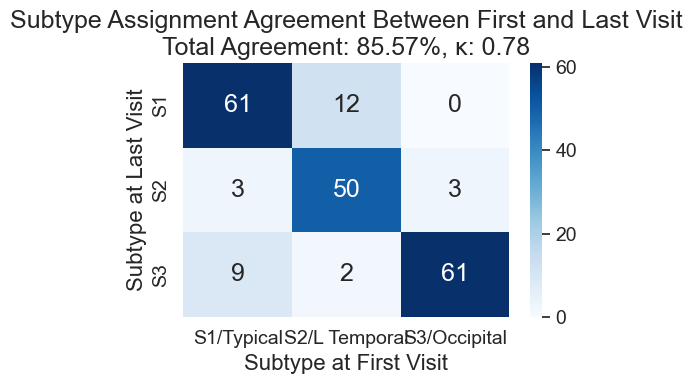

In [320]:

# Merge first and last visit subtypes based on subject IDs 
img2 = img1.sort_values(by=['subj', 'ftp_date']).copy() 
 
# Filter subjects with at least two visits
subject_visit_counts = img2['subj'].value_counts()
subjects_with_multiple_visits = subject_visit_counts[subject_visit_counts > 1].index
img2 = img2[img2['subj'].isin(subjects_with_multiple_visits)]

# Step 2: Extract first and last visit data
img2_first = img2.groupby('subj').first().reset_index()
img2_last = img2.groupby('subj').last().reset_index()
agreement_data = pd.merge(
    img2_first[['subj', 'subtype']],
    img2_last[['subj', 'subtype']],
    on='subj',
    suffixes=('_first', '_last')
)

# Drop rows with invalid or missing subtypes
agreement_data = agreement_data.dropna(subset=['subtype_first', 'subtype_last'])

# Ensure subtype columns are numeric
agreement_data['subtype_first'] = pd.to_numeric(agreement_data['subtype_first'], errors='coerce')
agreement_data['subtype_last'] = pd.to_numeric(agreement_data['subtype_last'], errors='coerce')

# Drop rows where subtypes are still NaN after conversion
agreement_data = agreement_data.dropna(subset=['subtype_first', 'subtype_last'])

# Get all possible subtypes
all_subtypes = sorted(set(agreement_data['subtype_first']).union(set(agreement_data['subtype_last'])))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(agreement_data['subtype_last'], agreement_data['subtype_first'], labels=all_subtypes)

# Calculate agreement metrics
total_correct = np.trace(conf_matrix)
total_cases = conf_matrix.sum()
agreement_percentage = (total_correct / total_cases) * 100
kappa = cohen_kappa_score(agreement_data['subtype_first'], agreement_data['subtype_last'])

# Plot the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(
    conf_matrix, annot=True , fmt='d', cmap='Blues',
    xticklabels=all_subtypes, yticklabels=all_subtypes,
    annot_kws={"size": 18}
)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['S1/Typical', 'S2/L Temporal', 'S3/Occipital'])
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['S1', 'S2', 'S3'])
plt.xlabel("Subtype at First Visit")
plt.ylabel("Subtype at Last Visit")
plt.title(
    f"Subtype Assignment Agreement Between First and Last Visit\n"
    f"Total Agreement: {agreement_percentage:.2f}%, κ: {kappa:.2f}",
)
plt.tight_layout()
plt.show()


## first and second visit

### progression


--- Annual Progression Rate of Stage ≠ 0 ---

Subtype 1:
  Mean Progression Rate: 0.67 [0.47, 0.87]
  SD Progression Rate: 0.87
  95% CI: [0.47, 0.87]
  t-statistic: 6.61, p-value: 0.0000

Subtype 2:
  Mean Progression Rate: 0.81 [0.50, 1.13]
  SD Progression Rate: 1.25
  95% CI: [0.50, 1.13]
  t-statistic: 5.20, p-value: 0.0000

Subtype 3:
  Mean Progression Rate: 0.64 [0.42, 0.85]
  SD Progression Rate: 0.86
  95% CI: [0.42, 0.85]
  t-statistic: 5.93, p-value: 0.0000


--- Overall Progression Rate ---
Mean Progression Rate: 0.61 [0.49, 0.73]
SD Progression Rate: 0.80
95% CI: [0.49, 0.73]
t-statistic: 10.06, p-value: 0.0000


--- ANOVA Test for Differences Between Subtypes ---
F-statistic: 0.43, p-value: 0.6530



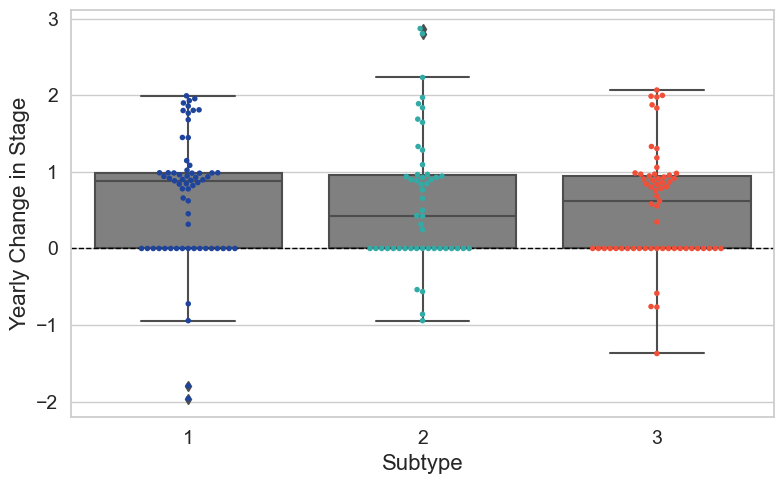

In [321]:
 
# Step 1: Prepare Data
img1 = combined_exclude_long[combined_exclude_long.visit<=2].copy()
  

# Ensure 'ftp_date' is datetime and 'stage' is numeric
img1['ftp_date'] = pd.to_datetime(img1['ftp_date'], errors='coerce')
img1['stage'] = pd.to_numeric(img1['stage'], errors='coerce')

# Drop rows with invalid or missing data
img1 = img1.dropna(subset=['ftp_date', 'stage'])

# Calculate first and last stage for each subject
first_visit = img1.groupby('subj').first().reset_index()
last_visit = img1.groupby('subj').last().reset_index()

# Merge first and last visit information
progression_data = pd.merge(
    first_visit[['subj', 'subtype', 'stage', 'ftp_date']],
    last_visit[['subj', 'subtype', 'stage', 'ftp_date']],
    on='subj', suffixes=('_first', '_last')
)

# Calculate yearly stage change
progression_data['years_diff'] = (progression_data['ftp_date_last'] - progression_data['ftp_date_first']).dt.days / 365
progression_data['rate_of_progression'] = (progression_data['stage_last'] - progression_data['stage_first']) / progression_data['years_diff']

# Identify subjects who changed subtype
progression_data['changed_subtype'] = progression_data['subtype_first'] != progression_data['subtype_last']

# Filter out subjects with only one visit
progression_data = progression_data[progression_data['years_diff'] > 0]

# Step 2: Add "Changed Subtype" as a category
progression_data['subtype_plot'] = progression_data['subtype_first'].astype(str)
# progression_data.loc[progression_data['changed_subtype'], 'subtype_plot'] = 'Changed Subtype'

# Step 3: Test progression rate within each subtype
print("\n--- Annual Progression Rate of Stage ≠ 0 ---\n")
for subtype, group in progression_data.groupby('subtype_plot'):
    group = group['rate_of_progression'].dropna()  # Remove NaNs
    n = len(group)
    mean_progression = group.mean()
    sd_progression = group.std()

    # Perform one-sample t-test
    t_stat, p_value = ttest_1samp(group, 0)

    # Calculate 95% CI for the mean progression rate
    ci_range = t.ppf(0.975, df=n-1) * (sd_progression / np.sqrt(n))
    ci_lower = mean_progression - ci_range
    ci_upper = mean_progression + ci_range

    # Print results
    print(f"Subtype {subtype}:")
    print(f"  Mean Progression Rate: {mean_progression:.2f} [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"  SD Progression Rate: {sd_progression:.2f}")
    print(f"  95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"  t-statistic: {t_stat:.2f}, p-value: {p_value:.4f}\n")
overall_group = progression_data[~progression_data.changed_subtype]['rate_of_progression'].dropna()  # Remove NaNs
n_overall = len(overall_group)
mean_overall = overall_group.mean()
sd_overall = overall_group.std()

# Perform one-sample t-test for overall progression rate
t_stat_overall, p_value_overall = ttest_1samp(overall_group, 0)

# Calculate 95% CI for overall progression rate
ci_range_overall = t.ppf(0.975, df=n_overall-1) * (sd_overall / np.sqrt(n_overall))
ci_lower_overall = mean_overall - ci_range_overall
ci_upper_overall = mean_overall + ci_range_overall

# Print overall results
print("\n--- Overall Progression Rate ---")
print(f"Mean Progression Rate: {mean_overall:.2f} [{ci_lower_overall:.2f}, {ci_upper_overall:.2f}]")
print(f"SD Progression Rate: {sd_overall:.2f}")
print(f"95% CI: [{ci_lower_overall:.2f}, {ci_upper_overall:.2f}]")
print(f"t-statistic: {t_stat_overall:.2f}, p-value: {p_value_overall:.4f}\n")

# Step 4: ANOVA to test differences among subtypes
anova_groups = [group['rate_of_progression'].dropna() for _, group in progression_data[~progression_data.changed_subtype].groupby('subtype_plot')]
anova_stat, anova_pval = f_oneway(*anova_groups)

print("\n--- ANOVA Test for Differences Between Subtypes ---")
print(f"F-statistic: {anova_stat:.2f}, p-value: {anova_pval:.4f}\n")

# Step 5: Post-hoc Tukey's HSD Test (if ANOVA is significant)
if anova_pval < 0.05:
    print("\n--- Post-hoc Pairwise Comparison (Tukey's HSD) ---\n")
    tukey = pairwise_tukeyhsd(
        endog=progression_data['rate_of_progression'],
        groups=progression_data['subtype_plot'],
        alpha=0.05
    )
    print(tukey)


# Step 6: Plot the boxplot with annotations
unique_subtypes = progression_data['subtype_plot'].unique()
sorted_subtypes = sorted(unique_subtypes)

progression_data['subtype_plot'] = pd.Categorical(
    progression_data['subtype_plot'],
    categories=sorted_subtypes,
    ordered=True
)

plt.figure(figsize=(8,5))

# Boxplot
sns.boxplot(data=progression_data[~progression_data.changed_subtype], x='subtype_plot', y='rate_of_progression', color='grey')

# Swarmplot
sns.swarmplot(data=progression_data[~progression_data.changed_subtype], x='subtype_plot', y='rate_of_progression',
              hue='subtype_plot', palette=colors, dodge=False, size=4, legend=False)

# Add counts above boxes
group_counts = progression_data[~progression_data.changed_subtype]['subtype_plot'].value_counts()
for i, subtype in enumerate(sorted_subtypes):
    count = group_counts.get(subtype, 0)
   # plt.text(i, progression_data[~progression_data.changed_subtype]['rate_of_progression'].max() + 0.1, str(count),
        #     ha='center', color='black', fontsize=12)

# Add horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Subtype")
plt.ylabel("Yearly Change in Stage")
#plt.title("Annual Change in Stage by Subtype")

plt.tight_layout()
plt.show()


### percentage stability

In [322]:
# Step 4: Progression Summary Table

# Define progression categories
progression_data['change_type'] = np.where(
    progression_data['stage_last'] > progression_data['stage_first'], 'Progressed',
    np.where(progression_data['stage_last'] < progression_data['stage_first'], 'Regressed', 'Stable')
)

# Calculate percentages for each subtype
summary_table = progression_data.groupby('subtype_plot')['change_type'].value_counts(normalize=True).unstack().fillna(0) * 100
summary_table.loc['All'] = progression_data['change_type'].value_counts(normalize=True) * 100  # Overall row

# Round values for better readability
summary_table = summary_table.round(2)

# Reorder columns and ensure all change types are included
summary_table = summary_table[['Progressed', 'Regressed', 'Stable']]

# Print the progression summary table in the desired format
print("\nProgression Summary Table (%):")
print(summary_table.to_string(float_format=lambda x: f"{x:.1f}"))  # Controls float formatting



Progression Summary Table (%):
change_type   Progressed  Regressed  Stable
subtype_plot                               
1                   67.1        6.8    26.0
2                   59.4       10.9    29.7
3                   57.8        6.2    35.9
All                 61.7        8.0    30.4


In [323]:
summary_table = summary_table.reset_index()
summary_table[summary_table.subtype_plot!="Changed Subtype"].iloc[:,1:]

change_type  Progressed  Regressed  Stable
0                 67.12       6.85   26.03
1                 59.38      10.94   29.69
2                 57.81       6.25   35.94
3                 61.69       7.96   30.35

### subtype aggrement

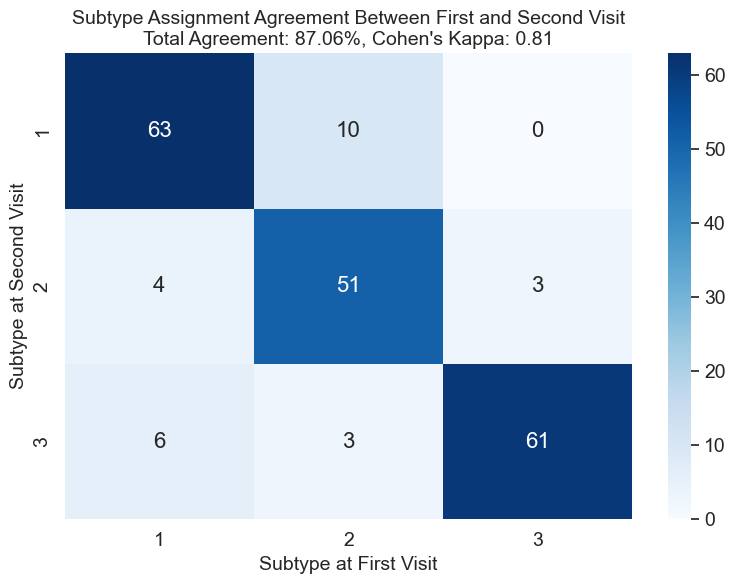

In [324]:
  
img2 = img1.sort_values(by=['subj', 'ftp_date']).copy() 
 
# Filter subjects with at least two visits
subject_visit_counts = img2['subj'].value_counts()
subjects_with_multiple_visits = subject_visit_counts[subject_visit_counts > 1].index
img2 = img2[img2['subj'].isin(subjects_with_multiple_visits)]

# Step 2: Extract first and last visit data
img2_first = img2.groupby('subj').first().reset_index()
img2_last = img2.groupby('subj').last().reset_index()
agreement_data = pd.merge(
    img2_first[['subj', 'subtype']],
    img2_last[['subj', 'subtype']],
    on='subj',
    suffixes=('_first', '_last')
)

# Drop rows with invalid or missing subtypes
agreement_data = agreement_data.dropna(subset=['subtype_first', 'subtype_last'])

# Ensure subtype columns are numeric
agreement_data['subtype_first'] = pd.to_numeric(agreement_data['subtype_first'], errors='coerce')
agreement_data['subtype_last'] = pd.to_numeric(agreement_data['subtype_last'], errors='coerce')

# Drop rows where subtypes are still NaN after conversion
agreement_data = agreement_data.dropna(subset=['subtype_first', 'subtype_last'])

# Get all possible subtypes
all_subtypes = sorted(set(agreement_data['subtype_first']).union(set(agreement_data['subtype_last'])))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(agreement_data['subtype_last'], agreement_data['subtype_first'], labels=all_subtypes)

# Calculate agreement metrics
total_correct = np.trace(conf_matrix)
total_cases = conf_matrix.sum()
agreement_percentage = (total_correct / total_cases) * 100
kappa = cohen_kappa_score(agreement_data['subtype_first'], agreement_data['subtype_last'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='Blues',
    xticklabels=all_subtypes, yticklabels=all_subtypes,
    annot_kws={"size": 16}
)
plt.xlabel("Subtype at First Visit", fontsize=14)
plt.ylabel("Subtype at Second Visit", fontsize=14)
plt.title(
    f"Subtype Assignment Agreement Between First and Second Visit\n"
    f"Total Agreement: {agreement_percentage:.2f}%, Cohen's Kappa: {kappa:.2f}",
    fontsize=14
)
plt.tight_layout()
plt.show()
